# Imports

In [1]:
## imports

import sys
import os
import numpy as np
import xarray as xr
import pandas as pd
import cmocean
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point as cyclic
import cftime
# import nc_time_axis
import datetime

# import time
# import glob, os
# import math
import copy

from sklearn.metrics import r2_score, mean_squared_error
import scipy.interpolate as scp
from scipy.stats import skew
from scipy.ndimage.filters import gaussian_filter
import xskillscore as xs

import eofs
from eofs.xarray import Eof

%load_ext autoreload
%autoreload 2

In [2]:
from defs import EOF_analysis, lowess, MT_spectrum, Confidence_intervals, change_lons, contourlines, lat_ticks, lon_ticks, cyclic_array, varfs, compute_SLP_eofs, variance_bootstrap, eofs_to_nc, varperc, calc_siva, scatter_hist, styles_width
# from defs import change_lons, contourlines, lat_ticks, lon_ticks, varfs, compute_SLP_eofs, eofs_to_nc, varperc

# Load data and grid

In [3]:
ds1 = xr.open_dataset('200years/annular_data/E280p_PV_200jan.nc');
ds2 = xr.open_dataset('200years/annular_data/E560p_PV_200jan.nc');
ds3 = xr.open_dataset('200years/annular_data/Eoi280_PV_200jan.nc');

dsp1 = xr.open_dataset('200years/annular_data/plevs/u_pv_glob1.nc')
dsp2 = xr.open_dataset('200years/annular_data/plevs/u_pv_glob2.nc')
dsp3 = xr.open_dataset('200years/annular_data/plevs/u_pv_glob3.nc')

dsu1 = xr.open_dataset('200years/annular_data/plevs/uv_pv_glob1.nc')
dsu2 = xr.open_dataset('200years/annular_data/plevs/uv_pv_glob2.nc')
dsu3 = xr.open_dataset('200years/annular_data/plevs/uv_pv_glob3.nc')

/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/core/indexing.py:560: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


In [4]:
dsgrid = xr.open_dataset(f'PI_Plio_clim/data/atm/b.PI_1pic_f19g16_NESSC_control.cam2.h0.climatology.years_3000-3050.nc')

grid = dsgrid.gw.isel(record=0)
x = np.empty([len(grid), len(ds1.lon)])
for i in range(144): x[:,i] = grid.values/len(ds1.lon);
gridweights = xr.DataArray(x, [("lat", grid.lat.values), ("lon", ds1.lon.values)])

In [66]:
## Load Eoi400 data

ds4 = xr.open_dataset('200years/annular_data/Eoi400_200y_atm.nc')
ds4 = ds4.isel(time=ds4.groupby('time.month').groups[1]);

## Landfracs

In [34]:
# Get landfracs and add a cyclic point for contour plotting
# define clevel as the contour level on which to plot the landfrac data

clevel = [0.37, 0.37, 0.18]

dsx=ds1.isel(time=0); lf1, lf_lons = cartopy.util.add_cyclic_point(dsx.lfrac, coord=dsx.lfrac.lon)
dsx=ds2.isel(time=0); lf2, _ = cartopy.util.add_cyclic_point(dsx.lfrac, coord=dsx.lfrac.lon)
dsx=ds3.isel(time=0); lf3, _ = cartopy.util.add_cyclic_point(dsx.lfrac, coord=dsx.lfrac.lon)

exp = [1, 2, 3]; 
lf = xr.DataArray(data = np.array([lf1, lf2, lf3]), dims = ["exp", "lat", "lon"], coords = dict(lat = ("lat", dsx.lfrac.lat), lon = ("lon", lf_lons), exp = ("exp", exp)), attrs=dict(description = "landfrac with cyclic point"))
lf_levels = xr.DataArray(data = clevel, dims = "exp", coords = dict(exp = ("exp", exp)), attrs = dict(description = "landfrac contour level"))

lfracs = lf.to_dataset(name = "landfrac")
lfracs["clevel"] = lf_levels

In [38]:
## lfrac data 

lats = [20, 85]; nplons = [120, 240]; nalons = [-90, 30];

lfnh = lfracs.sel(lat = slice(0,85));
lfnh2 = lfracs.sel(lat = slice(-20,85));
lfnh3 = lfracs.sel(lat = slice(-20,90));

lfh = lfracs.sel(lat = slice(lats[0], lats[1])); 
lfp = lfh.sel(lon = slice(nplons[0], nplons[1])); 
lfa = change_lons(copy.copy(lfh)).sel(lon = slice(nalons[0], nalons[1]))


# Compute SLP anomalies and EOFs

## Compute SLP anomalies with lowess filtering

In [73]:
## SLP anomalies with lowess filtering

rmlen = 50; 

# ds1_slpa = ds1.SLP - lowess(ds1.SLP, dim = "time", alpha = rmlen/len(ds1.SLP["time"]), it = 3); 
# ds2_slpa = ds2.SLP - lowess(ds2.SLP, dim = "time", alpha = rmlen/len(ds2.SLP["time"]), it = 3); 
# ds3_slpa = ds3.SLP - lowess(ds3.SLP, dim = "time", alpha = rmlen/len(ds3.SLP["time"]), it = 3); 

## save? 

# folder = '200years/annular_data/eofs/'
# ds1_slpa = ds1_slpa.to_dataset(name = "SLPa")
# eofs_to_nc(ds1_slpa, 'SLP anomalies', 'E280p', '', folder, 'ds1_SLPa_lowess')

# ds2_slpa = ds2_slpa.to_dataset(name = "SLPa")
# eofs_to_nc(ds2_slpa, 'SLP anomalies', 'E560p', '', folder, 'ds2_SLPa_lowess')

# ds3_slpa = ds3_slpa.to_dataset(name = "SLPa")
# eofs_to_nc(ds3_slpa, 'SLP anomalies', 'Eoi280', '', folder, 'ds3_SLPa_lowess')


In [8]:
## load?

folder = '200years/annular_data/eofs/'

ds1_slpa = xr.open_dataset(folder + 'ds1_SLPa_lowess.nc').SLPa
ds2_slpa = xr.open_dataset(folder + 'ds2_SLPa_lowess.nc').SLPa
ds3_slpa = xr.open_dataset(folder + 'ds3_SLPa_lowess.nc').SLPa

nh1 = ds1.SLP.sel(lat = slice(lats[0], lats[1]));
nh2 = ds2.SLP.sel(lat = slice(lats[0], lats[1]));
nh3 = ds3.SLP.sel(lat = slice(lats[0], lats[1]));

/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/core/indexing.py:560: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


## Calculate the EOFs + variance bootstrapping

In [13]:
lats = [20, 85]; nplons = [120, 240]; nalons = [-90, 30];
nmodes = 2;
rmlen = 50; 
nseg = 100; nboot = 250;

# ds1 

# NH
eofsh1, sdnh1 = compute_SLP_eofs(data = ds1_slpa, gridweights=gridweights, nmodes = nmodes, lats = lats, sector = 'NH', sim = 'PI', lowess_filter = False, rmlen = rmlen)
a, b = variance_bootstrap(data = ds1_slpa, gridweights=gridweights, nmodes = nmodes, lats = lats, sector = 'NH', sim = 'PI', nseg = nseg, nboot = nboot)
eofsh1_VE_range = np.round(100*np.array([a, eofsh1.variance_fractions.values, b]),1)

# NA
eofsa1, _ = compute_SLP_eofs(data = ds1_slpa, gridweights=gridweights, nmodes = nmodes, lats = lats, sector = 'NA', sim = 'PI', lowess_filter = False, rmlen = rmlen)
a, b = variance_bootstrap(data = ds1_slpa, gridweights=gridweights, nmodes = nmodes, lats = lats, sector = 'NA', sim = 'PI', nseg = nseg, nboot = nboot)
eofsa1_VE_range = np.round(100*np.array([a, eofsa1.variance_fractions.values, b]),1)

# NP
eofsp1, _ = compute_SLP_eofs(data = ds1_slpa, gridweights=gridweights, nmodes = nmodes, lats = lats, sector = 'NP', sim = 'PI', lowess_filter = False, rmlen = rmlen)
a, b = variance_bootstrap(data = ds1_slpa, gridweights=gridweights, nmodes = nmodes, lats = lats, sector = 'NP', sim = 'PI', nseg = nseg, nboot = nboot)
eofsp1_VE_range = np.round(100*np.array([a, eofsp1.variance_fractions.values, b]),1)

# ds2 

# NH
eofsh2, sdnh2 = compute_SLP_eofs(data = ds2_slpa, gridweights=gridweights, nmodes = nmodes, lats = lats, sector = 'NH', sim = 'PI', lowess_filter = False, rmlen = rmlen)
a, b = variance_bootstrap(data = ds2_slpa, gridweights=gridweights, nmodes = nmodes, lats = lats, sector = 'NH', sim = 'PI', nseg = nseg, nboot = nboot)
eofsh2_VE_range = np.round(100*np.array([a, eofsh2.variance_fractions.values, b]),1)

# NA
eofsa2, _ = compute_SLP_eofs(data = ds2_slpa, gridweights=gridweights, nmodes = nmodes, lats = lats, sector = 'NA', sim = 'PI', lowess_filter = False, rmlen = rmlen)
a, b = variance_bootstrap(data = ds2_slpa, gridweights=gridweights, nmodes = nmodes, lats = lats, sector = 'NA', sim = 'PI', nseg = nseg, nboot = nboot)
eofsa2_VE_range = np.round(100*np.array([a, eofsa2.variance_fractions.values, b]),1)

# NP
eofsp2, _ = compute_SLP_eofs(data = ds2_slpa, gridweights=gridweights, nmodes = nmodes, lats = lats, sector = 'NP', sim = 'PI', lowess_filter = False, rmlen = rmlen)
a, b = variance_bootstrap(data = ds2_slpa, gridweights=gridweights, nmodes = nmodes, lats = lats, sector = 'NP', sim = 'PI', nseg = nseg, nboot = nboot)
eofsp2_VE_range = np.round(100*np.array([a, eofsp2.variance_fractions.values, b]),1)

# ds3 

# NH
eofsh3, sdnh3 = compute_SLP_eofs(data = ds3_slpa, gridweights=gridweights, nmodes = nmodes, lats = lats, sector = 'NH', sim = 'Plio', lowess_filter = False, rmlen = rmlen)
a, b = variance_bootstrap(data = ds3_slpa, gridweights=gridweights, nmodes = nmodes, lats = lats, sector = 'NH', sim = 'Plio', nseg = nseg, nboot = nboot)
eofsh3_VE_range = np.round(100*np.array([a, eofsh3.variance_fractions.values, b]),1)

# NA
eofsa3, _ = compute_SLP_eofs(data = ds3_slpa, gridweights=gridweights, nmodes = nmodes, lats = lats, sector = 'NA', sim = 'Plio', lowess_filter = False, rmlen = rmlen)
a, b = variance_bootstrap(data = ds3_slpa, gridweights=gridweights, nmodes = nmodes, lats = lats, sector = 'NA', sim = 'Plio', nseg = nseg, nboot = nboot)
eofsa3_VE_range = np.round(100*np.array([a, eofsa3.variance_fractions.values, b]),1)

# NP
eofsp3, _ = compute_SLP_eofs(data = ds3_slpa, gridweights=gridweights, nmodes = nmodes, lats = lats, sector = 'NP', sim = 'Plio', lowess_filter = False, rmlen = rmlen)
a, b = variance_bootstrap(data = ds3_slpa, gridweights=gridweights, nmodes = nmodes, lats = lats, sector = 'NP', sim = 'Plio', nseg = nseg, nboot = nboot)
eofsp3_VE_range = np.round(100*np.array([a, eofsp3.variance_fractions.values, b]),1)


In [516]:
lats = [20, 85]; nplons = [120, 240]; nalons = [-90, 30];
nmodes = 2;
lowess_filter = True;
rmlen = 50;

eofsh1, sdnh1 = compute_SLP_eofs(ds1.SLP, gridweights=gridweights, nmodes = nmodes, lats = lats, sector = 'NH', sim = 'PI', lowess_filter = lowess_filter, rmlen = rmlen)
eofsa1, _ = compute_SLP_eofs(ds1.SLP, gridweights=gridweights, nmodes = nmodes, lats = lats, sector = 'NA', sim = 'PI', lowess_filter = lowess_filter, rmlen = rmlen)
eofsp1, _ = compute_SLP_eofs(ds1.SLP, gridweights=gridweights, nmodes = nmodes, lats = lats, sector = 'NP', sim = 'PI', lowess_filter = lowess_filter, rmlen = rmlen)

eofsh2, sdnh2 = compute_SLP_eofs(ds2.SLP, gridweights=gridweights, nmodes = nmodes, lats = lats, sector = 'NH', sim = 'PI', lowess_filter = lowess_filter, rmlen = rmlen)
eofsa2, _ = compute_SLP_eofs(ds2.SLP, gridweights=gridweights, nmodes = nmodes, lats = lats, sector = 'NA', sim = 'PI', lowess_filter = lowess_filter, rmlen = rmlen)
eofsp2, _ = compute_SLP_eofs(ds2.SLP, gridweights=gridweights, nmodes = nmodes, lats = lats, sector = 'NP', sim = 'PI', lowess_filter = lowess_filter, rmlen = rmlen)

eofsh3, sdnh3 = compute_SLP_eofs(ds3.SLP, gridweights=gridweights, nmodes = nmodes, lats = lats, sector = 'NH', sim = 'Plio', lowess_filter = lowess_filter, rmlen = rmlen)
eofsa3, _ = compute_SLP_eofs(ds3.SLP, gridweights=gridweights, nmodes = nmodes, lats = lats, sector = 'NA', sim = 'Plio', lowess_filter = lowess_filter, rmlen = rmlen)
eofsp3, _ = compute_SLP_eofs(ds3.SLP, gridweights=gridweights, nmodes = nmodes, lats = lats, sector = 'NP', sim = 'Plio', lowess_filter = lowess_filter, rmlen = rmlen)





In [590]:
## save eofs

folder = '200years/annular_data/eofs/'

sdnh1.to_dataset(name = 'sdnh1')
eofs_to_nc(eofsh1, 'SLP EOFs and PCs', 'E280p', 'Northern Hemisphere', folder, 'SLP_EOFs_NH1')
eofs_to_nc(eofsa1, 'SLP EOFs and PCs', 'E280p', 'North Atlantic',      folder, 'SLP_EOFs_NA1')
eofs_to_nc(eofsp1, 'SLP EOFs and PCs', 'E280p', 'North Pacific',       folder, 'SLP_EOFs_NP1')
eofs_to_nc(sdnh1,  'SLP S.D.',         'E280p', 'Northern Hemisphere', folder, 'SLP_SD_NH1')

sdnh2.to_dataset(name = 'sdnh2')
eofs_to_nc(eofsh2, 'SLP EOFs and PCs', 'E560p', 'Northern Hemisphere', folder, 'SLP_EOFs_NH2')
eofs_to_nc(eofsa2, 'SLP EOFs and PCs', 'E560p', 'North Atlantic',      folder, 'SLP_EOFs_NA2')
eofs_to_nc(eofsp2, 'SLP EOFs and PCs', 'E560p', 'North Pacific',       folder, 'SLP_EOFs_NP2')
eofs_to_nc(sdnh2,  'SLP S.D.',         'E560p', 'Northern Hemisphere', folder, 'SLP_SD_NH2')

sdnh3.to_dataset(name = 'sdnh3')
eofs_to_nc(eofsh3, 'SLP EOFs and PCs', 'Eoi280', 'Northern Hemisphere', folder, 'sSLP_EOFs_NH3')
eofs_to_nc(eofsa3, 'SLP EOFs and PCs', 'Eoi280', 'North Atlantic',      folder, 'SLP_EOFs_NA3')
eofs_to_nc(eofsp3, 'SLP EOFs and PCs', 'Eoi280', 'North Pacific',       folder, 'SLP_EOFs_NP3')
eofs_to_nc(sdnh3,  'SLP S.D.',         'Eoi280', 'Northern Hemisphere', folder, 'SLP_SD_NH3')

PermissionError: [Errno 13] Permission denied: b'/Users/oldem004/Documents/01. PhD related/CESM/200years/annular_data/eofs/slp_eofs_nh2.nc'

In [9]:
lats = [20, 85]; nplons = [120, 240]; nalons = [-90, 30];

folder = '200years/annular_data/eofs/'

eofsh1 = xr.open_dataset(folder+'SLP_EOFs_NH1.nc')
eofsa1 = xr.open_dataset(folder+'SLP_EOFs_NA1.nc')
eofsp1 = xr.open_dataset(folder+'SLP_EOFs_NP1.nc')
sdnh1  = xr.open_dataset(folder+'SLP_SD_NH1.nc').to_array()[0]

eofsh2 = xr.open_dataset(folder+'SLP_EOFs_NH2.nc')
eofsa2 = xr.open_dataset(folder+'SLP_EOFs_NA2.nc')
eofsp2 = xr.open_dataset(folder+'SLP_EOFs_NP2.nc')
sdnh2  = xr.open_dataset(folder+'SLP_SD_NH2.nc').to_array()[0]

eofsh3 = xr.open_dataset(folder+'SLP_EOFs_NH3.nc')
eofsa3 = xr.open_dataset(folder+'SLP_EOFs_NA3.nc')
eofsp3 = xr.open_dataset(folder+'SLP_EOFs_NP3.nc')
sdnh3  = xr.open_dataset(folder+'SLP_SD_NH3.nc').to_array()[0]

nh1 = ds1.SLP.sel(lat = slice(lats[0], lats[1]));
nh2 = ds2.SLP.sel(lat = slice(lats[0], lats[1]));
nh3 = ds3.SLP.sel(lat = slice(lats[0], lats[1]));

## Compute NPac and NHem jet intensity and latitude

In [247]:

# Pacific

u1 = dsp1.u.sel(lat=slice(0,85)).sel(plev=200).sel(lon=slice(160,220)).mean("lon")
u3 = dsp3.u.sel(lat=slice(0,85)).sel(plev=200).sel(lon=slice(160,220)).mean("lon")

maxu1 = u1.max("lat")
maxu3 = u3.max("lat")

latu1 = u1.lat[np.argmax(u1.values, axis=1)]
latu3 = u3.lat[np.argmax(u3.values, axis=1)]

# u1 = dsp1.u.sel(lat=slice(0,85)).sel(plev=200).sel(lon=slice(160,220))
# u3 = dsp3.u.sel(lat=slice(0,85)).sel(plev=200).sel(lon=slice(160,220))

# maxu1 = u1.max("lat").mean("lon")
# maxu3 = u3.max("lat").mean("lon")

# latu1 = u1.lat[np.argmax(u1.isel(time=0).values, axis=0)].mean()
# for i in range(1,len(u1.time)): 
#     latu1 = xr.concat([latu1, u1.lat[np.argmax(u1.isel(time=i).values, axis=0)].mean()], dim="time")
# latu3 = u3.lat[np.argmax(u3.isel(time=0).values, axis=0)].mean()
# for i in range(1,len(u3.time)): 
#     latu3 = xr.concat([latu3, u3.lat[np.argmax(u3.isel(time=i).values, axis=0)].mean()], dim="time")

# u1 = u1.mean("lon"); u3 = u3.mean("lon");
    
npacz1 = eofsp1.pcs.isel(mode=1)
npaca1 = eofsp1.pcs.isel(mode=0)
npacz3 = eofsp3.pcs.isel(mode=0)
npaca3 = eofsp3.pcs.isel(mode=1)

# NHem

# unh1 = dsp1.u.sel(lat=slice(0,85)).sel(plev=200).mean("lon")
# unh3 = dsp3.u.sel(lat=slice(0,85)).sel(plev=200).mean("lon")

# maxunh1 = unh1.max("lat")
# maxunh3 = unh3.max("lat")

# latunh1 = unh1.lat[np.argmax(unh1.values, axis=1)]
# latunh3 = unh3.lat[np.argmax(unh3.values, axis=1)]

unh1 = dsp1.u.sel(lat=slice(0,85)).sel(plev=200)
unh3 = dsp3.u.sel(lat=slice(0,85)).sel(plev=200)

maxunh1 = unh1.max("lat").mean("lon")
maxunh3 = unh3.max("lat").mean("lon")

latunh1 = unh1.lat[np.argmax(unh1.isel(time=0).values, axis=0)].mean()
for i in range(1,len(unh1.time)): 
    latunh1 = xr.concat([latunh1, unh1.lat[np.argmax(unh1.isel(time=i).values, axis=0)].mean()], dim="time")
latunh3 = unh3.lat[np.argmax(unh3.isel(time=0).values, axis=0)].mean()
for i in range(1,len(unh3.time)): 
    latunh3 = xr.concat([latunh3, unh3.lat[np.argmax(unh3.isel(time=i).values, axis=0)].mean()], dim="time")

# N=60;
# latunh1 = 0
# for i in range(0,6): 
#     latunh1 = latunh1 + unh1.lat[np.argmax(unh1.sel(lon=slice(i*60, (i+1)*60)).mean("lon").values, axis=1)].values
# latunh1 = latunh1 / 6;
# latunh3 = 0
# for i in range(0,6): 
#     latunh3 = latunh3 + unh3.lat[np.argmax(unh3.sel(lon=slice(i*60, (i+1)*60)).mean("lon").values, axis=1)].values
# latunh3 = latunh3 / 6; 

unh1 = unh1.mean("lon")
unh3 = unh3.mean("lon")

nhem1 = eofsh1.pcs.isel(mode=0)
nhem3 = eofsh3.pcs.isel(mode=0)

times = np.arange(len(maxu1.time))

## E280 and Eoi280 NPac-z phases 

In [702]:
# select top and bottom year
N=10;

## Compute E280 NPac-z plus and min phase U

timeseries = eofsp1.pcs.isel(mode=1)
imin = sorted(range(len(timeseries)), key = lambda sub: timeseries[sub])[-N:]
iplus = sorted(range(len(timeseries)), key = lambda sub: timeseries[sub])[:N]

u_   = dsp1.u.sel(lat=slice(0,75)).sel(plev=slice(80,1000));
u1_min    = u_.isel(time=imin).mean("time");
u1_plus   = u_.isel(time=iplus).mean("time");

pv_   = dsp1.pv.sel(lat=slice(0,75)).sel(plev=slice(80,600));
pv1_min    = pv_.isel(time=imin).mean("time");
pv1_plus   = pv_.isel(time=iplus).mean("time");

p_ = 0.01 * ds1.SLP.sel(lat=slice(0,85)); p_ = p_ - p_.mean("time");
p1_min     = p_.isel(time=imin).mean("time");
p1_plus    = p_.isel(time=iplus).mean("time");

t_ = ds1.SAT.sel(lat=slice(0,85)); t_ = t_ - t_.mean("time");
t1_min     = t_.isel(time=imin).mean("time");
t1_plus    = t_.isel(time=iplus).mean("time");

r_ = ds1.prect.sel(lat=slice(0,85)); r_ = r_ - r_.mean("time");
r1_min     = r_.isel(time=imin).mean("time");
r1_plus    = r_.isel(time=iplus).mean("time");

## Compute Eoi280 NPac-z plus and min phase U

timeseries = eofsp3.pcs.isel(mode=0)
imin = sorted(range(len(timeseries)), key = lambda sub: timeseries[sub])[-N:]
iplus = sorted(range(len(timeseries)), key = lambda sub: timeseries[sub])[:N]

u_   = dsp3.u.sel(lat=slice(0,75)).sel(plev=slice(80,1000));
u3_min    = u_.isel(time=imin).mean("time");
u3_plus   = u_.isel(time=iplus).mean("time");

pv_   = dsp3.pv.sel(lat=slice(0,75)).sel(plev=slice(80,600));
pv3_min    = pv_.isel(time=imin).mean("time");
pv3_plus   = pv_.isel(time=iplus).mean("time");

p_ = 0.01 * ds3.SLP.sel(lat=slice(0,85)); p_ = p_ - p_.mean("time");
p3_min     = p_.isel(time=imin).mean("time");
p3_plus    = p_.isel(time=iplus).mean("time");

t_ = ds3.SAT.sel(lat=slice(0,85)); t_ = t_ - t_.mean("time");
t3_min     = t_.isel(time=imin).mean("time");
t3_plus    = t_.isel(time=iplus).mean("time");

r_ = ds3.prect.sel(lat=slice(0,85)); r_ = r_ - r_.mean("time");
r3_min     = r_.isel(time=imin).mean("time");
r3_plus    = r_.isel(time=iplus).mean("time");

     

# Load CR20 data and calculate SLP EOFs

In [10]:
## Open data

file = xr.open_dataset('Reanalysis/prmsl.mon.mean.nc')
msl = file.prmsl.isel(time=file.groupby('time.month').groups[1])

file = xr.open_dataset('Reanalysis/air.2m.mon.mean.nc')
sat = file.air.isel(time=file.groupby('time.month').groups[1])

file = xr.open_dataset('Reanalysis/icec.mon.mean.nc')
ice = file.icec.isel(time=file.groupby('time.month').groups[1])

cr20 = msl.to_dataset()
cr20 = cr20.assign(sat=sat).assign(ice=ice)

In [11]:
## Gridweights for CR20

ds = cr20;

dlat = ds.lat[1] - ds.lat[0]
gw_cr20 = np.zeros((len(ds.lat), len(ds.lon)))

for i in range(len(ds.lat)):

    lat1 = ds.lat[i] + dlat
    lat2 = ds.lat[i] - dlat
    
    if ds.lat[i] == 90:
        lat1 = 90;
    elif ds.lat[i] == -90:
        lat2 = -90; 

    # compute gridweights: needed for weighting when computing EOFs
    # stems from gridcells not being equal sized: mainly an issue in the meridional direction (latitude)
    
    gw_cr20[i,:] = np.abs(np.sin((lat1)*2*np.pi/360) - (np.sin((lat2)*2*np.pi/360)))

gridweights_cr20 = xr.DataArray(gw_cr20, [("lat", ds.lat.values), ("lon", ds.lon.values)])

In [12]:
## Calculate EOFs for CR20

lowess_filter = True;

lats = [20, 85]; nplons = [120, 240]; nalons = [-90, 30];

dsx = cr20.prmsl; gwx = gridweights_cr20; 

nmodes = 2; nlen = len(dsx["time"]); rmlen = 50;
nseg = 100; nboot = 250;

NH = dsx.sel(lat = slice(lats[0], lats[1])); gwNH = gwx.sel(lat = slice(lats[0], lats[1]));
NH_mean_re = NH.mean("time");

# anomalies
if lowess_filter == True: NH_ = NH - lowess(NH, dim = "time", alpha = rmlen/nlen, it = 3); 
else: NH_ = NH - NH.mean("time")
    
# NH
    
NH_sd_re = NH_.std("time")
eofsh_re = EOF_analysis(NH_, weights = gwNH, n = nmodes, scale_eofs=True)
if eofsh_re.eofs.isel(mode=0).sel(lat=slice(75,85)).mean() < 0: #NHem
    eofsh_re.eofs[0] = -1 * eofsh_re.eofs[0]; eofsh_re.pcs[:,0] = -1 * eofsh_re.pcs[:,0];
    
a,b = variance_bootstrap(data = NH_, gridweights = gwNH, nmodes = nmodes, nseg = nseg, nboot = nboot, reanalysis = True);
eofsh_re_VE_range = np.round(100*np.array([a, eofsh_re.variance_fractions.values, b]),1)

# NP

NP_ = NH_.sel(lon = slice(nplons[0], nplons[1])); gwNP = gwNH.sel(lon = slice(nplons[0], nplons[1]));
eofsp_re = EOF_analysis(NP_, weights = gwNP, n = nmodes, scale_eofs=True)
if eofsp_re.eofs.isel(mode=1).sel(lat=slice(75,85)).mean() < 0: #NPac-z
    eofsp_re.eofs[1] = -1 * eofsp_re.eofs[1]; eofsp_re.pcs[:,1] = -1 * eofsp_re.pcs[:,1];
if eofsp_re.eofs.isel(mode=0).sel(lat=slice(50,60)).mean() > 0: #NPac-a
    eofsp_re.eofs[0] = -1 * eofsp_re.eofs[0]; eofsp_re.pcs[:,0] = -1 * eofsp_re.pcs[:,0];
    
a,b = variance_bootstrap(data = NP_, gridweights = gwNP, nmodes = nmodes, nseg = nseg, nboot = nboot, reanalysis = True);
eofsp_re_VE_range = np.round(100*np.array([a, eofsp_re.variance_fractions.values, b]),1)

# NA
    
NA_ = change_lons(copy.copy(NH_)).sel(lon = slice(nalons[0], nalons[1])); gwNH_ = change_lons(copy.copy(gwNH)); gwNA = gwNH_.sel(lon = slice(nalons[0], nalons[1]));
eofsa_re = EOF_analysis(NA_, weights = gwNA, n = nmodes, scale_eofs=True)
if eofsa_re.eofs.isel(mode=0).sel(lat=slice(75,85)).mean() < 0: #NAtl-z
    eofsa_re.eofs[0] = -1 * eofsa_re.eofs[0]; eofsa_re.pcs[:,0] = -1 * eofsa_re.pcs[:,0];
if eofsa_re.eofs.isel(mode=1).sel(lat=slice(50,60)).mean() > 0: #NAtl-a
    eofsa_re.eofs[1] = -1 * eofsa_re.eofs[1]; eofsa_re.pcs[:,1] = -1 * eofsa_re.pcs[:,1];

a,b = variance_bootstrap(data = NA_, gridweights = gwNA, nmodes = nmodes, nseg = nseg, nboot = nboot, reanalysis = True);
eofsa_re_VE_range = np.round(100*np.array([a, eofsa_re.variance_fractions.values, b]),1)

# Calculate dynamical tropopause 

In [588]:
dspn = [dsp1, dsp2, dsp3]

for n in range(3):
    pv = dspn[n].pv.sel(lat=slice(0,85)).sel(plev=200)

    for i in range(len(ds1.time)):
        data = pv.isel(time=i)
        box = 1+0*data.where(lambda data: (data>1.5) * (data<2.5)); box = box.where(box==1, 0);

        if i==0: counts = box;
        else: counts = counts + box

    counts = counts / counts.max("lat")
    filtered = gaussian_filter(counts, sigma=1)

    if n==0:   dyntrop1 = xr.DataArray(filtered, coords=counts.coords, dims=counts.dims);
    elif n==1: dyntrop2 = xr.DataArray(filtered, coords=counts.coords, dims=counts.dims);
    elif n==2: dyntrop3 = xr.DataArray(filtered, coords=counts.coords, dims=counts.dims);

## Calculation of Nino and precip correlations

In [376]:
sst1 = xr.open_dataset('200years/ssts/E280p_SST_jan_regridded.nc')
sst2 = xr.open_dataset('200years/ssts/E560p_SST_jan_regridded.nc')
sst3 = xr.open_dataset('200years/ssts/Eoi280_SST_jan_regridded.nc')
sst4 = xr.open_dataset('200years/ssts/Eoi400_SST_jan_regridded.nc')

nino1 = sst1.sel(lat = slice(-5,5)).sel(lon = slice(190, 240)).mean({"lat", "lon"}).sst
nino1 = nino1 - nino1.mean("time");

nino2 = sst2.sel(lat = slice(-5,5)).sel(lon = slice(190, 240)).mean({"lat", "lon"}).sst
nino2 = nino2 - nino2.mean("time");

nino3 = sst3.sel(lat = slice(-5,5)).sel(lon = slice(190, 240)).mean({"lat", "lon"}).sst
nino3 = nino3 - nino3.mean("time");

nino4 = sst4.sel(lat = slice(-5,5)).sel(lon = slice(190, 240)).mean({"lat", "lon"}).sst
nino4 = nino4 - nino4.mean("time");

prect1_wep = ds1.prect.sel(lat=slice(-6,6), lon=slice(120,180)).mean({"lon", "lat"})
prect2_wep = ds2.prect.sel(lat=slice(-6,6), lon=slice(120,180)).mean({"lon", "lat"})
prect3_wep = ds3.prect.sel(lat=slice(-6,6), lon=slice(120,180)).mean({"lon", "lat"})

/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/core/indexing.py:560: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


# ==========================================
# ==========================================
# =================Figures====================
# ==========================================
# ==========================================


Figure 1 - Comparison E280 and CR20; SLP mean, SD, EOFs \
Figure 2 - SLP and U200 (E280, diff with E560, Eoi280)  \
Figure 3 - SAT and precip (E280, diff with E560, Eoi280)
Figure 4 - SLP EOFs for E560 with E280 reference \
Figure 5 - SLP EOFs for Eoi280 with E280 reference \
Figure 6 - PC correlations for CR20, E280, E560 and Eoi280 \
Figure 7 - Hovmoller diagram of North Pacific U200 and scatter plots with PCs \
Figure 8 - U200 and 2PVU during Eoi280 NPO plus and min phase \
Figure 9 - Nino3.4 index, west equatorial Pacific precip, correlation with SLP and U200 

## Figure 1

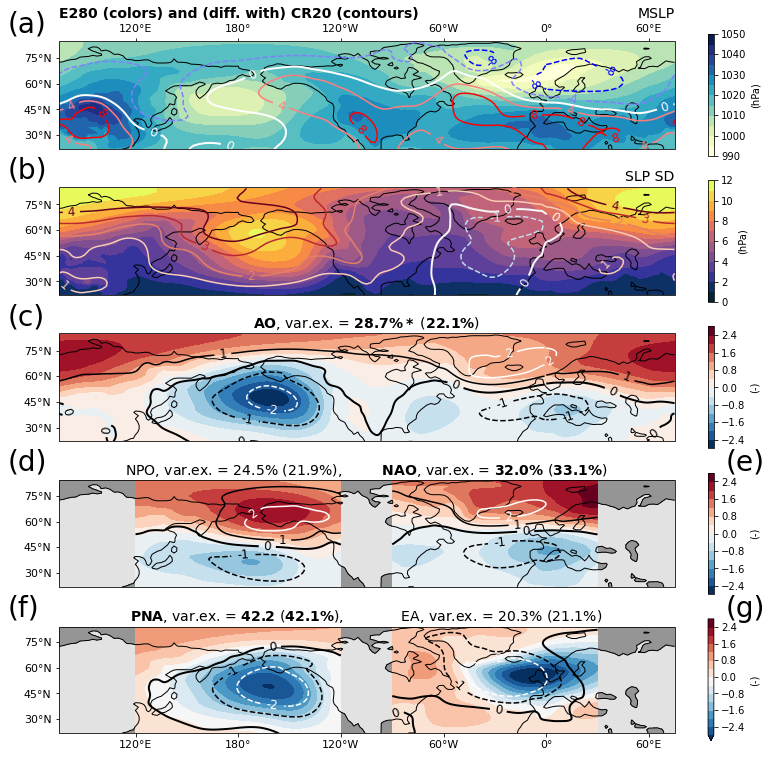

In [623]:
fig = plt.figure(figsize = (12,13), constrained_layout=False)

expN=1;
NH = nh1; SD = sdnh1; eofsh = eofsh1; eofsp = eofsp1; eofsa = eofsa1; expname = 'E280 (pre industrial)';

NH1 = 0.01*nh1.mean("time")
NH1_ = cyclic_array(NH1)

SD_NH1_ = cyclic_array(0.01*sdnh1)

CR_mean = NH_mean_re.interp_like(nh1.mean("time"))
CR_std  = NH_sd_re.interp_like(nh1.std("time"))

meandiff = 0.01*xr.DataArray(gaussian_filter(nh1.mean("time") - CR_mean, sigma=1.5), coords=CR_mean.coords, dims=CR_mean.dims)
sddiff   = 0.01*xr.DataArray(gaussian_filter(nh1.std("time") - CR_std, sigma=1.5),   coords=CR_std.coords,  dims=CR_std.dims)

meandiff_, lon_ = cyclic(meandiff, coord=meandiff.lon); sddiff_, _ = cyclic(sddiff, coord=sddiff.lon);

hatching = 'x';
clon = -105;

##
vmin= 990; vmax = 1050; d = 5; levels = np.arange(vmin, vmax+d, d);
levels2 = np.array([-8, -4, 0, 4, 8]); styles2, lw2 = styles_width(levels2, 1.5);

ax = fig.add_subplot(5,1,1, projection=ccrs.PlateCarree(central_longitude=clon))
c0 = NH1_.plot.contourf(ax=ax, transform = ccrs.PlateCarree(), levels = levels, cmap = 'YlGnBu', cbar_kwargs={'label':'(hPa)', 'fraction':0.03})
ax.contour(lfh.lon, lfh.lat, lfh.sel(exp=expN).landfrac, linewidths = 1., levels=[lfh.sel(exp=expN).clevel], colors = 'k', transform=ccrs.PlateCarree())
c1 = ax.contour(lon_, meandiff.lat, meandiff_, transform = ccrs.PlateCarree(), levels = levels2, cmap='bwr', linestyles = styles2, linewidths = lw2)
c2 = ax.clabel(c1, c1.levels, fontsize=12, inline=True, fmt = '%1.0f')
ax.set_title('MSLP', fontsize=14, loc='right'); ax.set_title('E280 (colors) and (diff. with) CR20 (contours)', fontsize=14, loc='left', fontweight='bold')

lat_ticks(ax); lon_ticks(ax, 'top'); ax.set_extent([75, 285, 22, 85], crs=ccrs.PlateCarree())

ax.text(-210, 90, '(a)', color='k', fontsize = 28)

##
vmin= 0; vmax = 12; d =1; levels = np.arange(vmin, vmax+d, d);
levels2 = np.array([-4, -3, -2, -1, 0, 1, 2, 3, 4]); styles2, lw2 = styles_width(levels2, 1.5);

ax = fig.add_subplot(5,1,2, projection=ccrs.PlateCarree(central_longitude=clon))
SD_NH1_.plot.contourf(ax=ax, transform = ccrs.PlateCarree(), levels=levels, cmap = 'cmo.thermal', cbar_kwargs={'label':'(hPa)', 'fraction':0.03})
ax.contour(lfh.lon, lfh.lat, lfh.sel(exp=expN).landfrac, linewidths = 1., levels=[lfh.sel(exp=expN).clevel], colors = 'k', transform=ccrs.PlateCarree())
c1 = ax.contour(lon_, sddiff.lat, sddiff_, transform = ccrs.PlateCarree(), levels = levels2, cmap='RdBu_r', linestyles = styles2, linewidths = lw2)
c2 = ax.clabel(c1, c1.levels, fontsize=12, inline=True, fmt = '%1.0f')
ax.set_title(''); ax.set_title('SLP SD', fontsize=14, loc='right'); 
lat_ticks(ax); ax.set_extent([75, 285, 22, 85], crs=ccrs.PlateCarree())

ax.text(-210, 90, '(b)', color='k', fontsize = 28)

## Plot SLP EOFS: Northern Hemisphere, North Pacific and North Atlantic

vmin1 = -2.8; vmax1 = 2.8; d = 0.4; levels = np.arange(vmin1, vmax1+d, d);
cmapdiff = 'RdBu_r'

EOFs_ = cyclic_array(eofsh.eofs.isel(mode=0))

ax2 = fig.add_subplot(5,1,3, projection=ccrs.PlateCarree(central_longitude=clon))
EOFs_.plot.contourf(ax=ax2, transform = ccrs.PlateCarree(), levels = levels, cmap = cmapdiff, cbar_kwargs={'label':'(-)', 'fraction':0.03})
ax2.contour(lfh.lon, lfh.lat, lfh.sel(exp=expN).landfrac, linewidths = 1., levels=[lfh.sel(exp=expN).clevel], colors = 'k', transform=ccrs.PlateCarree())
x = eofsh_re.eofs.isel(mode=0); xmap = xr.DataArray(gaussian_filter(x, sigma=1.5), coords=x.coords, dims=x.dims); contourlines(xmap, ax2)
ax2.set_title(fr'$\bf AO$, var.ex. = $\bf{varfs(eofsh.isel(mode=0))}\% *$ ($\bf{varfs(eofsh_re.isel(mode=0))}\%$)', fontsize=14); #ax2.coastlines()

lat_ticks(ax2); ax2.set_extent([75, 285, 22, 85], crs=ccrs.PlateCarree())                                         

ax2.text(-210, 90, '(c)', color='k', fontsize = 28)

## 

ax4 = fig.add_subplot(5,1,4, projection=ccrs.PlateCarree(central_longitude=clon))

(0.2+0*lfh.sel(exp=expN).landfrac).plot.contourf(ax=ax4, transform = ccrs.PlateCarree(), vmin=0, vmax=1, cmap='Greys',  add_colorbar=False)
ax4.contourf(lfh.lon, lfh.lat, lfh.sel(exp=expN).landfrac,  levels=[0, lfh.sel(exp=expN).clevel], cmap='Greys', transform=ccrs.PlateCarree())

eofsp.eofs.isel(mode=1).plot.contourf(ax=ax4, transform = ccrs.PlateCarree(),  levels = levels, cmap = cmapdiff, add_colorbar=False)
eofsa.eofs.isel(mode=0).plot.contourf(ax=ax4, transform = ccrs.PlateCarree(),  levels = levels, cmap = cmapdiff, cbar_kwargs={'label':'(-)', 'fraction':0.03})
ax4.contour(lfh.lon, lfh.lat, lfh.sel(exp=expN).landfrac, linewidths = 1., levels=[lfh.sel(exp=expN).clevel], colors = 'k', transform=ccrs.PlateCarree())

x = eofsp_re.eofs.isel(mode=1); xmap = xr.DataArray(gaussian_filter(x, sigma=1.5), coords=x.coords, dims=x.dims); contourlines(xmap, ax4)
x = eofsa_re.eofs.isel(mode=0); xmap = xr.DataArray(gaussian_filter(x, sigma=1.5), coords=x.coords, dims=x.dims); contourlines(xmap, ax4)

ax4.set_title(fr'NPO, var.ex. = {varfs(eofsp.isel(mode=1))}% ({varfs(eofsp_re.isel(mode=1))}%), {8*chr(0x20)}'
               fr'$\bf NAO$, var.ex. = $\bf{varfs(eofsa.isel(mode=0))}\%$ ($\bf{varfs(eofsa_re.isel(mode=0))}\%$)', fontsize=14); 

lat_ticks(ax4); ax4.set_extent([75, 285, 22, 84], crs=ccrs.PlateCarree())

ax4.text(-210, 90, '(d)', color='k', fontsize = 28)
ax4.text(210, 90, '(e)', color='k', fontsize = 28)

##

ax5 = fig.add_subplot(5,1,5, projection=ccrs.PlateCarree(central_longitude=clon))

(0.2+0*lfh.sel(exp=expN).landfrac).plot.contourf(ax=ax5, transform = ccrs.PlateCarree(), vmin=0, vmax=1, cmap='Greys',  add_colorbar=False)
ax5.contourf(lfh.lon, lfh.lat, lfh.sel(exp=expN).landfrac,  levels=[0, lfh.sel(exp=expN).clevel], cmap='Greys', transform=ccrs.PlateCarree())

(1*eofsp.eofs.isel(mode=0)).plot.contourf(ax=ax5, transform = ccrs.PlateCarree(),  levels = levels, cmap = cmapdiff, add_colorbar=False)
eofsa.eofs.isel(mode=1).plot.contourf(ax=ax5, transform = ccrs.PlateCarree(), levels = levels, cmap = cmapdiff, cbar_kwargs={'label':'(-)', 'fraction':0.03})
ax5.contour(lfh.lon, lfh.lat, lfh.sel(exp=expN).landfrac, linewidths = 1., levels=[lfh.sel(exp=expN).clevel], colors = 'k', transform=ccrs.PlateCarree())

x = eofsp_re.eofs.isel(mode=0); xmap = xr.DataArray(gaussian_filter(x, sigma=1.5), coords=x.coords, dims=x.dims); contourlines(xmap, ax5)
x = eofsa_re.eofs.isel(mode=1); xmap = xr.DataArray(gaussian_filter(x, sigma=1.5), coords=x.coords, dims=x.dims); contourlines(xmap, ax5)

ax5.set_title(fr'$\bf PNA$, var.ex. = $\bf{varfs(eofsp.isel(mode=0))}%$ ($\bf{varfs(eofsp_re.isel(mode=0))}\%$), {12*chr(0x20)}'
               fr'EA, var.ex. = {varfs(eofsa.isel(mode=1))}% ({varfs(eofsa_re.isel(mode=1))}%)', fontsize=14); 

lat_ticks(ax5); lon_ticks(ax5, 'bottom'); ax5.set_extent([75, 285, 22, 84], crs=ccrs.PlateCarree())

ax5.text(-210, 90, '(f)', color='k', fontsize = 28)
ax5.text(210, 90, '(g)', color='k', fontsize = 28)

plt.savefig('200years/figures/revisions/FIGURE1_raw.png', dpi=300)

## Figure 2

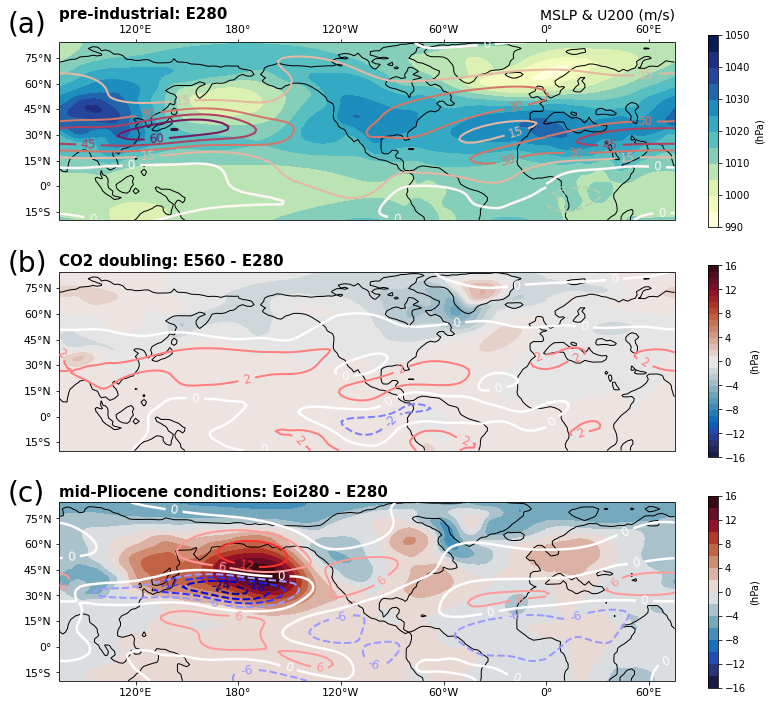

In [613]:

fig = plt.figure(figsize = (12,12), constrained_layout=False)

mslp1 = 0.01*ds1.SLP.sel(lat=slice(-20,85)).mean("time")
mslp2 = 0.01*ds2.SLP.sel(lat=slice(-20,85)).mean("time")
mslp3 = 0.01*ds3.SLP.sel(lat=slice(-20,85)).mean("time")

mslp1_ = cyclic_array(mslp1); mslp1_ = xr.DataArray(gaussian_filter(mslp1_, sigma=1.), coords=mslp1_.coords, dims=mslp1_.dims);
mslp21_ = cyclic_array(mslp2 - mslp1); mslp21_ = xr.DataArray(gaussian_filter(mslp21_, sigma=1.), coords=mslp1_.coords, dims=mslp1_.dims);
mslp31_ = cyclic_array(mslp3 - mslp1); mslp31_ = xr.DataArray(gaussian_filter(mslp31_, sigma=1.), coords=mslp1_.coords, dims=mslp1_.dims);

u200_1 = dsu1.u.sel(plev=200).sel(lat = slice(-20,85)).mean("time")
u200_2 = dsu2.u.sel(plev=200).sel(lat = slice(-20,85)).mean("time")
u200_3 = dsu3.u.sel(plev=200).sel(lat = slice(-20,85)).mean("time")

u200_1_ = cyclic_array(u200_1); u200_1_ = xr.DataArray(gaussian_filter(u200_1_, sigma=1.), coords=mslp1_.coords, dims=mslp1_.dims);
u200_21_ = cyclic_array(u200_2 - u200_1); u200_21_ = xr.DataArray(gaussian_filter(u200_21_, sigma=1.), coords=mslp1_.coords, dims=mslp1_.dims)
u200_31_ = cyclic_array(u200_3 - u200_1); u200_31_ = xr.DataArray(gaussian_filter(u200_31_, sigma=1.), coords=mslp1_.coords, dims=mslp1_.dims)

clon = -105;
    
ax = fig.add_subplot(3,1,1, projection=ccrs.PlateCarree(central_longitude=clon))
vmin = 990; vmax = 1050; d = 5; levels = np.arange(vmin, vmax+d, d);
vmin2 = -75; vmax2 = 75; d = 15; levels2 = np.arange(vmin2, vmax2+d, d); styles2, lw2 = styles_width(levels2, 2);

mslp1_.plot.contourf(ax=ax, transform = ccrs.PlateCarree(),  levels = levels, cmap = 'YlGnBu', cbar_kwargs={'label':'(hPa)', 'fraction':0.03})
ax.contour(lfnh2.lon, lfnh2.lat, lfnh2.sel(exp=1).landfrac, linewidths = 1., levels=[lfnh2.sel(exp=1).clevel], colors = 'k', transform=ccrs.PlateCarree())
c1 = u200_1_.plot.contour(ax=ax, levels = levels2, cmap='cmo.curl', linewidths = lw2, linestyles = styles2, transform=ccrs.PlateCarree(), extend='both', add_colorbar=False)
c2 = ax.clabel(c1, c1.levels, fontsize=12, inline=True, fmt = '%1.0f')

ax.set_title(''); ax.set_title('pre-industrial: E280', fontsize = 15, fontweight = 'bold', loc='left'); 
ax.set_title('MSLP & U200 (m/s)', fontsize = 14, loc='right')
lat_ticks(ax,'NH3'); lon_ticks(ax, 'top'); 
ax.text(-210, 90, '(a)', color='k', fontsize = 28)

ax = fig.add_subplot(3,1,2, projection=ccrs.PlateCarree(central_longitude=clon))
vmin=-16; vmax=16; d=1; levels = np.arange(vmin, vmax+d, d);
levels2 = np.array([-10,-2,0,2,10]); styles2, lw2 = styles_width(levels2, 2);

mslp21_.plot.contourf(ax=ax, transform = ccrs.PlateCarree(), levels = levels, cmap = 'cmo.balance', cbar_kwargs={'label':'(hPa)', 'fraction':0.03})
ax.contour(lfnh2.lon, lfnh2.lat, lfnh2.sel(exp=2).landfrac, linewidths = 1., levels=[lfnh2.sel(exp=2).clevel], colors = 'k', transform=ccrs.PlateCarree())
c1 = u200_21_.plot.contour(ax=ax, levels = levels2, cmap='bwr', linewidths = lw2, linestyles = styles2, transform=ccrs.PlateCarree(), extend='both', add_colorbar=False)
c2 = ax.clabel(c1, c1.levels, fontsize=12, inline=True, fmt = '%1.0f')

ax.set_title(''); ax.set_title('CO2 doubling: E560 - E280', fontsize = 15, fontweight = 'bold', loc='left')
lat_ticks(ax,'NH3'); 
ax.text(-210, 85, '(b)', color='k', fontsize = 28)

ax = fig.add_subplot(3,1,3, projection=ccrs.PlateCarree(central_longitude=clon))
vmin=-16; vmax=16; d=2; levels = np.arange(vmin, vmax+d, d);
vmin2 = -30; vmax2 = 30; d = 6; levels2 = np.arange(vmin2, vmax2+d, d); styles2, lw2 = styles_width(levels2, 2)

mslp31_.plot.contourf(ax=ax, transform = ccrs.PlateCarree(), levels = levels, cmap = 'cmo.balance', cbar_kwargs={'label':'(hPa)', 'fraction':0.03})
ax.contour(lfnh2.lon, lfnh2.lat, lfnh2.sel(exp=3).landfrac, linewidths = 1., levels=[lfnh2.sel(exp=3).clevel], colors = 'k', transform=ccrs.PlateCarree())
c1 = u200_31_.plot.contour(ax=ax, levels = levels2, cmap='seismic', linewidths = lw2, linestyles=styles2, transform=ccrs.PlateCarree(), extend='both', add_colorbar=False)
c2 = ax.clabel(c1, c1.levels, fontsize=12, inline=True, fmt = '%1.0f')

ax.set_title(''); ax.set_title('mid-Pliocene conditions: Eoi280 - E280', fontsize = 15, fontweight = 'bold', loc='left');
lat_ticks(ax,'NH3'); lon_ticks(ax, 'bottom'); 
ax.text(-210, 85, '(c)', color='k', fontsize = 28)


plt.savefig('200years/figures/revisions/FIGURE2_raw.png',dpi=300)

## Figure 3

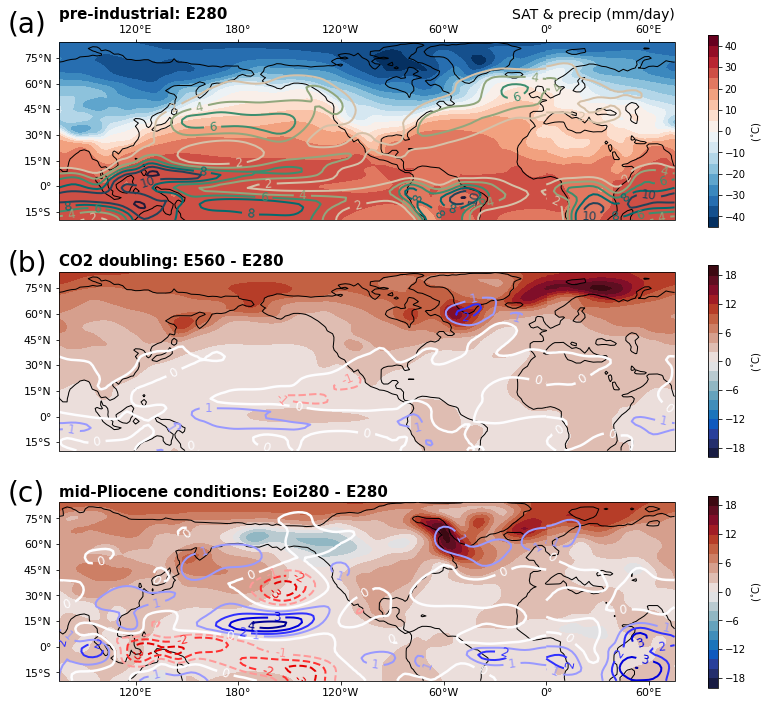

In [58]:

fig = plt.figure(figsize = (12,12), constrained_layout=False)

prect_convert = 24*60*60;

sat1 = ds1.SAT.sel(lat = slice(-20,85)).mean("time")
sat2 = ds2.SAT.sel(lat = slice(-20,85)).mean("time")
sat3 = ds3.SAT.sel(lat = slice(-20,85)).mean("time")

sat1_ = cyclic_array(sat1); sat1_ = xr.DataArray(gaussian_filter(sat1_, sigma=1.), coords=sat1_.coords, dims=sat1_.dims);
sat21_ = cyclic_array(sat2 - sat1); sat21_ = xr.DataArray(gaussian_filter(sat21_, sigma=1.), coords=sat1_.coords, dims=sat1_.dims);
sat31_ = cyclic_array(sat3 - sat1); sat31_ = xr.DataArray(gaussian_filter(sat31_, sigma=1.5), coords=sat1_.coords, dims=sat1_.dims);

prect1 = prect_convert*ds1.prect.sel(lat = slice(-20,85)).mean("time")
prect2 = prect_convert*ds2.prect.sel(lat = slice(-20,85)).mean("time")
prect3 = prect_convert*ds3.prect.sel(lat = slice(-20,85)).mean("time")

prect1_ = cyclic_array(prect1); prect1_ = xr.DataArray(gaussian_filter(prect1_, sigma=1.5), coords=prect1_.coords, dims=prect1_.dims);
prect21_ = cyclic_array(prect2 - prect1); prect21_ = xr.DataArray(gaussian_filter(prect21_, sigma=1.5), coords=prect1_.coords, dims=prect1_.dims);
prect31_ = cyclic_array(prect3 - prect1); prect31_ = xr.DataArray(gaussian_filter(prect31_, sigma=2), coords=prect1_.coords, dims=prect1_.dims);

clon = -105;
    
ax = fig.add_subplot(3,1,1, projection=ccrs.PlateCarree(central_longitude=clon))
vmin = -45; vmax = 45; d = 5; levels = np.arange(vmin, vmax+d, d);
vmin2 = 0; vmax2 = 12; d = 2; levels2 = np.arange(vmin2, vmax2+d, d); styles2, lw2 = styles_width(levels2, 2)

sat1_.plot.contourf(ax=ax, transform = ccrs.PlateCarree(),  levels = levels, cmap = 'RdBu_r', cbar_kwargs={'label':'($^{\circ}$C)', 'fraction':0.03})
ax.contour(lfnh2.lon, lfnh2.lat, lfnh2.sel(exp=1).landfrac, linewidths = 1., levels=[lfnh2.sel(exp=1).clevel], colors = 'k', transform=ccrs.PlateCarree())
c1 = prect1_.plot.contour(ax=ax, levels = levels2, cmap='cmo.rain', linewidths = lw2, linestyles = styles2, transform=ccrs.PlateCarree(), add_colorbar=False)
c2 = ax.clabel(c1, c1.levels, fontsize=12, inline=True, fmt = '%1.0f')

ax.set_title(''); ax.set_title('pre-industrial: E280', fontsize = 15, fontweight = 'bold', loc='left'); 
ax.set_title('SAT & precip (mm/day)', fontsize = 14, loc='right')
lat_ticks(ax,'NH3'); lon_ticks(ax, 'top'); 
ax.text(-210, 90, '(a)', color='k', fontsize = 28)

ax = fig.add_subplot(3,1,2, projection=ccrs.PlateCarree(central_longitude=clon))
vmin=-20; vmax=20; d=2; levels = np.arange(vmin, vmax+d, d);
vmin2 = -5; vmax2 = 5; d = 1; levels2 = np.arange(vmin2, vmax2+d, d); styles2, lw2 = styles_width(levels2, 2)

sat21_.plot.contourf(ax=ax, transform = ccrs.PlateCarree(), levels = levels, cmap = 'cmo.balance', cbar_kwargs={'label':'($^{\circ}$C)', 'fraction':0.03})
ax.contour(lfnh2.lon, lfnh2.lat, lfnh2.sel(exp=2).landfrac, linewidths = 1., levels=[lfnh2.sel(exp=2).clevel], colors = 'k', transform=ccrs.PlateCarree())
c1 = prect21_.plot.contour(ax=ax, levels = levels2, cmap='seismic_r', linewidths = lw2, linestyles = styles2, transform=ccrs.PlateCarree(), extend='both', add_colorbar=False)
c2 = ax.clabel(c1, c1.levels, fontsize=12, inline=True, fmt = '%1.0f')

ax.set_title(''); ax.set_title('CO2 doubling: E560 - E280', fontsize = 15, fontweight = 'bold', loc='left')
lat_ticks(ax,'NH3'); 
ax.text(-210, 85, '(b)', color='k', fontsize = 28)

ax = fig.add_subplot(3,1,3, projection=ccrs.PlateCarree(central_longitude=clon))

sat31_.plot.contourf(ax=ax, transform = ccrs.PlateCarree(), levels = levels, cmap = 'cmo.balance', cbar_kwargs={'label':'($^{\circ}$C)', 'fraction':0.03})
ax.contour(lfnh2.lon, lfnh2.lat, lfnh2.sel(exp=3).landfrac, linewidths = 1., levels=[lfnh2.sel(exp=3).clevel], colors = 'k', transform=ccrs.PlateCarree())
c1 = prect31_.plot.contour(ax=ax, levels = levels2, cmap='seismic_r', linewidths = lw2, linestyles = styles2, transform=ccrs.PlateCarree(), extend='both', add_colorbar=False)
c2 = ax.clabel(c1, c1.levels, fontsize=12, inline=True, fmt = '%1.0f')

ax.set_title(''); ax.set_title('mid-Pliocene conditions: Eoi280 - E280', fontsize = 15, fontweight = 'bold', loc='left');
lat_ticks(ax,'NH3'); lon_ticks(ax, 'bottom'); 
ax.text(-210, 85, '(c)', color='k', fontsize = 28)


plt.savefig('200years/figures/revisions/FIGURE3_raw_v2.png',dpi=300)

## Figure 4

Text(210, 90, '(f)')

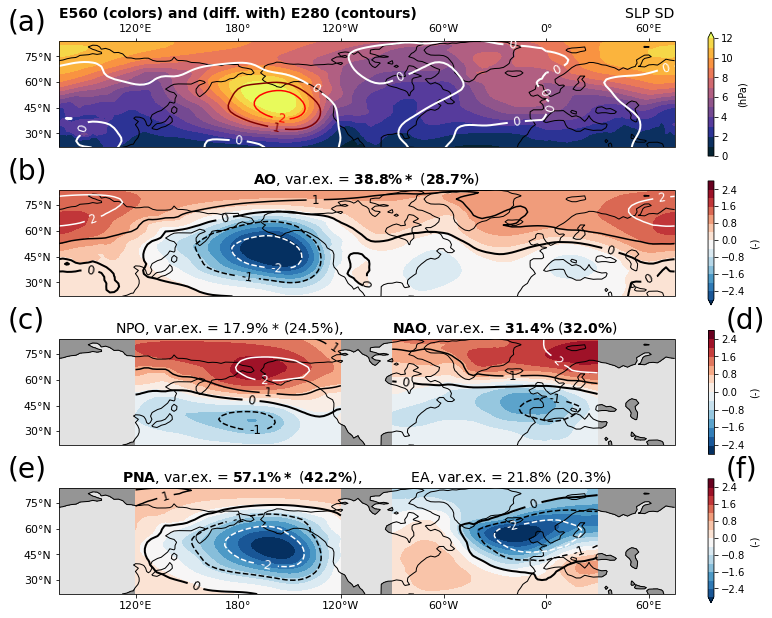

In [652]:
fig = plt.figure(figsize = (12,10.5), constrained_layout=False)

sd1 = 0.01*ds1.SLP.sel(lat=slice(20,85)).std("time"); sd2 = 0.01*ds2.SLP.sel(lat=slice(20,85)).std("time");
sddiff = xr.DataArray(gaussian_filter(sd2-sd1, sigma=1.5), coords=sd2.coords, dims=sd2.dims)
expN = 2; eofsh = eofsh2; eofsp = eofsp2; eofsa = eofsa2; expname = 'E560 (CO2 doubling)';

clon = -105;
    
## 

SD_NH2_ = cyclic_array(sd2)
SD_diff_ = cyclic_array(sddiff)

vmin= 0; vmax = 12; d =1; levels = np.arange(vmin, vmax+d, d);

ax = fig.add_subplot(4,1,1, projection=ccrs.PlateCarree(central_longitude=clon))
SD_NH2_.plot.contourf(ax=ax, transform = ccrs.PlateCarree(), levels = levels, cmap = 'cmo.thermal', cbar_kwargs={'label':'(hPa)', 'fraction':0.03})
ax.contour(lfh.lon, lfh.lat, lfh.sel(exp=expN).landfrac, linewidths = 1., levels=[lfh.sel(exp=expN).clevel], colors = 'k', transform=ccrs.PlateCarree())
c1 = SD_diff_.plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = [0,1,2], colors = ['w', 'maroon', 'r'], linestyles = ['-', '-', '-'], linewidths = [2, 1.5, 1.5])
c2 = ax.clabel(c1, c1.levels, fontsize=12, inline=True, fmt = '%1.0f')
ax.set_title('SLP SD', fontsize=14, loc='right'); ax.set_title('E560 (colors) and (diff. with) E280 (contours)', fontsize=14, loc='left', fontweight='bold')

lat_ticks(ax); lon_ticks(ax, 'top'); ax.set_extent([75, 285, 22, 84], crs=ccrs.PlateCarree())
ax.text(-210, 90, '(a)', color='k', fontsize = 28)
    
## Plot SLP EOFS: Northern Hemisphere, North Pacific and North Atlantic

vmin1 = -2.8; vmax1 = 2.8; d = 0.4; levels = np.arange(vmin1, vmax1+d, d);
cmapdiff = 'RdBu_r'

EOFs_ = cyclic_array(eofsh.eofs.isel(mode=0))
EOFs1_ = cyclic_array(eofsh1.eofs.isel(mode=0))

ax = fig.add_subplot(4,1,2, projection=ccrs.PlateCarree(central_longitude=clon))
EOFs_.plot.contourf(ax=ax, transform = ccrs.PlateCarree(), levels = levels, cmap = cmapdiff, cbar_kwargs={'label':'(-)', 'fraction':0.03})
ax.contour(lfh.lon, lfh.lat, lfh.sel(exp=expN).landfrac, linewidths = 1., levels=[lfh.sel(exp=expN).clevel], colors = 'k', transform=ccrs.PlateCarree())
contourlines(EOFs1_, ax)
ax.set_title(fr'$\bf AO$, var.ex. = $\bf{varfs(eofsh.isel(mode=0))}\% *$ ($\bf{varfs(eofsh1.isel(mode=0))}\%$)', fontsize=14);

lat_ticks(ax); ax.set_extent([75, 285, 22, 84], crs=ccrs.PlateCarree())                                              
ax.text(-210, 90, '(b)', color='k', fontsize = 28)
                                                                                                                                                                                     
##

ax = fig.add_subplot(4,1,3, projection=ccrs.PlateCarree(central_longitude=clon))

(0.2+0*lfh.sel(exp=expN).landfrac).plot.contourf(ax=ax, transform = ccrs.PlateCarree(), vmin=0, vmax=1, cmap='Greys',  add_colorbar=False)
ax.contourf(lfh.lon, lfh.lat, lfh.sel(exp=expN).landfrac,  levels=[0, lfh.sel(exp=expN).clevel], cmap='Greys', transform=ccrs.PlateCarree())
eofsp.eofs.isel(mode=1).plot.contourf(ax=ax, transform = ccrs.PlateCarree(), levels = levels, cmap = cmapdiff, add_colorbar=False)
eofsa.eofs.isel(mode=0).plot.contourf(ax=ax, transform = ccrs.PlateCarree(), levels = levels, cmap = cmapdiff, cbar_kwargs={'label':'(-)', 'fraction':0.03})
ax.contour(lfh.lon, lfh.lat, lfh.sel(exp=expN).landfrac, linewidths = 1., levels=[lfh.sel(exp=expN).clevel], colors = 'k', transform=ccrs.PlateCarree())
contourlines(eofsp1.eofs.isel(mode=1), ax); contourlines(eofsa1.eofs.isel(mode=0), ax);
ax.set_title(fr'NPO, var.ex. = {varfs(eofsp.isel(mode=1))}% * ({varfs(eofsp1.isel(mode=1))}%), {10*chr(0x20)}'
               fr'$\bf NAO$, var.ex. = $\bf{varfs(eofsa.isel(mode=0))}\%$ ($\bf{varfs(eofsa1.isel(mode=0))}\%$)', fontsize=14); 

lat_ticks(ax); ax.set_extent([75, 285, 22, 84], crs=ccrs.PlateCarree())
ax.text(-210, 90, '(c)', color='k', fontsize = 28)
ax.text(210, 90, '(d)', color='k', fontsize = 28)

##

ax = fig.add_subplot(4,1,4, projection=ccrs.PlateCarree(central_longitude=clon))

(0.2+0*lfh.sel(exp=expN).landfrac).plot.contourf(ax=ax, transform = ccrs.PlateCarree(), vmin=0, vmax=1, cmap='Greys',  add_colorbar=False)
ax.contourf(lfh.lon, lfh.lat, lfh.sel(exp=expN).landfrac,  levels=[0, lfh.sel(exp=expN).clevel], cmap='Greys', transform=ccrs.PlateCarree())
(1*eofsp.eofs.isel(mode=0)).plot.contourf(ax=ax, transform = ccrs.PlateCarree(), levels = levels, cmap = cmapdiff, add_colorbar=False)
(1*eofsa.eofs.isel(mode=1)).plot.contourf(ax=ax, transform = ccrs.PlateCarree(), levels = levels, cmap = cmapdiff, cbar_kwargs={'label':'(-)', 'fraction':0.03})
ax.contour(lfh.lon, lfh.lat, lfh.sel(exp=expN).landfrac, linewidths = 1., levels=[lfh.sel(exp=expN).clevel], colors = 'k', transform=ccrs.PlateCarree())
contourlines(eofsp1.eofs.isel(mode=0), ax); contourlines(eofsa1.eofs.isel(mode=1), ax);
ax.set_title(fr'$\bf PNA$, var.ex. = $\bf{varfs(eofsp.isel(mode=0))}\% *$ ($\bf{varfs(eofsp1.isel(mode=0))}\%$), {10*chr(0x20)}'
               fr'EA, var.ex. = {varfs(eofsa.isel(mode=1))}% ({varfs(eofsa1.isel(mode=1))}%)', fontsize=14); 

lat_ticks(ax); lon_ticks(ax, 'bottom'); ax.set_extent([75, 285, 22, 84], crs=ccrs.PlateCarree())
ax.text(-210, 90, '(e)', color='k', fontsize = 28)
ax.text(210, 90, '(f)', color='k', fontsize = 28)

# plt.savefig('200years/figures/revisions/FIGURE4_raw.png', dpi=300)


## Figure 5

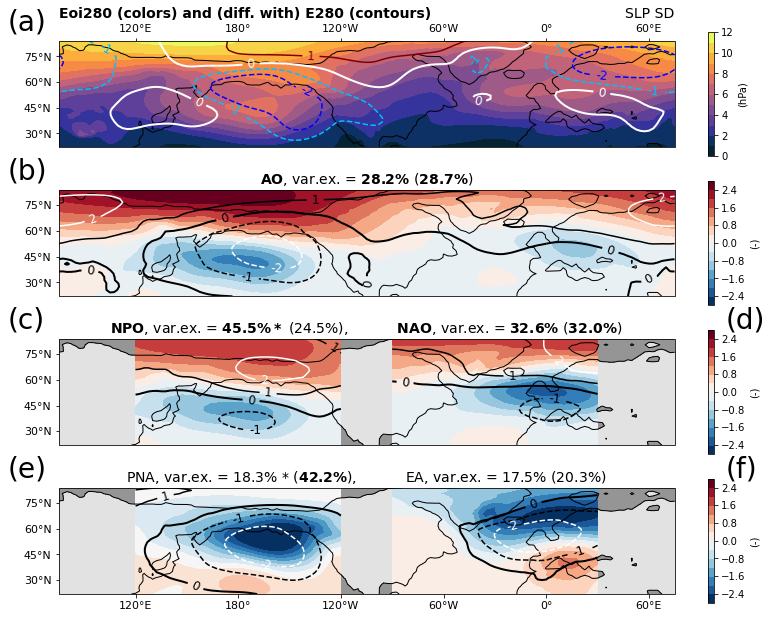

In [616]:
fig = plt.figure(figsize = (12,10.5), constrained_layout=False)

sd1 = 0.01*ds1.SLP.sel(lat=slice(20,85)).std("time"); sd3 = 0.01*ds3.SLP.sel(lat=slice(20,85)).std("time");
sddiff = xr.DataArray(gaussian_filter(sd3-sd1, sigma=2), coords=sd2.coords, dims=sd2.dims)

expN = 3; NH = nh3; SD = sdnh3; eofsh = eofsh3; eofsp = eofsp3; eofsa = eofsa3; expname = 'Eoi280 (mid Pliocene BCs)';

clon = -105;
    
## 

SD_NH3_ = cyclic_array(sd3)
SD_diff_ = cyclic_array(sddiff)

vmin= 0; vmax = 12; d =1; levels = np.arange(vmin, vmax+d, d);

ax = fig.add_subplot(4,1,1, projection=ccrs.PlateCarree(central_longitude=clon))
SD_NH3_.plot.contourf(ax=ax, transform = ccrs.PlateCarree(), levels = levels, cmap = 'cmo.thermal', cbar_kwargs={'label':'(hPa)', 'fraction':0.03})
ax.contour(lfh.lon, lfh.lat, lfh.sel(exp=expN).landfrac, linewidths = 1., levels=[lfh.sel(exp=expN).clevel], colors = 'k', transform=ccrs.PlateCarree())
c1 = SD_diff_.plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = [-2, -1,0,1], colors = ['blue','deepskyblue', 'w', 'maroon'], linestyles = ['--', '--', '-', '-'], linewidths = [1.5, 1.5, 2, 1.5])
c2 = ax.clabel(c1, c1.levels, fontsize=12, inline=True, fmt = '%1.0f')
ax.set_title('SLP SD', fontsize=14, loc='right'); ax.set_title('Eoi280 (colors) and (diff. with) E280 (contours)', fontsize=14, loc='left', fontweight='bold')

lat_ticks(ax); lon_ticks(ax, 'top'); ax.set_extent([75, 285, 22, 84], crs=ccrs.PlateCarree())    
ax.text(-210, 90, '(a)', color='k', fontsize = 28)

## Plot SLP EOFS: Northern Hemisphere, North Pacific and North Atlantic

vmin1 = -2.8; vmax1 = 2.8; d = 0.4; levels = np.arange(vmin1, vmax1+d, d);
cmapdiff = 'RdBu_r'

EOFs_ = cyclic_array(eofsh.eofs.isel(mode=0))
EOFs1_ = cyclic_array(eofsh1.eofs.isel(mode=0))

ax = fig.add_subplot(4,1,2, projection=ccrs.PlateCarree(central_longitude=clon))
EOFs_.plot.contourf(ax=ax, transform = ccrs.PlateCarree(), levels = levels, cmap = cmapdiff, cbar_kwargs={'label':'(-)', 'fraction':0.03})
ax.contour(lfh.lon, lfh.lat, lfh.sel(exp=expN).landfrac, linewidths = 1., levels=[lfh.sel(exp=expN).clevel], colors = 'k', transform=ccrs.PlateCarree())
contourlines(EOFs1_, ax)
ax.set_title(fr'$\bf AO$, var.ex. = $\bf{varfs(eofsh.isel(mode=0))}\%$ ($\bf{varfs(eofsh1.isel(mode=0))}\%$)', fontsize=14);

lat_ticks(ax); ax.set_extent([75, 285, 22, 84], crs=ccrs.PlateCarree())                                              
ax.text(-210, 90, '(b)', color='k', fontsize = 28)
                                                                                                                             
##

ax = fig.add_subplot(4,1,3, projection=ccrs.PlateCarree(central_longitude=clon))

(0.2+0*lfh.sel(exp=expN).landfrac).plot.contourf(ax=ax, transform = ccrs.PlateCarree(), vmin=0, vmax=1, cmap='Greys',  add_colorbar=False)
ax.contourf(lfh.lon, lfh.lat, lfh.sel(exp=expN).landfrac,  levels=[0, lfh.sel(exp=expN).clevel], cmap='Greys', transform=ccrs.PlateCarree())
eofsp.eofs.isel(mode=0).plot.contourf(ax=ax, transform = ccrs.PlateCarree(), levels = levels, cmap = cmapdiff, add_colorbar=False)
eofsa.eofs.isel(mode=0).plot.contourf(ax=ax, transform = ccrs.PlateCarree(), levels = levels, cmap = cmapdiff, cbar_kwargs={'label':'(-)', 'fraction':0.03})
ax.contour(lfh.lon, lfh.lat, lfh.sel(exp=expN).landfrac, linewidths = 1., levels=[lfh.sel(exp=expN).clevel], colors = 'k', transform=ccrs.PlateCarree())
contourlines(eofsp1.eofs.isel(mode=1), ax); contourlines(eofsa1.eofs.isel(mode=0), ax);
ax.set_title(fr'$\bf NPO$, var.ex. = $\bf{varfs(eofsp.isel(mode=0))}\% *$ ({varfs(eofsp1.isel(mode=1))}%), {10*chr(0x20)}'
               fr'$\bf NAO$, var.ex. = $\bf{varfs(eofsa.isel(mode=0))}\%$ ($\bf{varfs(eofsa1.isel(mode=0))}\%$)', fontsize=14); 

lat_ticks(ax); ax.set_extent([75, 285, 22, 84], crs=ccrs.PlateCarree())
ax.text(-210, 90, '(c)', color='k', fontsize = 28)
ax.text(210, 90, '(d)', color='k', fontsize = 28)

##

ax = fig.add_subplot(4,1,4, projection=ccrs.PlateCarree(central_longitude=clon))

(0.2+0*lfh.sel(exp=expN).landfrac).plot.contourf(ax=ax, transform = ccrs.PlateCarree(), vmin=0, vmax=1, cmap='Greys',  add_colorbar=False)
ax.contourf(lfh.lon, lfh.lat, lfh.sel(exp=expN).landfrac,  levels=[0, lfh.sel(exp=expN).clevel], cmap='Greys', transform=ccrs.PlateCarree())
(eofsp.eofs.isel(mode=1)).plot.contourf(ax=ax, transform = ccrs.PlateCarree(), levels = levels, cmap = cmapdiff, add_colorbar=False)
(eofsa.eofs.isel(mode=1)).plot.contourf(ax=ax, transform = ccrs.PlateCarree(), levels = levels, cmap = cmapdiff, cbar_kwargs={'label':'(-)', 'fraction':0.03})
ax.contour(lfh.lon, lfh.lat, lfh.sel(exp=expN).landfrac, linewidths = 1., levels=[lfh.sel(exp=expN).clevel], colors = 'k', transform=ccrs.PlateCarree())
contourlines(eofsp1.eofs.isel(mode=0), ax); contourlines(eofsa1.eofs.isel(mode=1), ax);
ax.set_title(fr'PNA, var.ex. = {varfs(eofsp.isel(mode=1))}% * ($\bf{varfs(eofsp1.isel(mode=0))}\%$), {10*chr(0x20)}'
               fr'EA, var.ex. = {varfs(eofsa.isel(mode=1))}% ({varfs(eofsa1.isel(mode=1))}%)', fontsize=14); 

lat_ticks(ax); lon_ticks(ax, 'bottom'); ax.set_extent([75, 285, 22, 84], crs=ccrs.PlateCarree())
ax.text(-210, 90, '(e)', color='k', fontsize = 28)
ax.text(210, 90, '(f)', color='k', fontsize = 28)

plt.savefig('200years/figures/revisions/FIGURE5_raw.png', dpi=300)

## Figure 6

/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:351: RuntimeWarning: divide by zero encountered in scalar divide
  t_squared = r ** 2 * (dof / ((1.0 - r) * (1.0 + r)))
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:351: RuntimeWarning: divide by zero encountered in scalar divide
  t_squared = r ** 2 * (dof / ((1.0 - r) * (1.0 + r)))
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:351: RuntimeWarning: divide by zero encountered in scalar divide
  t_squared = r ** 2 * (dof / ((1.0 - r) * (1.0 + r)))
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:351: RuntimeWarning: divide by zero encountered in scalar divide
  t_squared = r ** 2 * (dof / ((1.0 - r) * (1.0 + r)))
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:351: RuntimeWarning: divide by zero encountered in scal

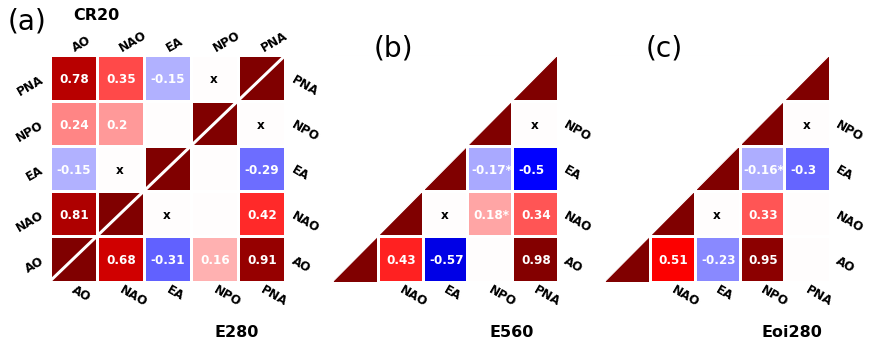

In [53]:
## Correlation between principal components

# make figure
fig = plt.figure(figsize = (12,4.7), constrained_layout=True)
widths = [1.05, 1, 1]; heights = [1];
spec = fig.add_gridspec(ncols=3, nrows=1, width_ratios=widths, height_ratios=heights)

axes = np.arange(0,6,1)

# make subplot
ax = fig.add_subplot(spec[0])

##### E280 and CR20######

pclist = ['AO', 'NAO', 'EA', 'NPO', 'PNA']

eofsh = eofsh_re; eofsp = eofsp_re; eofsa = eofsa_re;
# eofsh = eofsh1; eofsp = eofsp1; eofsa = eofsa1;

varflist_re = np.array([varperc(eofsh,0), varperc(eofsa,0), varperc(eofsa,1), varperc(eofsp,1), varperc(eofsp,0)])
pcs_re =      xr.concat([eofsh.pcs[:,0],  eofsa.pcs[:,0],   eofsa.pcs[:,1],   eofsp.pcs[:,1],   eofsp.pcs[:,0]], dim='mode')

eofsh = eofsh1; eofsp = eofsp1; eofsa = eofsa1;
varflist = np.array([varperc(eofsh,0), varperc(eofsa,0), varperc(eofsa,1), varperc(eofsp,1), varperc(eofsp,0)])
pcs =      xr.concat([eofsh.pcs[:,0],  eofsa.pcs[:,0],   eofsa.pcs[:,1],   eofsp.pcs[:,1],   eofsp.pcs[:,0]], dim='mode')

Npcs = len(pcs.mode)
corrs = np.zeros([Npcs, Npcs]); pvalslist = np.zeros([Npcs, Npcs]);

skiplist = np.arange(0,5)

# set text location
xtext = np.empty([Npcs,1]); ytext = np.empty([Npcs,1]);
for i in range(Npcs): xtext[i] = axes[i] + .2; ytext[i] = axes[i] + .4; 
d_xtext = -.06;

# calculate coeffs
for i in range(Npcs):
    for j in range(Npcs): 
        if j <= skiplist[i]:
            pcs_ = pcs_re;
        else:
            pcs_ = pcs;
        coefs = xs.pearson_r(pcs_[i,:], pcs_[j,:], dim='time')
        pvals = xs.pearson_r_p_value(pcs_[i,:], pcs_[j,:], dim='time')
        corrs[i,j] = coefs*(pvals<0.05)
        pvalslist[i,j] = pvals;
        if abs(coefs)<0.001: ax.text(xtext[j]+0.2, ytext[i], 'x', fontsize = 12, fontweight = 'bold', color = 'k');

# calculate and plot corr coeffs
for i in range(Npcs):
    for j in range(Npcs):
        text = f'{np.round(corrs[i,j],2)}'
        clr = 'k'; fw = 'bold'; d_xt = 0;
        clr = 'w'; fw = 'bold'; d_xt = 0;
        if corrs[i,j]<0: d_xt = d_xt + d_xtext;
        if pvals>0.005: text = text+'*'; d_xt = d_xt + d_xtext;
        if abs(corrs[i,j])>0.01 and corrs[i,j]<0.99: ax.text(xtext[j]+d_xt, ytext[i], text, fontsize = 12, fontweight = fw, color = clr)
            
# plot colors
axes = np.arange(0,Npcs+1,1)
ax.pcolormesh(axes, axes, corrs, vmin=-1, vmax = 1, cmap='seismic')
ax.plot(axes,axes, '-', linewidth=3, color='w')

ax.set_xticks(np.arange(.5,Npcs+0.5,1)); ax.set_xticklabels(pclist, fontsize = 12, fontweight = 'bold');
ax.set_yticks(np.arange(.5,Npcs+0.5,1)); ax.set_yticklabels(pclist, fontsize = 12, fontweight = 'bold');
ax.tick_params(labelbottom=True, labeltop=True, labelleft=True, labelright=True, bottom=False, top=False, left=False, right=False)

plt.setp([tick.label1 for tick in ax.xaxis.get_major_ticks()], rotation=-30, ha="left", va="center", rotation_mode="anchor")
plt.setp([tick.label2 for tick in ax.xaxis.get_major_ticks()], rotation=30, ha="left", va="center", rotation_mode="anchor")

plt.setp([tick.label1 for tick in ax.yaxis.get_major_ticks()], rotation=30, ha="right", va="center", rotation_mode="anchor")
plt.setp([tick.label2 for tick in ax.yaxis.get_major_ticks()], rotation=-30, ha="left", va="center", rotation_mode="anchor")

ax.text(.5, 5.8, 'CR20', fontsize = 16, fontweight = 'bold')
ax.text(3.5, -1.2, 'E280', fontsize = 16, fontweight = 'bold')

ax.text(-0.9, 5.6, '(a)', fontsize = 28)

for spine in ax.spines.values(): spine.set_edgecolor('w')
    
for i in range(Npcs+1):
    ax.plot([0,Npcs], [i,i], 'w', linewidth=3)
    ax.plot([i,i], [0, Npcs], 'w', linewidth=3)

##################################################################################################################

eofsh = eofsh2; eofsp = eofsp2; eofsa = eofsa2;
# elif expN == 3: NH = nh3; SD = sdnh3; eofsh = eofsh3; eofsp = eofsp3; eofsa = eofsa3; niva = niva3;  expname = 'Eoi280 (mid Pliocene BCs)';

varflist = np.array([varperc(eofsh,0), varperc(eofsa,0), varperc(eofsa,1), varperc(eofsp,1), varperc(eofsp,0)])
pcs =      xr.concat([eofsh.pcs[:,0],  eofsa.pcs[:,0],   eofsa.pcs[:,1],   eofsp.pcs[:,1],   eofsp.pcs[:,0]], dim='mode')
corrs = np.zeros([Npcs, Npcs]);

# make subplot
ax = fig.add_subplot(spec[1])

# calculate and plot corr coeffs
for i in range(Npcs):
    for j in range(skiplist[i],Npcs):
        coefs = xs.pearson_r(pcs[i,:], pcs[j,:], dim='time')
        pvals = xs.pearson_r_p_value(pcs[i,:], pcs[j,:], dim='time')
        corrs[i,j] = coefs*(pvals<0.05)
        text = f'{np.round(corrs[i,j],2)}'
        
        clr = 'w'; fw = 'bold'; d_xt = 0;
        if corrs[i,j]<0: d_xt = d_xt + d_xtext;
        if pvals>0.005: text = text+'*'; d_xt = d_xt + d_xtext;
        if abs(corrs[i,j])>0.01 and corrs[i,j]<0.99: ax.text(xtext[j]+d_xt, ytext[i], text, fontsize = 12, fontweight = fw, color = clr)
        if abs(coefs)<0.001: ax.text(xtext[j]+0.2, ytext[i], 'x', fontsize = 12, fontweight = 'bold', color = 'k');


# plot colors
ax.pcolormesh(axes, axes, corrs, vmin=-1, vmax = 1, cmap='seismic')
ax.fill((axes[0], axes[-1], axes[0], axes[0]), (axes[0], axes[-1], axes[-1], axes[0]), color = 'w')

ax.set_xticks(np.arange(1.5,Npcs+0.5,1)); ax.set_xticklabels(pclist[1:], fontsize = 12, fontweight = 'bold');
ax.set_yticks(np.arange(.5,Npcs+0.5,1)); ax.set_yticklabels(pclist[:-1]+[''], fontsize = 12, fontweight = 'bold');
ax.tick_params(labelbottom=True, labeltop=False, labelleft=False, labelright=True, bottom=False, top=False, left=False, right=False)

plt.setp([tick.label1 for tick in ax.xaxis.get_major_ticks()], rotation=-30, ha="left", va="center", rotation_mode="anchor")
plt.setp([tick.label2 for tick in ax.yaxis.get_major_ticks()], rotation=-30, ha="left", va="center", rotation_mode="anchor")

ax.text(3.5, -1.2, 'E560', fontsize = 16, fontweight = 'bold')

ax.text(0.9, 5.0, '(b)', fontsize = 28)

for spine in ax.spines.values(): spine.set_edgecolor('w')
    
for i in range(Npcs+1):
    if i<2: start = 1;
    else: start = i-1;
    ax.plot([start, Npcs], [i,i], 'w' , linewidth=3)
    ax.plot([start, start], [0, start+1], 'w' , linewidth=3)

##################################################################################################################

eofsh = eofsh3; eofsp = eofsp3; eofsa = eofsa3;

varflist = np.array([varperc(eofsh,0), varperc(eofsa,0), varperc(eofsa,1), varperc(eofsp,0), varperc(eofsp,1)])
pcs =      xr.concat([eofsh.pcs[:,0],  eofsa.pcs[:,0],   eofsa.pcs[:,1],   eofsp.pcs[:,0],   eofsp.pcs[:,1]], dim='mode')
corrs = np.zeros([Npcs, Npcs]);

# make subplot
ax = fig.add_subplot(spec[2])

# calculate and plot corr coeffs
for i in range(Npcs):
    for j in range(skiplist[i],Npcs):
        coefs = xs.pearson_r(pcs[i,:], pcs[j,:], dim='time')
        pvals = xs.pearson_r_p_value(pcs[i,:], pcs[j,:], dim='time')
        corrs[i,j] = coefs*(pvals<0.05)
        text = f'{np.round(corrs[i,j],2)}'
        
        clr = 'w'; fw = 'bold'; d_xt = 0;
        if corrs[i,j]<0: d_xt = d_xt + d_xtext;
        if pvals>0.005: text = text+'*'; d_xt = d_xt + d_xtext;
        if abs(corrs[i,j])>0.01 and corrs[i,j]<0.99: ax.text(xtext[j]+d_xt, ytext[i], text, fontsize = 12, fontweight = fw, color = clr)
        if abs(coefs)<0.001: ax.text(xtext[j]+0.2, ytext[i], 'x', fontsize = 12, fontweight = 'bold', color = 'k');

# plot colors
ax.pcolormesh(axes, axes, corrs, vmin=-1, vmax = 1, cmap='seismic')
ax.fill((axes[0], axes[-1], axes[0], axes[0]), (axes[0], axes[-1], axes[-1], axes[0]), color = 'w')
            
ax.set_xticks(np.arange(1.5,Npcs+0.5,1)); ax.set_xticklabels(pclist[1:], fontsize = 12, fontweight = 'bold');
ax.set_yticks(np.arange(.5,Npcs+0.5,1)); ax.set_yticklabels(pclist[:-1]+[''], fontsize = 12, fontweight = 'bold');
ax.tick_params(labelbottom=True, labeltop=False, labelleft=False, labelright=True, bottom=False, top=False, left=False, right=False)

plt.setp([tick.label1 for tick in ax.xaxis.get_major_ticks()], rotation=-30, ha="left", va="center", rotation_mode="anchor")
plt.setp([tick.label2 for tick in ax.yaxis.get_major_ticks()], rotation=-30, ha="left", va="center", rotation_mode="anchor")

ax.text(3.5, -1.2, 'Eoi280', fontsize = 16, fontweight = 'bold')

ax.text(0.9, 5.0, '(c)', fontsize = 28)

for spine in ax.spines.values(): spine.set_edgecolor('w')
    
for i in range(Npcs+1):
    if i<2: start = 1;
    else: start = i-1;
    ax.plot([start, Npcs], [i,i], 'w' , linewidth=3)
    ax.plot([start, start], [0, start+1], 'w' , linewidth=3)

    
#
plt.savefig('200years/figures/revisions/FIGURE6_raw_v2.png', dpi=300)

## Figure 7 

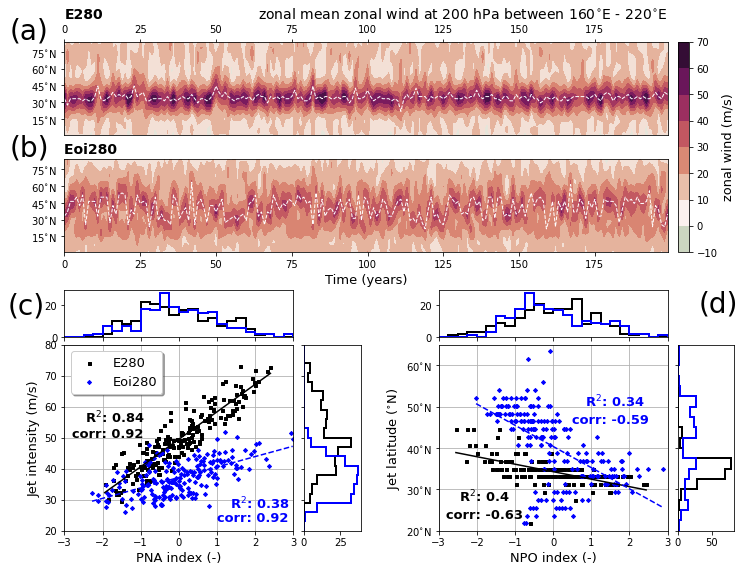

In [618]:
fig = plt.figure(figsize = (12,9), constrained_layout=False)

mP_color = 'blue'

widths = [4, 1, 1, 4, .2, .6]; heights = [2, 0.2, 2, 0.5, 1, 4];
spec = fig.add_gridspec(ncols=6, nrows=6, width_ratios=widths, height_ratios=heights, wspace=0.1, hspace=0.1)

lats=np.array([15,30,45,60,75]); degN = r'$^{\circ}$N';
latlabels = [f'{lats[i]}'+degN for i in range(len(lats))];

lats2=np.array([20, 30, 40, 50, 60]); 
latlabels2 = [f'{lats2[i]}'+degN for i in range(len(lats2))];

vmin=-70; vmax=70; d = 10; levels = np.arange(vmin, vmax+d, d);

ax = fig.add_subplot(spec[0,0:-2])

# pc=ax.pcolormesh(times, u1.lat, u1.T, vmin=-74, vmax=74, cmap='cmo.curl')
ax.contourf(times, u1.lat, u1.T, levels = levels, cmap='cmo.curl')

ax.plot(times, latu1, 'k', linestyle='--', linewidth=1, color='w')
ax.set_yticks(lats); ax.set_yticklabels(latlabels); #ax.set_ylabel('Latitude');
# ax.set_xlabel('Time (years)')
ax.tick_params(labelbottom=False, labeltop=True, labelleft=True, labelright=False, bottom=False, top=True, left=True, right=False)
ax.xaxis.set_label_position("top")
ax.set_title('E280', fontsize=14, loc='left', fontweight='bold')
ax.set_title('zonal mean zonal wind at 200 hPa between 160$^{\circ}$E - 220$^{\circ}$E', fontsize=14, loc='right'); 

ax.text(-18, 87, '(a)', fontsize=28)

ax = fig.add_subplot(spec[2,0:-2])

# ax.pcolormesh(times, u3.lat, u3.T, vmin=-74, vmax=74, cmap='cmo.curl')
ax.contourf(times, u3.lat, u3.T, levels = levels, cmap='cmo.curl')

ax.plot(times, latu3, 'k', linestyle='--', linewidth=1, color='w')
ax.set_yticks(lats); ax.set_yticklabels(latlabels); #ax.set_ylabel('Latitude');
ax.set_xlabel('Time (years)',fontsize=13)
ax.set_title('Eoi280 ', fontsize=14, loc='left', fontweight='bold')

ax.text(-18, 87, '(b)', fontsize=28)

ax = fig.add_subplot(spec[0:3,4:5])

cmap1 = plt.get_cmap('cmo.curl')
bounds = levels[6:]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap1.N)
colors = cmap1(np.linspace((bounds[0] - levels[0])/(levels[-1] - levels[0]), 1, cmap1.N))
cmap1_ = matplotlib.colors.LinearSegmentedColormap.from_list('cmo.curl', colors)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap1_.N)

cbar = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap1_, norm=norm, boundaries = bounds, orientation='vertical'); cbar.set_label('zonal wind (m/s)', fontsize=13); 

#####################################################################################################################################################################

ax = fig.add_subplot(spec[5, 0]); ax_histx = fig.add_subplot(spec[4, 0], sharex=ax); ax_histy = fig.add_subplot(spec[5, 1], sharey=ax);
ax.grid("on"); ax.set_axisbelow(True)
ax.scatter(npaca1, maxu1, color='k', marker = 's', s=9, label='E280')
ax.scatter(npaca3, maxu3, color=mP_color, marker = 'D', s=8, label='Eoi280')

binsx = np.arange(-3, 3.25, 0.25); binsy = np.arange(20, 83, 3)
scatter_hist(npaca1, maxu1, ax_histx, ax_histy, binsx, binsy, 'k')
scatter_hist(npaca3, maxu3, ax_histx, ax_histy, binsx, binsy, mP_color)

ax.set_xlim([-3,3]); ax.set_ylim([20,80]); 
ax.set_ylabel('Jet intensity (m/s)', fontsize=13); ax.set_xlabel('PNA index (-)', fontsize=13)
ax.legend(fontsize=13, shadow=True)

model = np.polyfit(npaca1, maxu1, 1); predict = np.poly1d(model); y1 = predict(npaca1)
rsq = r2_score(maxu1, y1)
x1 = np.array([npaca1.min(), npaca1.max()]); y1 = predict(x1)
ax.plot(x1,y1, 'k-')
ax.text(-2.8, 55, f'   R$^2$: {np.round(rsq,2)}', fontsize=13, fontweight = 'bold', color='k')
ax.text(-2.8, 50, f'corr: {np.round(np.corrcoef(npaca1, maxu1)[0,1],2)}', fontsize=13, fontweight = 'bold', color='k')

ax.text(-4.5, 90, '(c)', fontsize=28)

model = np.polyfit(npaca3, maxu3, 1); predict = np.poly1d(model); y3 = predict(npaca3)
rsq = r2_score(maxu3, y3)
x3 = np.array([npaca3.min(), npaca3.max()]); y3 = predict(x3)
ax.plot(x3,y3, '--', color=mP_color)
ax.text(1, 27, f'   R$^2$: {np.round(rsq,2)}', fontsize=13, fontweight = 'bold', color=mP_color)
ax.text(1, 23, f'corr: {np.round(np.corrcoef(npaca1, maxu1)[0,1],2)}', fontsize=13, fontweight = 'bold', color=mP_color)

####

ax = fig.add_subplot(spec[5, 3]); ax_histx = fig.add_subplot(spec[4, 3], sharex=ax); ax_histy = fig.add_subplot(spec[5, 4:], sharey=ax);
ax.grid("on"); ax.set_axisbelow(True)
ax.scatter(npacz1, latu1, color='k', marker = 's', s=9)
ax.scatter(npacz3, latu3, color=mP_color, marker = 'D', s=8)

binsx = np.arange(-3, 3.25, 0.25); binsy = np.arange(20, 67.5, 2.5)
scatter_hist(npacz1, latu1, ax_histx, ax_histy, binsx, binsy, 'k')
scatter_hist(npacz3, latu3, ax_histx, ax_histy, binsx, binsy, mP_color)

ax.set_xlim([-3,3]); ax.set_ylim([20, 65]); 
ax.set_yticks(lats2); ax.set_yticklabels(latlabels2);
ax.set_ylabel('Jet latitude ($^{\circ}$N)', fontsize=13); ax.set_xlabel('NPO index (-)', fontsize=13)

model = np.polyfit(npacz1, latu1, 1); predict = np.poly1d(model); y1 = predict(npacz1)
rsq = r2_score(latu1, y1)
x1 = np.array([npacz1.min(), npacz1.max()]); y1 = predict(x1)
ax.plot(x1,y1, 'k-'); #ax.text(-2.5, 27, f'R$^2$ = {np.round(rsq,2)}', fontsize=12)
ax.text(-2.8, 27, f'   R$^2$: {np.round(rsq,2)}', fontsize=13, fontweight = 'bold', color='k')
ax.text(-2.8, 23, f'corr: {np.round(np.corrcoef(npacz1, latu1)[0,1],2)}', fontsize=13, fontweight = 'bold', color='k')

model = np.polyfit(npacz3, latu3, 1); predict = np.poly1d(model); y3 = predict(npacz3)
rsq = r2_score(latu3, y3)
x3 = np.array([npacz3.min(), npacz3.max()]); y3 = predict(x3)
ax.plot(x3,y3, '--', color=mP_color); 
ax.text(0.5, 50, f'   R$^2$: {np.round(rsq,2)}', fontsize=13, fontweight = 'bold', color=mP_color)
ax.text(0.5, 46, f'corr: {np.round(np.corrcoef(npacz3, latu3)[0,1],2)}', fontsize=13, fontweight = 'bold', color=mP_color)

ax.text(3.8, 73, '(d)', fontsize=28)

plt.savefig('200years/figures/revisions/FIGURE7_raw.png', dpi=300)


## Figure 8

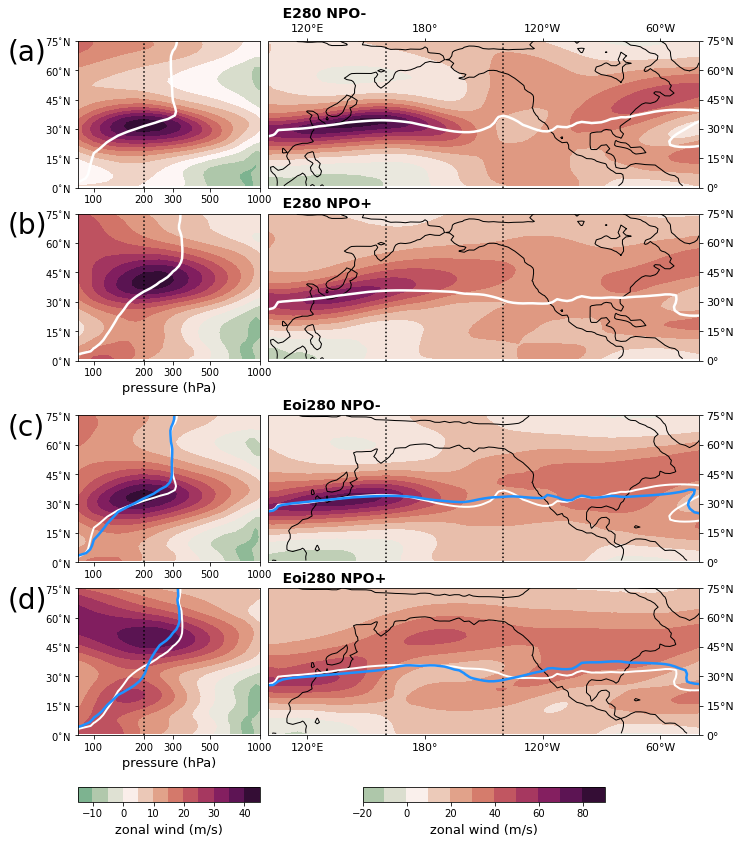

In [619]:
fig = plt.figure(figsize = (12,14), constrained_layout=False)

vmin=-90; vmax=90; d=10; levels = np.arange(vmin, vmax+d, d);
vmin2=-45; vmax2=45; d = 5; levels2 = np.arange(vmin2, vmax2+d, d);
cmap = 'cmo.curl';

widths = [0.3, 0.3, 0.4, 0.3]; heights = [1, 1, 0.02, 1, 1, 0.0, 0.1];
spec = fig.add_gridspec(ncols=4, nrows=7, width_ratios=widths, height_ratios=heights, wspace=-0.2, hspace=0.3)

clon = -105;

lats=np.array([0, 15, 30, 45, 60, 75]); degN = r'$^{\circ}$N';
latlabels = [f'{lats[i]}'+degN for i in range(len(lats))];

levs=np.array([1000, 500, 300, 200, 100]);
levlabels = [f'{levs[i]}' for i in range(len(levs))];

l1 = 100; l2 = 320;
lonslice = np.array([160, 220]);

ax = fig.add_subplot(spec[0,1:], projection=ccrs.PlateCarree(central_longitude=clon))

u1_min.sel(plev=200).sel(lon=slice(l1,l2)).plot.contourf(ax=ax, transform = ccrs.PlateCarree(), levels=levels, cmap = cmap, add_colorbar=False   )
ax.contour(lfnh.sel(lon=slice(l1,l2)).lon, lfnh.lat, lfnh.sel(lon=slice(l1,l2)).sel(exp=1).landfrac, linewidths = 1., levels=[lfnh.sel(exp=3).clevel], colors = 'k', transform=ccrs.PlateCarree())
ax.plot([lonslice[0], lonslice[0]],[0,75], 'k:', transform = ccrs.PlateCarree(),zorder=1); ax.plot([lonslice[1], lonslice[1]],[0,85], 'k:', transform = ccrs.PlateCarree(),zorder=1)
pv1_min.sel(plev=200).sel(lon=slice(l1,l2)).plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = [2], colors = 'w', linestyles = '-', linewidths=2.5)
ax.set_extent([l1, l2, 0, 75], crs=ccrs.PlateCarree())
ax.set_title('   E280 NPO-', loc='left', fontsize=14, fontweight='bold'); ax.set_title('')

lat_ticks(ax,'NH2');  ax.yaxis.tick_right(); lon_ticks(ax, 'top', lons=[120,180, -120, -60])

ax=fig.add_subplot(spec[0,0])

u1_min.sel(lon=slice(lonslice[0], lonslice[1])).mean("lon").T.plot.contourf(ax=ax, levels=levels2, cmap=cmap, add_colorbar=False)
ax.plot([200,200], [0,75],'k:',zorder=1)
pv1_min.sel(lon=slice(lonslice[0], lonslice[1])).mean("lon").T.plot.contour(ax=ax, levels = [2], colors = 'w', linestyles = '-', linewidths=2.5)
ax.set_xlim([80, 1000]); ax.set_ylim([0,75])
ax.set_xscale("log"); ax.minorticks_off();
ax.set_yticks(lats); ax.set_yticklabels(latlabels); ax.set_ylabel('');
ax.set_xticks(levs); ax.set_xticklabels(levlabels); ax.set_xlabel('');
ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, bottom=True, top=False, left=True, right=False)

ax.text(30, 65, '(a)', fontsize = 28)

####################################################################################################################################

ax = fig.add_subplot(spec[1,1:], projection=ccrs.PlateCarree(central_longitude=clon))

u1_plus.sel(plev=200).sel(lon=slice(l1,l2)).plot.contourf(ax=ax, transform = ccrs.PlateCarree(), levels=levels, cmap = cmap, add_colorbar=False   )
ax.contour(lfnh.sel(lon=slice(l1,l2)).lon, lfnh.lat, lfnh.sel(lon=slice(l1,l2)).sel(exp=1).landfrac, linewidths = 1., levels=[lfnh.sel(exp=3).clevel], colors = 'k', transform=ccrs.PlateCarree())
ax.plot([lonslice[0], lonslice[0]],[0,75], 'k:', transform = ccrs.PlateCarree(),zorder=1); ax.plot([lonslice[1], lonslice[1]],[0,85], 'k:', transform = ccrs.PlateCarree(),zorder=1)
pv1_plus.sel(plev=200).sel(lon=slice(l1,l2)).plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = [2], colors = 'w', linestyles = '-', linewidths=2.5)
ax.set_extent([l1, l2, 0, 75], crs=ccrs.PlateCarree())
ax.set_title('   E280 NPO+', loc='left', fontsize=14, fontweight='bold'); ax.set_title('')

lat_ticks(ax,'NH2');  ax.yaxis.tick_right(); 

ax=fig.add_subplot(spec[1,0])

u1_plus.sel(lon=slice(lonslice[0], lonslice[1])).mean("lon").T.plot.contourf(ax=ax, levels=levels2, cmap=cmap, add_colorbar=False)
ax.plot([200,200], [0,75],'k:',zorder=1)
pv1_plus.sel(lon=slice(lonslice[0], lonslice[1])).mean("lon").T.plot.contour(ax=ax, levels = [2], colors = 'w', linestyles = '-', linewidths=2.5)
ax.set_xlim([80, 1000]); ax.set_ylim([0,75]);
ax.set_xscale("log"); ax.minorticks_off();
ax.set_yticks(lats); ax.set_yticklabels(latlabels); ax.set_ylabel('');
ax.set_xticks(levs); ax.set_xticklabels(levlabels); ax.set_xlabel('pressure (hPa)', fontsize=13);
ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, bottom=True, top=False, left=True, right=False)

ax.text(30, 65, '(b)', fontsize = 28)

####################################################################################################################################

ax = fig.add_subplot(spec[3,1:], projection=ccrs.PlateCarree(central_longitude=clon))

u3_min.sel(plev=200).sel(lon=slice(l1,l2)).plot.contourf(ax=ax, transform = ccrs.PlateCarree(), levels=levels, cmap = cmap, add_colorbar=False   )
ax.contour(lfnh.sel(lon=slice(l1,l2)).lon, lfnh.sel(lat=slice(0,75)).lat, lfnh.sel(lon=slice(l1,l2), lat=slice(0,75)).sel(exp=3).landfrac, linewidths = 1., levels=[lfnh.sel(exp=3).clevel], colors = 'k', transform=ccrs.PlateCarree())
ax.plot([lonslice[0], lonslice[0]],[0,75], 'k:', transform = ccrs.PlateCarree(),zorder=1); ax.plot([lonslice[1], lonslice[1]],[0,75], 'k:', transform = ccrs.PlateCarree(),zorder=1)
pv1_min.sel(plev=200).sel(lon=slice(l1,l2)).plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = [2], colors = 'w', linestyles = '-', linewidths=2)
pv3_min.sel(plev=200).sel(lon=slice(l1,l2)).plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = [2], colors = 'dodgerblue', linestyles = '-', linewidths=2.5)
ax.set_extent([l1, l2, 0, 75], crs=ccrs.PlateCarree())
ax.set_title('   Eoi280 NPO-', loc='left', fontsize=14, fontweight='bold'); ax.set_title('')

lat_ticks(ax,'NH2');  ax.yaxis.tick_right(); 

ax=fig.add_subplot(spec[3,0])

u3_min.sel(lon=slice(lonslice[0], lonslice[1])).mean("lon").T.plot.contourf(ax=ax, levels=levels2, cmap=cmap, add_colorbar=False)
ax.plot([200,200], [0,75],'k:',zorder=1)
pv1_min.sel(lon=slice(lonslice[0], lonslice[1])).mean("lon").T.plot.contour(ax=ax, levels = [2], colors = 'w', linestyles = '-', linewidths=2)
pv3_min.sel(lon=slice(lonslice[0], lonslice[1])).mean("lon").T.plot.contour(ax=ax, levels = [2], colors = 'dodgerblue', linestyles = '-', linewidths=2.5)
ax.set_xlim([80, 1000]); ax.set_ylim([0,75]);
ax.set_xscale("log"); ax.minorticks_off();
ax.set_yticks(lats); ax.set_yticklabels(latlabels); ax.set_ylabel('');
ax.set_xticks(levs); ax.set_xticklabels(levlabels); ax.set_xlabel('');
ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, bottom=True, top=False, left=True, right=False)

ax.text(30, 65, '(c)', fontsize = 28)

####################################################################################################################################

ax = fig.add_subplot(spec[4,1:], projection=ccrs.PlateCarree(central_longitude=clon))

u3_plus.sel(plev=200).sel(lon=slice(l1,l2)).plot.contourf(ax=ax, transform = ccrs.PlateCarree(), levels=levels, cmap = cmap, add_colorbar=False   )
ax.contour(lfnh.sel(lon=slice(l1,l2)).lon, lfnh.lat, lfnh.sel(lon=slice(l1,l2)).sel(exp=3).landfrac, linewidths = 1., levels=[lfnh.sel(exp=3).clevel], colors = 'k', transform=ccrs.PlateCarree())
ax.plot([lonslice[0], lonslice[0]],[0,75], 'k:', transform = ccrs.PlateCarree(),zorder=1); ax.plot([lonslice[1], lonslice[1]],[0,85], 'k:', transform = ccrs.PlateCarree(),zorder=1)
pv1_plus.sel(plev=200).sel(lon=slice(l1,l2)).plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = [2], colors = 'w', linestyles = '-', linewidths=2)
pv3_plus.sel(plev=200).sel(lon=slice(l1,l2)).plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = [2], colors = 'dodgerblue', linestyles = '-', linewidths=2.5)
ax.set_extent([l1, l2, 0, 75], crs=ccrs.PlateCarree())
ax.set_title('   Eoi280 NPO+', loc='left', fontsize=14, fontweight='bold'); ax.set_title('')

lat_ticks(ax,'NH2'); ax.yaxis.tick_right(); lon_ticks(ax, 'bottom', lons=[120,180, -120, -60])

ax=fig.add_subplot(spec[4,0])

u3_plus.sel(lon=slice(lonslice[0], lonslice[1])).mean("lon").T.plot.contourf(ax=ax, levels=levels2, cmap=cmap, add_colorbar=False)
ax.plot([200,200], [0,75],'k:',zorder=1)
pv1_plus.sel(lon=slice(lonslice[0], lonslice[1])).mean("lon").T.plot.contour(ax=ax, levels = [2], colors = 'w', linestyles = '-', linewidths=2)
pv3_plus.sel(lon=slice(lonslice[0], lonslice[1])).mean("lon").T.plot.contour(ax=ax, levels = [2], colors = 'dodgerblue', linestyles = '-', linewidths=2.5)
ax.set_xlim([80, 1000]); ax.set_ylim([0,75])
ax.set_xscale("log"); ax.minorticks_off();
ax.set_yticks(lats); ax.set_yticklabels(latlabels); ax.set_ylabel('');
ax.set_xticks(levs); ax.set_xticklabels(levlabels); ax.set_xlabel('pressure (hPa)', fontsize=13);
ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, bottom=True, top=False, left=True, right=False)

ax.text(30, 65, '(d)', fontsize = 28)

ax = fig.add_subplot(spec[6,0])

cmap1 = plt.get_cmap('cmo.curl')
bounds = levels2[6:]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap1.N)
colors = cmap1(np.linspace((bounds[0] - levels2[0])/(levels2[-1] - levels2[0]), 1, cmap1.N))
cmap1_ = matplotlib.colors.LinearSegmentedColormap.from_list('cmo.curl', colors)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap1_.N)

cbar = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap1_, norm=norm, boundaries = bounds, orientation='horizontal'); cbar.set_label('zonal wind (m/s)', fontsize=13); 

ax = fig.add_subplot(spec[6,2])

cmap1 = plt.get_cmap('cmo.curl')
bounds = levels[7:]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap1.N)
colors = cmap1(np.linspace((bounds[0] - levels[0])/(levels[-1] - levels[0]), 1, cmap1.N))
cmap1_ = matplotlib.colors.LinearSegmentedColormap.from_list('cmo.curl', colors)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap1_.N)

cbar = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap1_, norm=norm, boundaries = bounds, orientation='horizontal'); cbar.set_label('zonal wind (m/s)', fontsize=13); 


# plt.savefig('200years/figures/FIGURE9_raw.pdf')
plt.savefig('200years/figures/revisions/FIGURE8_raw.png', dpi=300)



## Figure 9

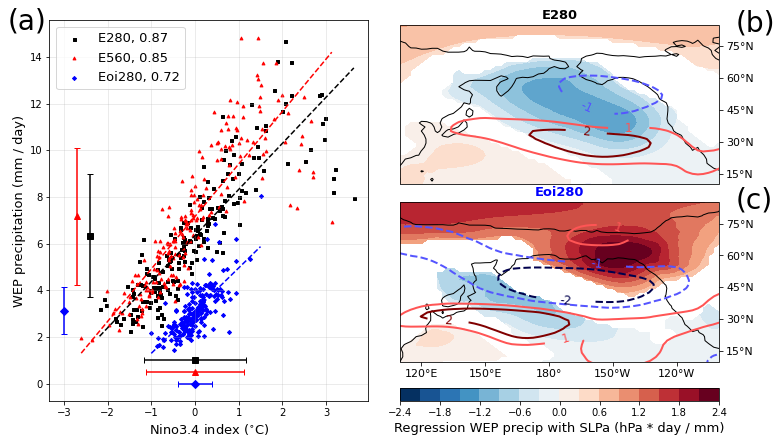

In [648]:

prect_convert = 24*60*60;


fig = plt.figure(figsize = (12,7))

widths = [1, 1]; heights = [4, 4, .1, .3]
spec = fig.add_gridspec(ncols=2, nrows=4, width_ratios=widths, height_ratios=heights, wspace=0.1, hspace=0.1)

########################################################################################################################################

ax = fig.add_subplot(spec[:,0])


x1 = nino1; y1 = prect_convert*prect1_wep;
model = np.polyfit(x1, y1, 1); predict = np.poly1d(model); 
x1_ = np.array([x1.min(), x1.max()]); y1_ = predict(x1_)
ax.plot(x1_, y1_, 'k--');

x2 = nino2; y2 = prect_convert*prect2_wep;
model = np.polyfit(x2, y2, 1); predict = np.poly1d(model); 
x2_ = np.array([x2.min(), x2.max()]); y2_ = predict(x2_)
ax.plot(x2_, y2_, 'r--');

x3 = nino3; y3 = prect_convert*prect3_wep;
model = np.polyfit(x3, y3, 1); predict = np.poly1d(model); 
x3_ = np.array([x3.min(), x3.max()]); y3_ = predict(x3_)
ax.plot(x3_, y3_, 'b--');

corr1 = xs.pearson_r(x1, y1, "time")
corr2 = xs.pearson_r(x2, y2, "time")
corr3 = xs.pearson_r(x3, y3, "time")

ax.scatter(x1, y1, s=9, color='k', marker = 's', label = f'E280, {np.round(corr1.values,2)}')
ax.scatter(x2, y2, s=8, color='r', marker = '^', label = f'E560, {np.round(corr2.values,2)}')
ax.scatter(x3, y3, s=8, color='b', marker = 'D', label = f'Eoi280, {np.round(corr3.values,2)}')

ax.errorbar(0, 1.0, xerr = x1.std(), color = 'k', marker='s', capsize=3)
ax.errorbar(0, 0.5, xerr = x2.std(), color = 'r', marker='^', capsize=3)
ax.errorbar(0, 0.0, xerr = x3.std(), color = 'b', marker='D', capsize=3)

ax.errorbar(-2.4, y1.mean(), yerr = y1.std(), color = 'k', marker='s', capsize=3)
ax.errorbar(-2.7, y2.mean(), yerr = y2.std(), color = 'r', marker='^', capsize=3)
ax.errorbar(-3.0, y3.mean(), yerr = y3.std(), color = 'b', marker='D', capsize=3)


ax.set_xlabel('Nino3.4 index ($^{\circ}$C)', fontsize=13)
ax.set_ylabel(r'WEP precipitation (mm / day)', fontsize=13)

ax.grid(alpha=0.3)

ax.legend(fontsize=13)
ax.text(-4.3, 15.2, '(a)', color='k', fontsize = 28)


########################################################################################################################################

# vmin2 = -3; vmax2 = 3; d = 1; levels2 = np.arange(vmin2, vmax2+d, d);
levels2 = np.array([ -2, -1, 1, 2]); styles2, lw2 = styles_width(levels2, 2)
cmap2 = 'seismic'

x = prect_convert*prect1_wep
y = 1e-2*ds1.SLP
y2 = dsp1.u.sel(plev=200)

corrs = xs.linslope(x,y, "time"); pvals = xs.pearson_r_p_value(x,y, "time"); 
corrs2 = xs.linslope(x,y2, "time"); pvals2 = xs.pearson_r_p_value(x,y2, "time"); 

ax = fig.add_subplot(spec[0,1], projection=ccrs.PlateCarree(central_longitude = -105))

fill = corrs.where(pvals<0.05).plot.contourf(ax=ax, levels = 17, vmin=-2.4, vmax=2.4,
                                      cmap=plt.cm.RdBu_r, transform=ccrs.PlateCarree(), extend='both',add_colorbar=False)
ax.contour(lfnh.lon, lfnh.lat, lfnh.sel(exp=1).landfrac, linewidths = 1., levels=[lfnh.sel(exp=1).clevel], colors = 'k', transform=ccrs.PlateCarree())
c1 = corrs2.plot.contour(ax=ax, levels=levels2, cmap=cmap2, linewidths = lw2, linestyles = styles2, transform=ccrs.PlateCarree())
c2 = ax.clabel(c1, c1.levels, fontsize=12, inline=True, fmt = '%1.0f')

lat_ticks(ax,'NH2'); ax.yaxis.tick_right();
ax.text(13, 82, '(b)', color='k', fontsize = 28)

ax.set_extent([110, 260, 10, 85], crs=ccrs.PlateCarree())
# plt.colorbar(fill, ax=ax, orientation='horizontal')
ax.set_title('E280', fontsize=13, color = 'k', fontweight='bold')

x = prect_convert*prect3_wep
y = 1e-2*ds3.SLP
y2 = dsp3.u.sel(plev=200);

corrs = xs.linslope(x,y, "time"); pvals = xs.pearson_r_p_value(x,y, "time"); 
corrs2 = xs.linslope(x,y2, "time"); pvals2 = xs.pearson_r_p_value(x,y2, "time"); 

ax = fig.add_subplot(spec[1,1], projection=ccrs.PlateCarree(central_longitude = -105))

fill = corrs.where(pvals<0.05).plot.contourf(ax=ax, levels = 17, vmin=-2.4, vmax=2.4,
                                      cmap=plt.cm.RdBu_r, transform=ccrs.PlateCarree(), extend='both',add_colorbar=False)
ax.contour(lfnh.lon, lfnh.lat, lfnh.sel(exp=3).landfrac, linewidths = 1., levels=[lfnh.sel(exp=3).clevel], colors = 'k', transform=ccrs.PlateCarree())
c1 = corrs2.plot.contour(ax=ax, levels=levels2, cmap = cmap2, linewidths = lw2, linestyles = styles2, transform=ccrs.PlateCarree())
c2 = ax.clabel(c1, c1.levels, fontsize=12, inline=True, fmt = '%1.0f')

lat_ticks(ax,'NH2'); ax.yaxis.tick_right(); lon_ticks(ax, 'bottom', lons=[120, 150, 180, -150, -120])

ax.text(13, 82, '(c)', color='k', fontsize = 28)

ax.set_extent([110, 260, 10, 85], crs=ccrs.PlateCarree())
ax.set_title('Eoi280', fontsize=13, color = 'b', fontweight='bold')

ax = fig.add_subplot(spec[3,1])
# plt.colorbar(fill, ax=ax, orientation='horizontal')
cmap=plt.cm.RdBu_r
bounds = np.linspace(-2.4,2.4,17)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cbar = matplotlib.colorbar.ColorbarBase(ax, cmap=plt.cm.RdBu_r, norm=norm, orientation='horizontal'); 
cbar.set_label('Regression WEP precip with SLPa (hPa * day / mm)', fontsize=13); 

# plt.savefig('200years/figures/revisions/FIGURE9_raw.png', dpi=300)


# SUPPLEMENTARY MATERIAL

In [871]:

from matplotlib.patches import Rectangle
import scipy.io

mat = scipy.io.loadmat('spinup/Rad_Tseries_yearly.mat')
e280_T=mat["Tm"];       e280_T=e280_T[0:340];
e280_time=mat["years"]; e280_time=e280_time[0:340];

d1 = xr.open_dataset('spinup/E280p_Atmosphere_years_2500-4000.nc').temp
d2 = xr.open_dataset('spinup/E280p_Atmosphere_years_4001-4250.nc').temp
d3 = xr.open_dataset('spinup/E280p_Atmosphere_years_4251-4500.nc').temp
d4 = xr.open_dataset('spinup/E280p_Atmosphere_years_4501-4715.nc').temp
d5 = xr.open_dataset('spinup/E280p_Atmosphere_years_4716-4800.nc').temp
d6 = xr.open_dataset('spinup/E280p_Atmosphere_years_4801-5000.nc').temp
d7 = xr.open_dataset('spinup/E280p_Atmosphere_years_5001-5500.nc').temp
d8 = xr.open_dataset('spinup/E280p_Atmosphere_years_5501-6000.nc').temp
d9 = xr.open_dataset('spinup/E280p_Atmosphere_years_6001-6500.nc').temp
e280p = xr.concat([d1,d2,d3,d4,d5,d6,d7,d8,d9], dim="time")

d1 = xr.open_dataset('spinup/E560_Atmosphere_years_3300-3535.nc').temp
d2 = xr.open_dataset('spinup/E560_Atmosphere_years_3536-4060.nc').temp
e560 = xr.concat([d1,d2], dim="time")

d1 = xr.open_dataset('spinup/E560p_Atmosphere_years_5001-5100.nc').temp
d2 = xr.open_dataset('spinup/E560p_Atmosphere_years_5101-5500.nc').temp
d3 = xr.open_dataset('spinup/E560p_Atmosphere_years_5501-6000.nc').temp
d4 = xr.open_dataset('spinup/E560p_Atmosphere_years_6001-6500.nc').temp
e560p = xr.concat([d1,d2,d3,d4], dim="time")

d1 = xr.open_dataset('spinup/Eoi400_Atmosphere_years_1-500.nc').temp
d2 = xr.open_dataset('spinup/Eoi400_Atmosphere_years_501-1000.nc').temp
d3 = xr.open_dataset('spinup/Eoi400_Atmosphere_years_1001-1500.nc').temp
d4 = xr.open_dataset('spinup/Eoi400_Atmosphere_years_1501-2000.nc').temp
eoi400 = xr.concat([d1,d2,d3,d4], dim="time")[2:]

d1 = xr.open_dataset('spinup/Eoi280_Atmosphere_years_2001-2285.nc').temp
d2 = xr.open_dataset('spinup/Eoi280_Atmosphere_years_2251-2500.nc').temp
d3 = xr.open_dataset('spinup/Eoi280_Atmosphere_years_2501-2750.nc').temp
d4 = xr.open_dataset('spinup/Eoi280_Atmosphere_years_2751-3000.nc').temp
eoi280 = xr.concat([d1,d2,d3,d4], dim="time")

## FIGURE S1

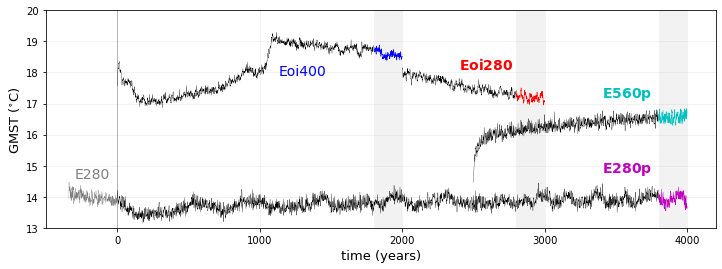

In [872]:
lw1 = 0.3; lw = 0.5;

fig,ax=plt.subplots(figsize=(12,4))

ax.plot(np.arange(-340,0), e280_T,label='E280', color='gray', linewidth=lw1)
ax.plot(np.arange(0,3801), e280p[0:-200], color='k', linewidth=lw1)
ax.plot(np.arange(3801,4001), e280p[-200:], color='m', linewidth=lw)
ax.plot(np.arange(2501,3801), e560p[0:-200], color='k', linewidth=lw1)
ax.plot(np.arange(3801,4001), e560p[-200:], color='c', linewidth=lw)

eoi400[0:-200].plot(color='k', linewidth=lw1)
eoi400[-200:].plot(color='b', linewidth=lw)
eoi280[0:-200].plot(color='k', linewidth=lw1)
eoi280[-200:].plot(color='r', linewidth=lw)

ax.set_ylim([13,20])
ax.set_xlim([-500,4200])
ax.grid("on", alpha=0.2)
ax.plot([0,0],[13,20],'k-', alpha=0.5, linewidth=0.5)

ax.add_patch(Rectangle((1800,13),200,7,linewidth=1,edgecolor='none',facecolor='gray',alpha=0.1,zorder=-1))
ax.add_patch(Rectangle((2800,13),200,7,linewidth=1,edgecolor='none',facecolor='gray',alpha=0.1,zorder=-1))
ax.add_patch(Rectangle((3800,13),200,7,linewidth=1,edgecolor='none',facecolor='gray',alpha=0.1,zorder=-1))

ax.text(-300, 14.6, 'E280', fontsize=14, color='gray')
ax.text(1130, 17.9, 'Eoi400', fontsize=14, color='b')
ax.text(2400, 18.1, r'$\bfEoi280$', fontsize=14, color='r')
ax.text(3400, 14.8, r'$\bfE280p$', fontsize=14, color='m')
ax.text(3400, 17.2, r'$\bfE560p$', fontsize=14, color='c')

# ax.legend(fontsize=13, bbox_to_anchor=(0.7, 0.95), shadow=True)

ax.set_ylabel(r'GMST ($^{\circ}$C)', fontsize=13); ax.set_xlabel('time (years)', fontsize=13)

# plt.savefig('spinup/spin_up1.pdf',dpi=500)
plt.savefig('200years/figures/revisions/FIGURES1_raw.png',dpi=300)

## FIGURE S2

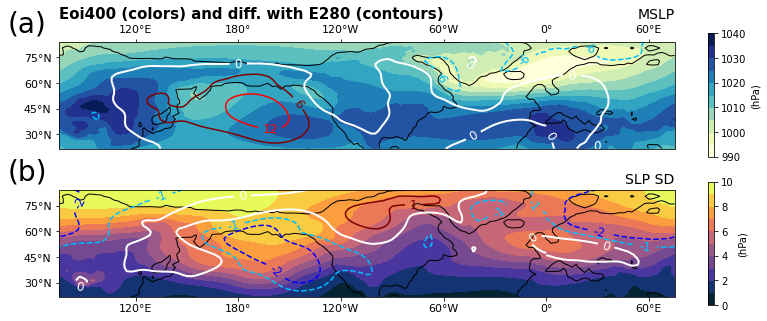

In [873]:
fig = plt.figure(figsize = (12,5), constrained_layout=False)

mslp1 = cyclic_array(0.01*ds1.SLP.sel(lat=slice(20,85)).mean("time"))
mslp4 = cyclic_array(0.01*ds4.SLP.sel(lat=slice(20,85)).mean("time"))

filtered = gaussian_filter(mslp4 - mslp1, sigma=1)
mslp_diff = xr.DataArray(filtered, coords=mslp1.coords, dims=mslp1.dims);

sd1 = cyclic_array(0.01*ds1.SLP.sel(lat=slice(20,85)).std("time"))
sd4 = cyclic_array(0.01*ds4.SLP.sel(lat=slice(20,85)).std("time"))

filtered = gaussian_filter(sd4 - sd1, sigma=1)
sd_diff = xr.DataArray(filtered, coords=sd1.coords, dims=sd1.dims);

clon = -105;
    
vmin= 990; vmax = 1040; d =5; levels = np.arange(vmin, vmax+d, d);
    
ax = fig.add_subplot(2,1,1, projection=ccrs.PlateCarree(central_longitude=clon))
mslp4.plot.contourf(ax=ax, transform = ccrs.PlateCarree(),  levels=levels, cmap = 'YlGnBu', cbar_kwargs={'label':'(hPa)', 'fraction':0.03})
ax.contour(lfh.lon, lfh.lat, lfh.sel(exp=3).landfrac, linewidths = 1., levels=[lfh.sel(exp=3).clevel], colors = 'k', transform=ccrs.PlateCarree())
c1 = mslp_diff.plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = [-6, 0, 6, 12], colors = ['deepskyblue', 'w', 'maroon', 'r'], 
                            linestyles = ['--', '-', '-', '-'], linewidths = [1.5, 2, 1.5, 1.5])
c2 = ax.clabel(c1, c1.levels, fontsize=12, inline=True, fmt = '%1.0f')

ax.set_title(''); ax.set_title('Eoi400 (colors) and diff. with E280 (contours)', fontsize = 15, fontweight = 'bold', loc='left'); 
ax.set_title('MSLP', fontsize = 14, loc='right')
lat_ticks(ax,'NH'); lon_ticks(ax, 'top'); 

ax.text(-210, 90, '(a)', color='k', fontsize = 28)

vmin= 0; vmax = 10; d =1; levels = np.arange(vmin, vmax+d, d);

ax = fig.add_subplot(2,1,2, projection=ccrs.PlateCarree(central_longitude=clon))
sd4.plot.contourf(ax=ax, transform = ccrs.PlateCarree(), levels=levels, cmap  = 'cmo.thermal', cbar_kwargs={'label':'(hPa)', 'fraction':0.03})
ax.contour(lfh.lon, lfh.lat, lfh.sel(exp=3).landfrac, linewidths = 1., levels=[lfh.sel(exp=3).clevel], colors = 'k', transform=ccrs.PlateCarree())
c1 = sd_diff.plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = [-2, -1,0,1], colors = ['blue','deepskyblue', 'w', 'maroon'], 
                          linestyles = ['--', '--', '-', '-'], linewidths = [1.5, 1.5, 2, 1.5])
c2 = ax.clabel(c1, c1.levels, fontsize=12, inline=True, fmt = '%1.0f')

ax.set_title(''); 
ax.set_title('SLP SD', fontsize = 14, loc='right')
lat_ticks(ax,'NH'); lon_ticks(ax,'bottom');

ax.text(-210, 90, '(b)', color='k', fontsize = 28)

plt.savefig('200years/figures/revisions/FIGURES2_raw.png',dpi=300)

## FIGURE S3

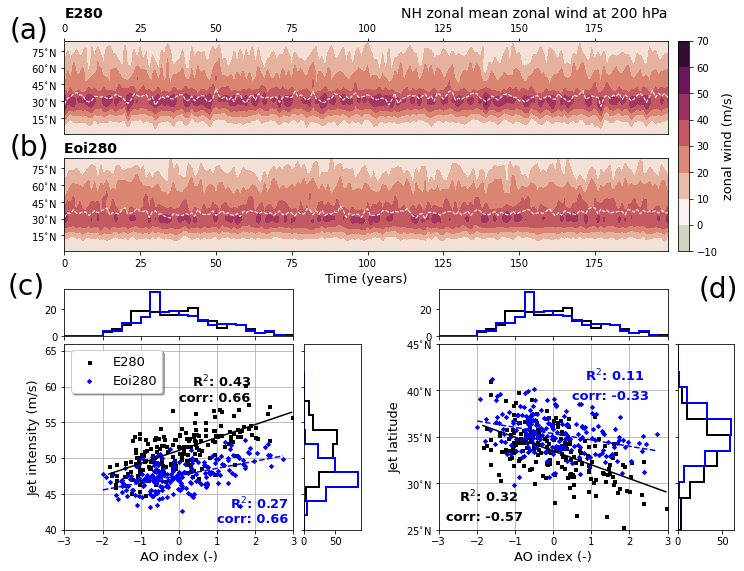

In [874]:
fig = plt.figure(figsize = (12,9), constrained_layout=False)

mP_color = 'b'

widths = [4, 1, 1, 4, .2, .6]; heights = [2, 0.2, 2, 0.5, 1, 4];
spec = fig.add_gridspec(ncols=6, nrows=6, width_ratios=widths, height_ratios=heights, wspace=0.1, hspace=0.1)

lats=np.array([15,30,45,60,75]); degN = r'$^{\circ}$N';
latlabels = [f'{lats[i]}'+degN for i in range(len(lats))];

lats2=np.array([25, 30, 35, 40, 45]); 
latlabels2 = [f'{lats2[i]}'+degN for i in range(len(lats2))];

vmin=-70; vmax=70; d = 10; levels = np.arange(vmin, vmax+d, d);

ax = fig.add_subplot(spec[0,0:-2])

pc=ax.contourf(times, unh1.lat, unh1.T, levels=levels, cmap='cmo.curl')
ax.plot(times, latunh1, 'k', linestyle='--', linewidth=1, color='w')
ax.set_yticks(lats); ax.set_yticklabels(latlabels); #ax.set_ylabel('Latitude');
# ax.set_xlabel('Time (years)')
ax.tick_params(labelbottom=False, labeltop=True, labelleft=True, labelright=False, bottom=False, top=True, left=True, right=False)
ax.xaxis.set_label_position("top")
ax.set_title('E280', fontsize=14, loc='left', fontweight='bold')
ax.set_title('NH zonal mean zonal wind at 200 hPa', fontsize=14, loc='right'); 

ax.text(-18, 87, '(a)', fontsize=28)

ax = fig.add_subplot(spec[2,0:-2])

ax.contourf(times, unh3.lat, unh3.T, levels=levels, cmap='cmo.curl')
ax.plot(times, latunh3, 'k', linestyle='--', linewidth=1, color='w')
ax.set_yticks(lats); ax.set_yticklabels(latlabels); #ax.set_ylabel('Latitude');
ax.set_xlabel('Time (years)',fontsize=13)
ax.set_title('Eoi280 ', fontsize=14, loc='left', fontweight='bold')

ax.text(-18, 87, '(b)', fontsize=28)

ax = fig.add_subplot(spec[0:3,4:5])

cmap1 = plt.get_cmap('cmo.curl')
bounds = levels[6:]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap1.N)
colors = cmap1(np.linspace((bounds[0] - levels[0])/(levels[-1] - levels[0]), 1, cmap1.N))
cmap1_ = matplotlib.colors.LinearSegmentedColormap.from_list('cmo.curl', colors)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap1_.N)

cbar = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap1_, norm=norm, boundaries = bounds, orientation='vertical'); cbar.set_label('zonal wind (m/s)', fontsize=13); 


#####################################################################################################################################################################

ax = fig.add_subplot(spec[5, 0]); ax_histx = fig.add_subplot(spec[4, 0], sharex=ax); ax_histy = fig.add_subplot(spec[5, 1], sharey=ax);
ax.grid("on"); ax.set_axisbelow(True)
ax.scatter(nhem1, maxunh1, color='k', marker = 's', s=9, label='E280')
ax.scatter(nhem3, maxunh3, color=mP_color, marker = 'D', s=8, label='Eoi280')

binsx = np.arange(-3, 3.25, 0.25); binsy = np.arange(30, 64, 2)
scatter_hist(nhem1, maxunh1, ax_histx, ax_histy, binsx, binsy, 'k')
scatter_hist(nhem3, maxunh3, ax_histx, ax_histy, binsx, binsy, mP_color)

ax.set_xlim([-3,3]); ax.set_ylim([40,66]); 
ax.set_ylabel('Jet intensity (m/s)', fontsize=13); ax.set_xlabel('AO index (-)', fontsize=13)
ax.legend(fontsize=13, shadow=True)

model = np.polyfit(nhem1, maxunh1, 1); predict = np.poly1d(model); y1 = predict(nhem1)
rsq = r2_score(maxunh1, y1)
x1 = np.array([nhem1.min(), nhem1.max()]); y1 = predict(x1)
ax.plot(x1,y1, 'k-')
ax.text(0, 60, f'   R$^2$: {np.round(rsq,2)}', fontsize=13, fontweight = 'bold', color='k')
ax.text(0, 58, f'corr: {np.round(np.corrcoef(nhem1, maxunh1)[0,1],2)}', fontsize=13, fontweight = 'bold', color='k')

ax.text(-4.5, 73, '(c)', fontsize=28)

model = np.polyfit(nhem3, maxunh3, 1); predict = np.poly1d(model); y3 = predict(nhem3)
rsq = r2_score(maxunh3, y3)
x3 = np.array([nhem3.min(), nhem3.max()]); y3 = predict(x3)
ax.plot(x3,y3, '--', color=mP_color)
ax.text(1, 43, f'   R$^2$: {np.round(rsq,2)}', fontsize=13, fontweight = 'bold', color=mP_color)
ax.text(1, 41, f'corr: {np.round(np.corrcoef(nhem1, maxunh1)[0,1],2)}', fontsize=13, fontweight = 'bold', color=mP_color)

####

ax = fig.add_subplot(spec[5, 3]); ax_histx = fig.add_subplot(spec[4, 3], sharex=ax); ax_histy = fig.add_subplot(spec[5, 4:], sharey=ax);
ax.grid("on"); ax.set_axisbelow(True)
ax.scatter(nhem1, latunh1, color='k', marker = 's', s=9)
ax.scatter(nhem3, latunh3, color=mP_color, marker = 'D', s=8)

binsx = np.arange(-3, 3.25, 0.25); binsy = np.arange(25., 45.5, 1.7)
scatter_hist(nhem1, latunh1, ax_histx, ax_histy, binsx, binsy, 'k')
scatter_hist(nhem3, latunh3, ax_histx, ax_histy, binsx, binsy, mP_color)

ax.set_xlim([-3,3]); 
ax.set_ylim([25, 45]); 
ax.set_yticks(lats2); ax.set_yticklabels(latlabels2);
ax.set_ylabel('Jet latitude', fontsize=13); ax.set_xlabel('AO index (-)', fontsize=13)

model = np.polyfit(nhem1, latunh1, 1); predict = np.poly1d(model); y1 = predict(nhem1)
rsq = r2_score(latunh1, y1)
x1 = np.array([nhem1.min(), nhem1.max()]); y1 = predict(x1)
ax.plot(x1,y1, 'k-'); #ax.text(-2.5, 27, f'R$^2$ = {np.round(rsq,2)}', fontsize=12)
ax.text(-2.8, 28, f'   R$^2$: {np.round(rsq,2)}', fontsize=13, fontweight = 'bold', color='k')
ax.text(-2.8, 26, f'corr: {np.round(np.corrcoef(nhem1, latunh1)[0,1],2)}', fontsize=13, fontweight = 'bold', color='k')

model = np.polyfit(nhem3, latunh3, 1); predict = np.poly1d(model); y3 = predict(nhem3)
rsq = r2_score(latunh3, y3)
x3 = np.array([nhem3.min(), nhem3.max()]); y3 = predict(x3)
ax.plot(x3,y3, '--', color=mP_color); 
ax.text(0.5, 41, f'   R$^2$: {np.round(rsq,2)}', fontsize=13, fontweight = 'bold', color=mP_color)
ax.text(0.5, 39, f'corr: {np.round(np.corrcoef(nhem3, latunh3)[0,1],2)}', fontsize=13, fontweight = 'bold', color=mP_color)

ax.text(3.8, 50, '(d)', fontsize=28)

plt.savefig('200years/figures/revisions/FIGURES3_raw.png', dpi=300)

# Figure S4

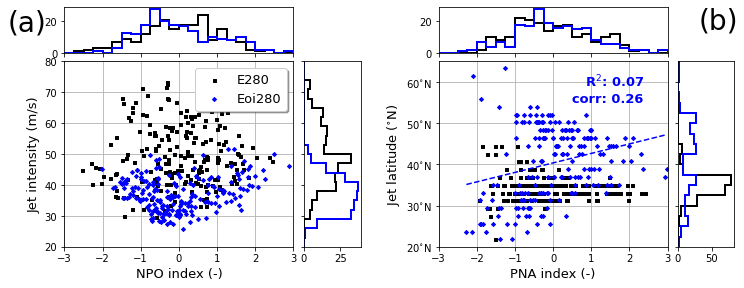

In [875]:
fig = plt.figure(figsize = (12,5), constrained_layout=False)

mP_color = 'b'

widths = [4, 1, 1, 4, .2, .6]; heights = [0.5, 1, 4];
spec = fig.add_gridspec(ncols=6, nrows=3, width_ratios=widths, height_ratios=heights, wspace=0.1, hspace=0.1)

lats=np.array([15,30,45,60,75]); degN = r'$^{\circ}$N';
latlabels = [f'{lats[i]}'+degN for i in range(len(lats))];

lats2=np.array([20, 30, 40, 50, 60]); 
latlabels2 = [f'{lats2[i]}'+degN for i in range(len(lats2))];

#####################################################################################################################################################################

ax = fig.add_subplot(spec[2, 0]); ax_histx = fig.add_subplot(spec[1, 0], sharex=ax); ax_histy = fig.add_subplot(spec[2, 1], sharey=ax);
ax.grid("on"); ax.set_axisbelow(True)
ax.scatter(npacz1, maxu1, color='k', marker = 's', s=9, label='E280')
ax.scatter(npacz3, maxu3, color=mP_color, marker = 'D', s=8, label='Eoi280')

binsx = np.arange(-3, 3.25, 0.25); binsy = np.arange(20, 83, 3)
scatter_hist(npacz1, maxu1, ax_histx, ax_histy, binsx, binsy, 'k')
scatter_hist(npacz3, maxu3, ax_histx, ax_histy, binsx, binsy, mP_color)

ax.set_xlim([-3,3]); ax.set_ylim([20,80]); 
ax.set_ylabel('Jet intensity (m/s)', fontsize=13); ax.set_xlabel('NPO index (-)', fontsize=13)
ax.legend(fontsize=13, shadow=True)

# model = np.polyfit(npacz1, maxu1, 1); predict = np.poly1d(model); y1 = predict(npacz1)
# rsq = r2_score(maxu1, y1)
# x1 = np.array([npacz1.min(), npacz1.max()]); y1 = predict(x1)
# ax.plot(x1,y1, 'k-')
# ax.text(-2.8, 55, f'   R$^2$: {np.round(rsq,2)}', fontsize=13, fontweight = 'bold', color='k')
# ax.text(-2.8, 50, f'corr: {np.round(np.corrcoef(npacz1, maxu1)[0,1],2)}', fontsize=13, fontweight = 'bold', color='k')

ax.text(-4.5, 90, '(a)', fontsize=28)

# model = np.polyfit(npacz3, maxu3, 1); predict = np.poly1d(model); y3 = predict(npacz3)
# rsq = r2_score(maxu3, y3)
# x3 = np.array([npacz3.min(), npacz3.max()]); y3 = predict(x3)
# ax.plot(x3,y3, '--', color=mP_color)
# ax.text(1, 27, f'   R$^2$: {np.round(rsq,2)}', fontsize=13, fontweight = 'bold', color=mP_color)
# ax.text(1, 23, f'corr: {np.round(np.corrcoef(npacz1, maxu1)[0,1],2)}', fontsize=13, fontweight = 'bold', color=mP_color)

####

ax = fig.add_subplot(spec[2, 3]); ax_histx = fig.add_subplot(spec[1, 3], sharex=ax); ax_histy = fig.add_subplot(spec[2, 4:], sharey=ax);
ax.grid("on"); ax.set_axisbelow(True)
ax.scatter(npaca1, latu1, color='k', marker = 's', s=9)
ax.scatter(npaca3, latu3, color=mP_color, marker = 'D', s=8)

binsx = np.arange(-3, 3.25, 0.25); binsy = np.arange(20, 67.5, 2.5)
scatter_hist(npaca1, latu1, ax_histx, ax_histy, binsx, binsy, 'k')
scatter_hist(npaca3, latu3, ax_histx, ax_histy, binsx, binsy, mP_color)

ax.set_xlim([-3,3]); ax.set_ylim([20, 65]); 
ax.set_yticks(lats2); ax.set_yticklabels(latlabels2);
ax.set_ylabel('Jet latitude ($^{\circ}$N)', fontsize=13); ax.set_xlabel('PNA index (-)', fontsize=13)

# model = np.polyfit(npaca1, latu1, 1); predict = np.poly1d(model); y1 = predict(npaca1)
# rsq = r2_score(latu1, y1)
# x1 = np.array([npaca1.min(), npaca1.max()]); y1 = predict(x1)
# ax.plot(x1,y1, 'k-'); #ax.text(-2.5, 27, f'R$^2$ = {np.round(rsq,2)}', fontsize=12)
# ax.text(-2.8, 27, f'   R$^2$: {np.round(rsq,2)}', fontsize=13, fontweight = 'bold', color='k')
# ax.text(-2.8, 23, f'corr: {np.round(np.corrcoef(npaca1, latu1)[0,1],2)}', fontsize=13, fontweight = 'bold', color='k')

model = np.polyfit(npaca3, latu3, 1); predict = np.poly1d(model); y3 = predict(npaca3)
rsq = r2_score(latu3, y3)
x3 = np.array([npaca3.min(), npaca3.max()]); y3 = predict(x3)
ax.plot(x3,y3, '--', color=mP_color); 
ax.text(0.5, 59, f'   R$^2$: {np.round(rsq,2)}', fontsize=13, fontweight = 'bold', color=mP_color)
ax.text(0.5, 55, f'corr: {np.round(np.corrcoef(npaca3, latu3)[0,1],2)}', fontsize=13, fontweight = 'bold', color=mP_color)

ax.text(3.8, 73, '(b)', fontsize=28)

plt.savefig('200years/figures/revisions/FIGURES4_raw.png',dpi=300)

## FIGURE S5

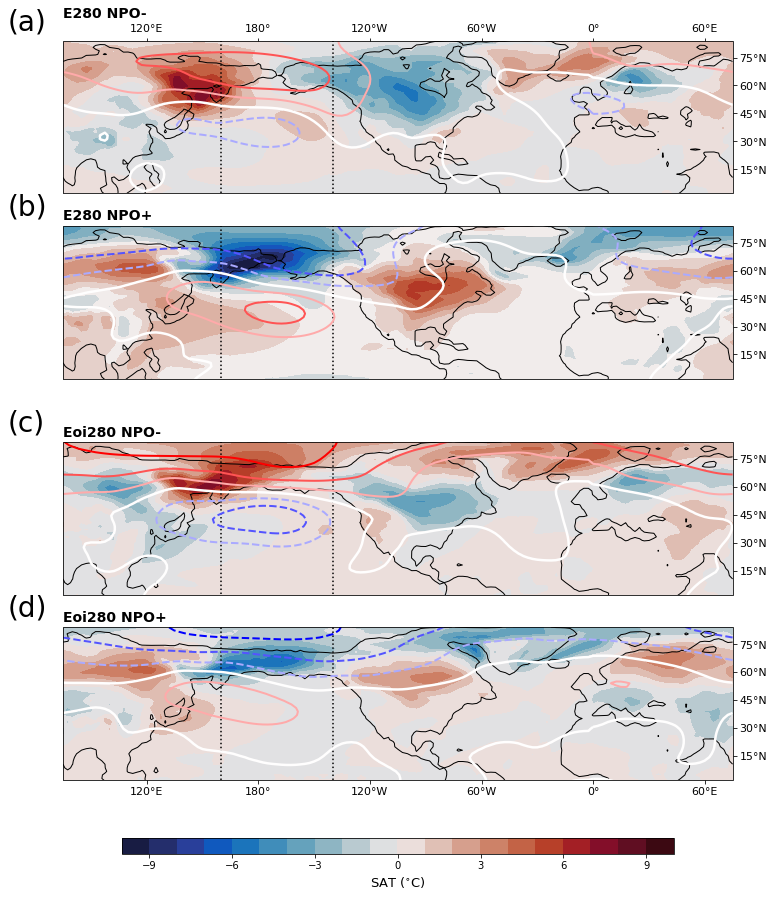

In [876]:
fig = plt.figure(figsize = (12,15), constrained_layout=False)

vmin=-12; vmax=12; vmin2=-42; vmax2=42; cmap = 'cmo.balance';

widths = [0.2, 1, .2]; heights = [1, 1, 0.02, 1, 1, 0.0, 0.1];
spec = fig.add_gridspec(ncols=3, nrows=7, width_ratios=widths, height_ratios=heights, wspace=-0.2, hspace=0.3)

clon = -105;

lats=np.array([0, 15, 30, 45, 60, 75]); degN = r'$^{\circ}$N';
latlabels = [f'{lats[i]}'+degN for i in range(len(lats))];

levs=np.array([1000, 500, 300, 200, 100]);
levlabels = [f'{levs[i]}' for i in range(len(levs))];

l1 = 0.; l2 = 320.;
lonslice = np.array([160, 220]);

slplevs = np.array([-15, -10, -5, 0, 5, 10, 15]); styles2, lw2 = styles_width(slplevs, 2)

vmin=-10; vmax=10; d = 1; levels = np.arange(vmin, vmax+d, d);

ax = fig.add_subplot(spec[0,:], projection=ccrs.PlateCarree(central_longitude=clon))

t1_min_ = cyclic_array(t1_min)
p1_min_ = cyclic_array(xr.DataArray(gaussian_filter(p1_min, sigma=2), coords=p1_min.coords, dims=p1_min.dims))

t1_min_.plot.contourf(ax=ax, transform = ccrs.PlateCarree(), levels=levels, cmap = 'cmo.balance', add_colorbar=False   )
ax.contour(lfnh.lon, lfnh.lat, lfnh.sel(exp=1).landfrac, linewidths = 1., levels=[lfnh.sel(exp=3).clevel], colors = 'k', transform=ccrs.PlateCarree())
ax.plot([lonslice[0], lonslice[0]],[0,85], 'k:', transform = ccrs.PlateCarree(),zorder=1); ax.plot([lonslice[1], lonslice[1]],[0,85], 'k:', transform = ccrs.PlateCarree(),zorder=1)
p1_min_.plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = slplevs, cmap='bwr', linestyles=styles2, linewidths=lw2)
ax.set_title('E280 NPO-', loc='left', fontsize=14, fontweight='bold'); ax.set_title('')

lat_ticks(ax,'NH2');  ax.yaxis.tick_right(); lon_ticks(ax, 'top'); ax.set_extent([75, 285, 2, 84], crs=ccrs.PlateCarree())

ax.text(-210, 90, '(a)', fontsize = 28)

####################################################################################################################################

ax = fig.add_subplot(spec[1,:], projection=ccrs.PlateCarree(central_longitude=clon))

t1_plus_ = cyclic_array(t1_plus)
p1_plus_ = cyclic_array(xr.DataArray(gaussian_filter(p1_plus, sigma=2), coords=p1_min.coords, dims=p1_min.dims))

t1_plus_.plot.contourf(ax=ax, transform = ccrs.PlateCarree(), levels=levels, cmap = 'cmo.balance', add_colorbar=False   )
ax.contour(lfnh.lon, lfnh.lat, lfnh.sel(exp=1).landfrac, linewidths = 1., levels=[lfnh.sel(exp=3).clevel], colors = 'k', transform=ccrs.PlateCarree())
ax.plot([lonslice[0], lonslice[0]],[0,85], 'k:', transform = ccrs.PlateCarree(),zorder=1); ax.plot([lonslice[1], lonslice[1]],[0,85], 'k:', transform = ccrs.PlateCarree(),zorder=1)
p1_plus_.plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = slplevs, cmap='bwr', linestyles=styles2, linewidths=lw2)
ax.set_title('E280 NPO+', loc='left', fontsize=14, fontweight='bold'); ax.set_title('')

lat_ticks(ax,'NH2');  ax.yaxis.tick_right(); ax.set_extent([75, 285, 2, 84], crs=ccrs.PlateCarree())

ax.text(-210, 90, '(b)', fontsize = 28)

####################################################################################################################################

ax = fig.add_subplot(spec[3,:], projection=ccrs.PlateCarree(central_longitude=clon))

t3_min_ = cyclic_array(t3_min)
p3_min_ = cyclic_array(xr.DataArray(gaussian_filter(p3_min, sigma=2), coords=p3_min.coords, dims=p3_min.dims))

t3_min_.plot.contourf(ax=ax, transform = ccrs.PlateCarree(), levels=levels, cmap = 'cmo.balance', add_colorbar=False   )
ax.contour(lfnh.lon, lfnh.lat, lfnh.sel(exp=3).landfrac, linewidths = 1., levels=[lfnh.sel(exp=3).clevel], colors = 'k', transform=ccrs.PlateCarree())
ax.plot([lonslice[0], lonslice[0]],[0,85], 'k:', transform = ccrs.PlateCarree(),zorder=1); ax.plot([lonslice[1], lonslice[1]],[0,85], 'k:', transform = ccrs.PlateCarree(),zorder=1)
p3_min_.plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = slplevs, cmap='bwr', linestyles=styles2, linewidths=lw2)
ax.set_title('Eoi280 NPO-', loc='left', fontsize=14, fontweight='bold'); ax.set_title('')

lat_ticks(ax,'NH2');  ax.yaxis.tick_right(); ax.set_extent([75, 285, 2, 84], crs=ccrs.PlateCarree())

ax.text(-210, 90, '(c)', fontsize = 28)

####################################################################################################################################

ax = fig.add_subplot(spec[4,:], projection=ccrs.PlateCarree(central_longitude=clon))

t3_plus_ = cyclic_array(t3_plus)
p3_plus_ = cyclic_array(xr.DataArray(gaussian_filter(p3_plus, sigma=2), coords=p3_min.coords, dims=p3_min.dims))

t3_plus_.plot.contourf(ax=ax, transform = ccrs.PlateCarree(), levels=levels, cmap = 'cmo.balance', add_colorbar=False   )
ax.contour(lfnh.lon, lfnh.lat, lfnh.sel(exp=3).landfrac, linewidths = 1., levels=[lfnh.sel(exp=3).clevel], colors = 'k', transform=ccrs.PlateCarree())
ax.plot([lonslice[0], lonslice[0]],[0,85], 'k:', transform = ccrs.PlateCarree(),zorder=1); ax.plot([lonslice[1], lonslice[1]],[0,85], 'k:', transform = ccrs.PlateCarree(),zorder=1)
p3_plus_.plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = slplevs, cmap='bwr', linestyles=styles2, linewidths=lw2)
ax.set_title('Eoi280 NPO+', loc='left', fontsize=14, fontweight='bold'); ax.set_title('')

lat_ticks(ax,'NH2'); ax.yaxis.tick_right(); lon_ticks(ax, 'bottom'); ax.set_extent([75, 285, 2, 84], crs=ccrs.PlateCarree())

ax.text(-210, 90, '(d)', fontsize = 28)

ax = fig.add_subplot(spec[6,1])

cmap=plt.get_cmap('cmo.balance')
bounds = levels
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cbar = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='horizontal'); 
cbar.set_label('SAT ($^{\circ}$C)', fontsize=13); 

# plt.savefig('200years/figures/FIGURE9_raw.pdf')
# plt.savefig('200years/figures/FIGURES4_raw.png', dpi=300)

plt.savefig('200years/figures/revisions/FIGURES5_raw.png',dpi=300)

# FIGURE S6 

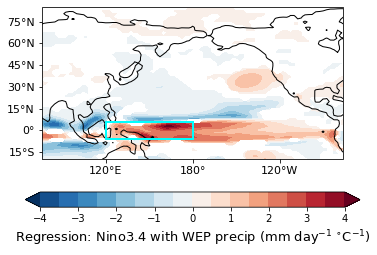

In [883]:
from matplotlib.patches import Rectangle

plt.figure(figsize=(6,4))

x = nino1
y = prect_convert*ds1.prect.sel(lat = slice(-20,85))

# corrs = xs.pearson_r(x,y, "time")
corrs = xs.linslope(x,y, "time")
pvals = xs.pearson_r_p_value(x,y, "time")

ax = plt.subplot(111, projection=ccrs.PlateCarree(central_longitude=-105))
fill = corrs.where(pvals<0.05).plot.contourf(ax=ax, levels = np.arange(-4,4.5,0.5), 
                                      cmap=plt.cm.RdBu_r, transform=ccrs.PlateCarree(), extend='both',add_colorbar=False)

ax.contour(lfnh2.lon, lfnh2.lat, lfnh2.sel(exp=1).landfrac, linewidths = 1., levels=[lfnh2.sel(exp=3).clevel], colors = 'k', transform=ccrs.PlateCarree())
lat_ticks(ax,'NH3');  ax.yaxis.tick_left(); lon_ticks(ax, 'bottom'); 

ax.add_patch(Rectangle((120,-6),60,12, linewidth=2, edgecolor='cyan',facecolor='none',zorder = 2, transform=ccrs.PlateCarree()))

ax.set_extent([76, 284, -20, 85], crs=ccrs.PlateCarree())

cbar = plt.colorbar(fill, orientation='horizontal')
cbar.set_label('Regression: Nino3.4 with WEP precip (mm day$^{-1}$ $^{\circ}$C$^{-1}$)', fontsize=13); 

# plt.show()

plt.savefig('200years/figures/revisions/FIGURES6_raw.png',dpi=300)

# Rossby Wave Source

In [754]:
from windspharm.xarray import VectorWind
from windspharm.examples import example_data_path

import xesmf as xe

In [757]:
dsref = xr.open_mfdataset([example_data_path(f) for f in ('uwnd_mean.nc', 'vwnd_mean.nc')])
uref = dsref['uwnd']

ds_ = dsu1
# ds_ = dsu3

for i in range(len(ds_.time)):
    ds = ds_.isel(time=i)

    uwnd = ds.u.sel(plev=200)
    uwnd = uwnd.rename({'lat': 'latitude','lon': 'longitude'})
    uwnd = uwnd.interp_like(uref)

    vwnd = ds.v.sel(plev=200)
    vwnd = vwnd.rename({'lat': 'latitude','lon': 'longitude'})
    vwnd = vwnd.interp_like(uref)

    # Create a VectorWind instance to handle the computations.
    w = VectorWind(uwnd, vwnd)

    # Compute components of rossby wave source: absolute vorticity, divergence,
    # irrotational (divergent) wind components, gradients of absolute vorticity.
    eta = w.absolutevorticity()
    div = w.divergence()
    uchi, vchi = w.irrotationalcomponent()
    etax, etay = w.gradient(eta)
    etax.attrs['units'] = 'm**-1 s**-1'
    etay.attrs['units'] = 'm**-1 s**-1'

    # Combine the components to form the Rossby wave source term.
#     RWS = eta * -1. * div - (uchi * etax + vchi * etay)
#     RWS["time"] = ds.time

    RWS_vs = eta * -1. * div; #vortex stretching
    RWS_adv = - (uchi * etax + vchi * etay); #advection of absolute vorticity by the divergent flow
    RWS_vs["time"] = ds.time; RWS_adv["time"] = ds.time;

    VP = w.velocitypotential()
    VP["time"] = ds.time
    
    if i==0: 
        VP_ = VP;
        RWS_vs_ = RWS_vs; RWS_adv_ = RWS_adv;
    else:
        VP_ = xr.concat([VP_, VP], dim="time");
        RWS_vs_ = xr.concat([RWS_vs_, RWS_vs], dim="time");
        RWS_adv_ = xr.concat([RWS_adv_, RWS_adv], dim="time");
        
VP_ = VP_.rename({'latitude': 'lat','longitude': 'lon'})

RWS_vs_  = RWS_vs_.rename({'latitude': 'lat','longitude': 'lon'})
RWS_adv_ = RWS_adv_.rename({'latitude': 'lat','longitude': 'lon'})
RWS_ = RWS_vs_ + RWS_adv_

In [758]:
RWS1 = RWS_
RWS_vs1 = RWS_vs_

# RWS3 = RWS_
# RWS_vs3 = RWS_vs_

### interpolate RWS onto atm grid

In [759]:
rws1 = RWS1.interp_like(ds1.SLP.sel(lat = slice(-20,85)))
rws3 = RWS3.interp_like(ds3.SLP.sel(lat = slice(-20,85)))

rws_vs1 = RWS_vs1.interp_like(ds1.SLP.sel(lat = slice(-20,85)))
rws_vs3 = RWS_vs3.interp_like(ds3.SLP.sel(lat = slice(-20,85)))

In [760]:
rws1_ea  = rws1.sel(lat=slice(25,45), lon=slice(100,150)).mean({"lon", "lat"})
rws3_ea  = rws3.sel(lat=slice(25,45), lon=slice(100,150)).mean({"lon", "lat"})

rws_vs1_ea  = rws_vs1.sel(lat=slice(25,45), lon=slice(100,150)).mean({"lon", "lat"})
rws_vs3_ea  = rws_vs3.sel(lat=slice(25,45), lon=slice(100,150)).mean({"lon", "lat"})

# FIGURE S7

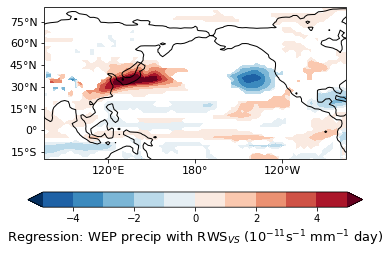

In [884]:
x = prect_convert*prect1_wep
y = 1e11 * rws_vs1.sel(lon = slice(75,285))

# corrs = xs.pearson_r(x,y, "time")
corrs = xs.linslope(x,y, "time")
pvals = xs.pearson_r_p_value(x,y, "time")

plt.figure(figsize=(6,4))

vmin=-5;vmax=5;d=1;clevs=np.arange(vmin,vmax+d,d);

ax = plt.subplot(111, projection=ccrs.PlateCarree(central_longitude=-105))
fill = corrs.where(pvals<0.05).plot.contourf(ax=ax, levels = clevs, 
                                      cmap=plt.cm.RdBu_r, transform=ccrs.PlateCarree(), extend='both',add_colorbar=False)

ax.contour(lfnh2.lon, lfnh2.lat, lfnh2.sel(exp=1).landfrac, linewidths = 1., levels=[lfnh2.sel(exp=3).clevel], colors = 'k', transform=ccrs.PlateCarree())
lat_ticks(ax,'NH3');  ax.yaxis.tick_left(); lon_ticks(ax, 'bottom'); 

ax.set_extent([76, 284, -20, 85], crs=ccrs.PlateCarree())

cbar = plt.colorbar(fill, orientation='horizontal')
cbar.set_label('Regression: WEP precip with RWS$_{VS}$ ($10^{-11}$s$^{-1}$ mm$^{-1}$ day)', fontsize=13); 

# plt.show()

plt.savefig('200years/figures/revisions/FIGURES7_raw.png',dpi=300)

# Figure S8

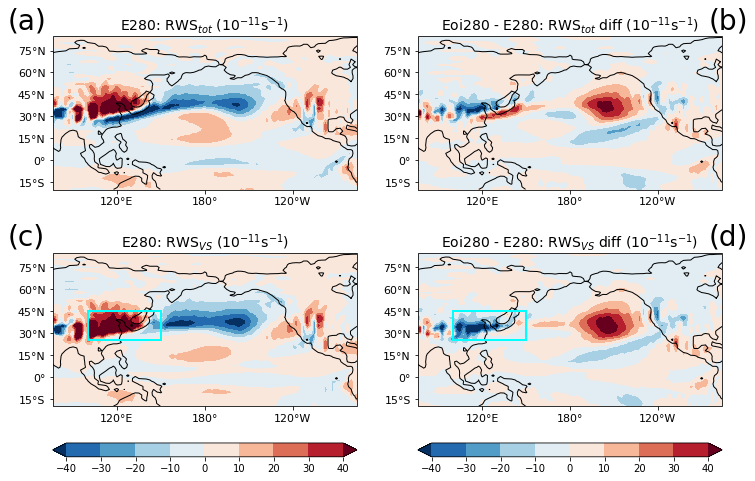

In [879]:
x1 = (1e11 * rws1.mean("time")).sel(lon = slice(75,285))
y1 = (1e11 * rws3.mean("time")).sel(lon = slice(75,285))
x2 = (1e11 * rws_vs1.mean("time")).sel(lon = slice(75,285))
y2 = (1e11 * rws_vs3.mean("time")).sel(lon = slice(75,285))

plt.figure(figsize=(12,9))

data = x1
vmin=-40; vmax=40; d=10; clevs = np.arange(vmin, vmax+d, d);

ax = plt.subplot(221, projection=ccrs.PlateCarree(central_longitude=-105))
fill = data.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                              transform=ccrs.PlateCarree(), extend='both',
                              add_colorbar=False)
ax.contour(lfnh2.lon, lfnh2.lat, lfnh2.sel(exp=1).landfrac, linewidths = 1., levels=[lfnh2.sel(exp=3).clevel], colors = 'k', transform=ccrs.PlateCarree())
lat_ticks(ax,'NH3');  ax.yaxis.tick_left(); lon_ticks(ax, 'bottom'); 

ax.set_extent([76, 284, -20, 85], crs=ccrs.PlateCarree())

# cbar = plt.colorbar(fill, orientation='horizontal')
# cbar.set_label('Regression: WEP precip with RWS$_{VS}$ ($10^{-11}$s$^{-1}$ mm$^{-1}$ day)', fontsize=13); 
ax.set_title('E280: RWS$_{tot}$ ($10^{-11}$s$^{-1}$)', fontsize=14)
# plt.title('Eoi280 - E280: RWS diff ($10^{-11}$s$^{-1}$)', fontsize=14)

ax.text(-210, 90, '(a)', fontsize = 28)

#####

data = y1-x1
vmin=-40; vmax=40; d=10; clevs = np.arange(vmin, vmax+d, d);

ax = plt.subplot(222, projection=ccrs.PlateCarree(central_longitude=-105))
fill = data.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                              transform=ccrs.PlateCarree(), extend='both',
                              add_colorbar=False)
ax.contour(lfnh2.lon, lfnh2.lat, lfnh2.sel(exp=1).landfrac, linewidths = 1., levels=[lfnh2.sel(exp=3).clevel], colors = 'k', transform=ccrs.PlateCarree())
lat_ticks(ax,'NH3');  ax.yaxis.tick_left(); lon_ticks(ax, 'bottom'); 

ax.set_extent([76, 284, -20, 85], crs=ccrs.PlateCarree())

# cbar = plt.colorbar(fill, orientation='horizontal')
# cbar.set_label('Regression: WEP precip with RWS$_{VS}$ ($10^{-11}$s$^{-1}$ mm$^{-1}$ day)', fontsize=13); 
ax.set_title('Eoi280 - E280: RWS$_{tot}$ diff ($10^{-11}$s$^{-1}$)', fontsize=14)
# plt.title('Eoi280 - E280: RWS diff ($10^{-11}$s$^{-1}$)', fontsize=14)

ax.text(20, 90, '(b)', fontsize = 28)

#####

data = x2
vmin=-40; vmax=40; d=10; clevs = np.arange(vmin, vmax+d, d);

ax = plt.subplot(223, projection=ccrs.PlateCarree(central_longitude=-105))
fill = data.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                              transform=ccrs.PlateCarree(), extend='both',
                              add_colorbar=False)
ax.contour(lfnh2.lon, lfnh2.lat, lfnh2.sel(exp=1).landfrac, linewidths = 1., levels=[lfnh2.sel(exp=3).clevel], colors = 'k', transform=ccrs.PlateCarree())
lat_ticks(ax,'NH3');  ax.yaxis.tick_left(); lon_ticks(ax, 'bottom'); 

ax.add_patch(Rectangle((100,25),50,20, linewidth=2, edgecolor='cyan',facecolor='none',zorder = 2, transform=ccrs.PlateCarree()))

ax.set_extent([76, 284, -20, 85], crs=ccrs.PlateCarree())

cbar = plt.colorbar(fill, orientation='horizontal')
# cbar.set_label('Regression: WEP precip with RWS$_{VS}$ ($10^{-11}$s$^{-1}$ mm$^{-1}$ day)', fontsize=13); 
ax.set_title('E280: RWS$_{VS}$ ($10^{-11}$s$^{-1}$)', fontsize=14)
# plt.title('Eoi280 - E280: RWS diff ($10^{-11}$s$^{-1}$)', fontsize=14)
ax.text(-210, 90, '(c)', fontsize = 28)

#####

data = y2-x2
vmin=-40; vmax=40; d=10; clevs = np.arange(vmin, vmax+d, d);

ax = plt.subplot(224, projection=ccrs.PlateCarree(central_longitude=-105))
fill = data.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                              transform=ccrs.PlateCarree(), extend='both',
                              add_colorbar=False)
ax.contour(lfnh2.lon, lfnh2.lat, lfnh2.sel(exp=1).landfrac, linewidths = 1., levels=[lfnh2.sel(exp=3).clevel], colors = 'k', transform=ccrs.PlateCarree())
lat_ticks(ax,'NH3');  ax.yaxis.tick_left(); lon_ticks(ax, 'bottom'); 

ax.add_patch(Rectangle((100,25),50,20, linewidth=2, edgecolor='cyan',facecolor='none',zorder = 2, transform=ccrs.PlateCarree()))

ax.set_extent([76, 284, -20, 85], crs=ccrs.PlateCarree())

cbar = plt.colorbar(fill, orientation='horizontal')
# cbar.set_label('Regression: WEP precip with RWS$_{VS}$ ($10^{-11}$s$^{-1}$ mm$^{-1}$ day)', fontsize=13); 
ax.set_title('Eoi280 - E280: RWS$_{VS}$ diff ($10^{-11}$s$^{-1}$)', fontsize=14)
# plt.title('Eoi280 - E280: RWS diff ($10^{-11}$s$^{-1}$)', fontsize=14)
ax.text(20, 90, '(d)', fontsize = 28)

plt.subplots_adjust(hspace=0.0)


plt.savefig('200years/figures/revisions/FIGURES8_raw.png',dpi=300)

# Figure S9

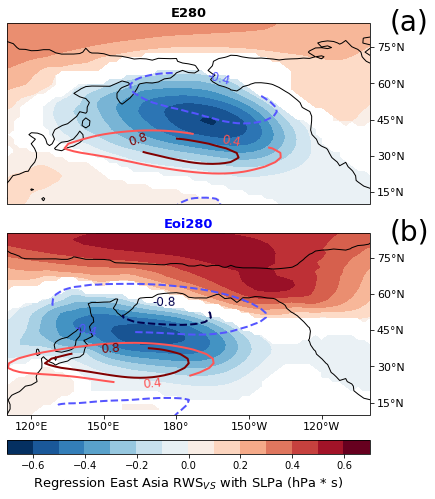

In [880]:

fig = plt.figure(figsize = (6.5,8))

widths = [ 1]; heights = [4, .1, 4, .1, .3]
spec = fig.add_gridspec(ncols=1, nrows=5, width_ratios=widths, height_ratios=heights, wspace=0.1, hspace=0.1)

########################################################################################################################################

vmin1 = -.7; vmax1 = .7; d = .1; levels = np.arange(vmin1, vmax1+d, d);
levels2 = np.array([ -.8, -.4, .4, .8]); styles2, lw2 = styles_width(levels2, 2)
cmap2 = 'seismic'

x = 1e11*rws_vs1_ea
y = 1e-2*ds1.SLP
y2 = dsp1.u.sel(plev=200)

corrs = xs.linslope(x,y, "time"); pvals = xs.pearson_r_p_value(x,y, "time"); 
corrs2 = xs.linslope(x,y2, "time"); pvals2 = xs.pearson_r_p_value(x,y2, "time"); 

ax = fig.add_subplot(spec[0,0], projection=ccrs.PlateCarree(central_longitude = -105))

fill = corrs.where(pvals<0.05).plot.contourf(ax=ax, levels = levels,
                                      cmap=plt.cm.RdBu_r, transform=ccrs.PlateCarree(), extend='both',add_colorbar=False)
ax.contour(lfnh.lon, lfnh.lat, lfnh.sel(exp=1).landfrac, linewidths = 1., levels=[lfnh.sel(exp=1).clevel], colors = 'k', transform=ccrs.PlateCarree())
c1 = corrs2.plot.contour(ax=ax, levels=levels2, cmap=cmap2, linewidths = lw2, linestyles = styles2, transform=ccrs.PlateCarree())
c2 = ax.clabel(c1, c1.levels, fontsize=12, inline=True, fmt = '%0.1f')

lat_ticks(ax,'NH2'); ax.yaxis.tick_right();
ax.text(13, 82, '(a)', color='k', fontsize = 28)

ax.set_extent([110, 260, 10, 85], crs=ccrs.PlateCarree())
# plt.colorbar(fill, ax=ax, orientation='horizontal')
ax.set_title('E280', fontsize=13, color = 'k', fontweight='bold')

x = 1e11*rws_vs3_ea
y = 1e-2*ds3.SLP
y2 = dsp3.u.sel(plev=200);

corrs = xs.linslope(x,y, "time"); pvals = xs.pearson_r_p_value(x,y, "time"); 
corrs2 = xs.linslope(x,y2, "time"); pvals2 = xs.pearson_r_p_value(x,y2, "time"); 

ax = fig.add_subplot(spec[2,0], projection=ccrs.PlateCarree(central_longitude = -105))

fill = corrs.where(pvals<0.05).plot.contourf(ax=ax, levels = levels,
                                      cmap=plt.cm.RdBu_r, transform=ccrs.PlateCarree(), extend='both',add_colorbar=False)
ax.contour(lfnh.lon, lfnh.lat, lfnh.sel(exp=3).landfrac, linewidths = 1., levels=[lfnh.sel(exp=3).clevel], colors = 'k', transform=ccrs.PlateCarree())
c1 = corrs2.plot.contour(ax=ax, levels=levels2, cmap = cmap2, linewidths = lw2, linestyles = styles2, transform=ccrs.PlateCarree())
c2 = ax.clabel(c1, c1.levels, fontsize=12, inline=True, fmt = '%.1f')

lat_ticks(ax,'NH2'); ax.yaxis.tick_right(); lon_ticks(ax, 'bottom', lons=[120, 150, 180, -150, -120])

ax.text(13, 82, '(b)', color='k', fontsize = 28)

ax.set_extent([110, 260, 10, 85], crs=ccrs.PlateCarree())
ax.set_title('Eoi280', fontsize=13, color = 'b', fontweight='bold')

ax = fig.add_subplot(spec[4,0])
# plt.colorbar(fill, ax=ax, orientation='horizontal')
cmap=plt.cm.RdBu_r
bounds = levels
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cbar = matplotlib.colorbar.ColorbarBase(ax, cmap=plt.cm.RdBu_r, norm=norm, orientation='horizontal'); 
cbar.set_label('Regression East Asia RWS$_{VS}$ with SLPa (hPa * s)', fontsize=13); 

plt.savefig('200years/figures/revisions/FIGURES9_raw.png',dpi=300)

## Energy Balance model

In [6]:

ebm2 = xr.open_dataset('EBM_climatologies/EBM_monthly_E560.nc')
ebm3 = xr.open_dataset('EBM_climatologies/EBM_monthly_Eoi280.nc')

ebm2_jan = ebm2.isel(month=0)
ebm3_jan = ebm3.isel(month=0)


## Figure S10

/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/core/alignment.py:307:

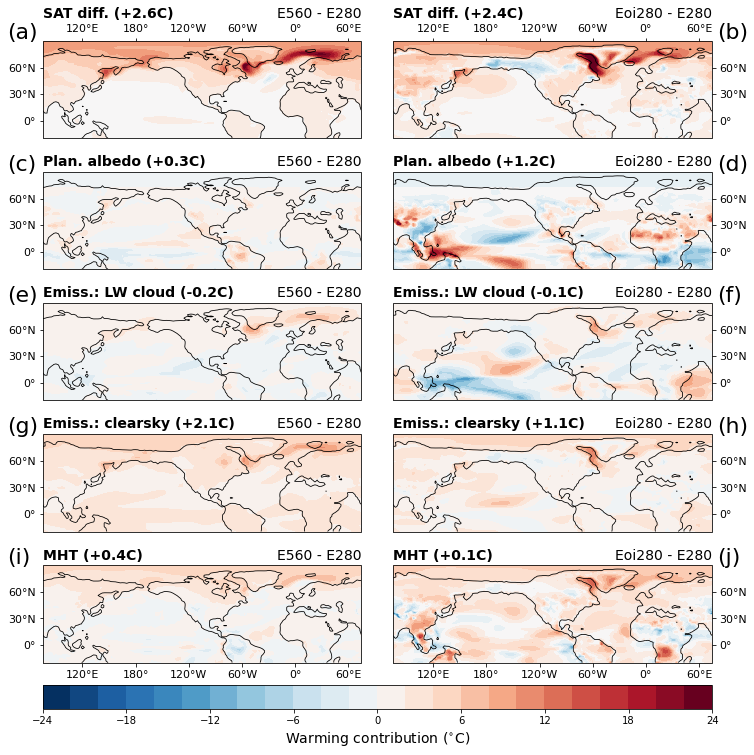

In [200]:

widths = [ 1,1]; heights = [1,1,1,1,1,0.2]
spec = fig.add_gridspec(ncols=2, nrows=6, width_ratios=widths, height_ratios=heights, wspace=0.1, hspace=0.1)

clon = -105
fig = plt.figure(figsize = (12,12.5))

levels = np.arange(-24,25, 2)

levels2 = np.array([-12, -8, -4, 4, 8, 12]); styles2, lw2 = styles_width(levels2, 1.5)
cmap2 = 'seismic'; colors2 = ['k', 'k', 'k', 'k', 'k', 'k']

levels3 = np.arange(-1, 1.1, 0.2)

ebm = ebm2_jan.sel(lat=slice(-20,90))
gw = gridweights.sel(lat=slice(-25,90))

ax = fig.add_subplot(spec[0,0], projection=ccrs.PlateCarree(central_longitude=clon))
cyclic_array(ebm.Td).plot.contourf(ax=ax, levels = levels, transform = ccrs.PlateCarree(), add_colorbar=False)
ax.contour(lfnh3.lon, lfnh3.lat, lfnh3.sel(exp=2).landfrac, linewidths = .8, levels=[lfnh3.sel(exp=2).clevel], colors = 'k', transform=ccrs.PlateCarree())
ax.set_title('E560 - E280', fontsize = 14, loc = 'right'); 
ax.set_title(f'SAT diff. (+{np.round(ebm.Td.weighted(gw).mean().values,1)}C)', fontsize = 14, fontweight='bold', loc = 'left')
lat_ticks(ax,'NH4'); ax.yaxis.tick_left(); lon_ticks(ax, 'top', lons=[120, 180, -120, -60, 0, 60])
ax.text(-220, 92, '(a)', color='k', fontsize = 22)

ax = fig.add_subplot(spec[1,0], projection=ccrs.PlateCarree(central_longitude=clon))
cyclic_array(ebm.Tap).plot.contourf(ax=ax, levels = levels, transform = ccrs.PlateCarree(), add_colorbar=False)
ax.contour(lfnh3.lon, lfnh3.lat, lfnh3.sel(exp=2).landfrac, linewidths = .8, levels=[lfnh3.sel(exp=2).clevel], colors = 'k', transform=ccrs.PlateCarree())
ax.set_title('E560 - E280', fontsize = 14, loc = 'right'); 
ax.set_title(f'Plan. albedo (+{np.round(ebm.Tap.weighted(gw).mean().values,1)}C)', fontsize = 14, fontweight='bold', loc = 'left');
lat_ticks(ax,'NH4'); ax.yaxis.tick_left(); #lon_ticks(ax, 'bottom', lons=[120, 180, -120, -60, 0, 60])
ax.text(-220, 92, '(c)', color='k', fontsize = 22)

# ax = fig.add_subplot(spec[2,0], projection=ccrs.PlateCarree(central_longitude=clon))
# cyclic_array(ebm.Tem).plot.contourf(ax=ax, levels = levels, transform = ccrs.PlateCarree(), add_colorbar=False)
# ax.contour(lfnh3.lon, lfnh3.lat, lfnh3.sel(exp=2).landfrac, linewidths = .8, levels=[lfnh3.sel(exp=2).clevel], colors = 'k', transform=ccrs.PlateCarree())
# ax.set_title('E560 - E280', fontsize = 14, loc = 'left'); ax.set_title('Emissivity', fontsize = 14, fontweight='bold')
# lat_ticks(ax,'NH4'); ax.yaxis.tick_left(); #lon_ticks(ax, 'bottom', lons=[120, 180, -120, -60, 0, 60])
# ax.text(-220, 92, '(e)', color='k', fontsize = 22)

ax = fig.add_subplot(spec[2,0], projection=ccrs.PlateCarree(central_longitude=clon))
cyclic_array(ebm.TLC).plot.contourf(ax=ax, levels = levels, transform = ccrs.PlateCarree(), add_colorbar=False)
ax.contour(lfnh3.lon, lfnh3.lat, lfnh3.sel(exp=2).landfrac, linewidths = .8, levels=[lfnh3.sel(exp=2).clevel], colors = 'k', transform=ccrs.PlateCarree())
ax.set_title('E560 - E280', fontsize = 14, loc = 'right'); 
ax.set_title(f'Emiss.: LW cloud ({np.round(ebm.TLC.weighted(gw).mean().values,1)}C)', fontsize = 14, fontweight='bold', loc = 'left');
lat_ticks(ax,'NH4'); ax.yaxis.tick_left(); #lon_ticks(ax, 'bottom', lons=[120, 180, -120, -60, 0, 60])
ax.text(-220, 92, '(e)', color='k', fontsize = 22)

ax = fig.add_subplot(spec[3,0], projection=ccrs.PlateCarree(central_longitude=clon))
cyclic_array(ebm.Tem - ebm.TLC).plot.contourf(ax=ax, levels = levels, transform = ccrs.PlateCarree(), add_colorbar=False)
ax.contour(lfnh3.lon, lfnh3.lat, lfnh3.sel(exp=3).landfrac, linewidths = .8, levels=[lfnh3.sel(exp=3).clevel], colors = 'k', transform=ccrs.PlateCarree())
ax.set_title('E560 - E280', fontsize = 14, loc = 'right'); 
ax.set_title(f'Emiss.: clearsky (+{np.round((ebm.Tem - ebm.TLC).weighted(gw).mean().values,1)}C)', fontsize = 14, fontweight='bold', loc = 'left');
lat_ticks(ax,'NH4'); ax.yaxis.tick_left(); #lon_ticks(ax, 'bottom', lons=[120, 180, -120, -60, 0, 60])
ax.text(-220, 92, '(g)', color='k', fontsize = 22)

# c1 = cyclic_array(ebm.TLC).plot.contour(ax=ax, levels=levels2, cmap = cmap2, linewidths = lw2, linestyles = styles2, transform=ccrs.PlateCarree())
# c2 = ax.clabel(c1, c1.levels, fontsize=12, inline=True, fmt = '%.1f')

ax = fig.add_subplot(spec[4,0], projection=ccrs.PlateCarree(central_longitude=clon))
cyclic_array(ebm.TH).plot.contourf(ax=ax, levels = levels, transform = ccrs.PlateCarree(), add_colorbar=False)
ax.contour(lfnh3.lon, lfnh3.lat, lfnh3.sel(exp=2).landfrac, linewidths = .8, levels=[lfnh3.sel(exp=2).clevel], colors = 'k', transform=ccrs.PlateCarree())
ax.set_title('E560 - E280', fontsize = 14, loc = 'right'); 
ax.set_title(f'MHT (+{np.round(ebm.TH.weighted(gw).mean().values,1)}C)', fontsize = 14, fontweight='bold', loc = 'left');
lat_ticks(ax,'NH4'); ax.yaxis.tick_left(); lon_ticks(ax, 'bottom', lons=[120, 180, -120, -60, 0, 60])
ax.text(-220, 92, '(i)', color='k', fontsize = 22)

###################################################

ebm = ebm3_jan.sel(lat=slice(-20,90))

ax = fig.add_subplot(spec[0,1], projection=ccrs.PlateCarree(central_longitude=clon))
cyclic_array(ebm.Td).plot.contourf(ax=ax, levels = levels, transform = ccrs.PlateCarree(), add_colorbar=False)
ax.contour(lfnh3.lon, lfnh3.lat, lfnh3.sel(exp=3).landfrac, linewidths = .8, levels=[lfnh3.sel(exp=3).clevel], colors = 'k', transform=ccrs.PlateCarree())
ax.set_title('Eoi280 - E280', fontsize = 14, loc = 'right'); 
ax.set_title(f'SAT diff. (+{np.round(ebm.Td.weighted(gw).mean().values,1)}C)', fontsize = 14, fontweight='bold', loc = 'left');
lat_ticks(ax,'NH4'); ax.yaxis.tick_right(); lon_ticks(ax, 'top', lons=[120, 180, -120, -60, 0, 60])
ax.text(185, 92, '(b)', color='k', fontsize = 22)

ax = fig.add_subplot(spec[1,1], projection=ccrs.PlateCarree(central_longitude=clon))
cyclic_array(ebm.Tap).plot.contourf(ax=ax, levels = levels, transform = ccrs.PlateCarree(), add_colorbar=False)
ax.contour(lfnh3.lon, lfnh3.lat, lfnh3.sel(exp=3).landfrac, linewidths = .8, levels=[lfnh3.sel(exp=3).clevel], colors = 'k', transform=ccrs.PlateCarree())
ax.set_title('Eoi280 - E280', fontsize = 14, loc = 'right'); 
ax.set_title(f'Plan. albedo (+{np.round(ebm.Tap.weighted(gw).mean().values,1)}C)', fontsize = 14, fontweight='bold', loc = 'left');
lat_ticks(ax,'NH4'); ax.yaxis.tick_right(); #lon_ticks(ax, 'bottom', lons=[120, 180, -120, -60, 0, 60])
ax.text(185, 92, '(d)', color='k', fontsize = 22)

# ax = fig.add_subplot(spec[2,1], projection=ccrs.PlateCarree(central_longitude=clon))
# cyclic_array(ebm.Tem).plot.contourf(ax=ax, levels = levels, transform = ccrs.PlateCarree(), add_colorbar=False)
# ax.contour(lfnh3.lon, lfnh3.lat, lfnh3.sel(exp=3).landfrac, linewidths = .8, levels=[lfnh3.sel(exp=3).clevel], colors = 'k', transform=ccrs.PlateCarree())
# ax.set_title('Eoi280 - E280', fontsize = 14, loc = 'left'); ax.set_title('Emissivity', fontsize = 14, fontweight='bold')
# lat_ticks(ax,'NH4'); ax.yaxis.tick_right(); #lon_ticks(ax, 'bottom', lons=[120, 180, -120, -60, 0, 60])
# ax.text(185, 92, '(f)', color='k', fontsize = 22)

ax = fig.add_subplot(spec[2,1], projection=ccrs.PlateCarree(central_longitude=clon))
cyclic_array(ebm.TLC).plot.contourf(ax=ax, levels = levels, transform = ccrs.PlateCarree(), add_colorbar=False)
ax.contour(lfnh3.lon, lfnh3.lat, lfnh3.sel(exp=3).landfrac, linewidths = .8, levels=[lfnh3.sel(exp=3).clevel], colors = 'k', transform=ccrs.PlateCarree())
ax.set_title('Eoi280 - E280', fontsize = 14, loc = 'right'); 
ax.set_title(f'Emiss.: LW cloud ({np.round(ebm.TLC.weighted(gw).mean().values,1)}C)', fontsize = 14, fontweight='bold', loc = 'left');
lat_ticks(ax,'NH4'); ax.yaxis.tick_right(); #lon_ticks(ax, 'bottom', lons=[120, 180, -120, -60, 0, 60])
ax.text(185, 92, '(f)', color='k', fontsize = 22)

ax = fig.add_subplot(spec[3,1], projection=ccrs.PlateCarree(central_longitude=clon))
cyclic_array(ebm.Tem - ebm.TLC).plot.contourf(ax=ax, levels = levels, transform = ccrs.PlateCarree(), add_colorbar=False)
ax.contour(lfnh3.lon, lfnh3.lat, lfnh3.sel(exp=3).landfrac, linewidths = .8, levels=[lfnh3.sel(exp=3).clevel], colors = 'k', transform=ccrs.PlateCarree())
ax.set_title('Eoi280 - E280', fontsize = 14, loc = 'right'); 
ax.set_title(f'Emiss.: clearsky (+{np.round((ebm.Tem - ebm.TLC).weighted(gw).mean().values,1)}C)', fontsize = 14, fontweight='bold', loc = 'left');
lat_ticks(ax,'NH4'); ax.yaxis.tick_right(); #lon_ticks(ax, 'bottom', lons=[120, 180, -120, -60, 0, 60])
ax.text(185, 92, '(h)', color='k', fontsize = 22)

# c1 = cyclic_array(ebm.TLC).plot.contour(ax=ax, levels=levels2, cmap = cmap2, linewidths = lw2, linestyles = styles2, transform=ccrs.PlateCarree())
# c2 = ax.clabel(c1, c1.levels, fontsize=12, inline=True, fmt = '%.1f')

ax = fig.add_subplot(spec[4,1], projection=ccrs.PlateCarree(central_longitude=clon))
cyclic_array(ebm.TH).plot.contourf(ax=ax, levels = levels, transform = ccrs.PlateCarree(), add_colorbar=False)
ax.contour(lfnh3.lon, lfnh3.lat, lfnh3.sel(exp=3).landfrac, linewidths = .8, levels=[lfnh3.sel(exp=3).clevel], colors = 'k', transform=ccrs.PlateCarree())
ax.set_title('Eoi280 - E280', fontsize = 14, loc = 'right'); 
ax.set_title(f'MHT (+{np.round(ebm.TH.weighted(gw).mean().values,1)}C)', fontsize = 14, fontweight='bold', loc = 'left');
lat_ticks(ax,'NH4'); ax.yaxis.tick_right(); lon_ticks(ax, 'bottom', lons=[120, 180, -120, -60, 0, 60])
ax.text(185, 92, '(j)', color='k', fontsize = 22)

ax = fig.add_subplot(spec[5,:])
cmap=plt.cm.RdBu_r
norm = matplotlib.colors.BoundaryNorm(levels, cmap.N)
cbar = matplotlib.colorbar.ColorbarBase(ax, cmap=plt.cm.RdBu_r, norm=norm, orientation='horizontal'); 
cbar.set_label('Warming contribution ($^{\circ}$C)', fontsize=14); 



plt.savefig('200years/figures/revisions/FIGURES10_raw.png',dpi=300)

# Eoi560 results

In [67]:
## Load Eoi560 data

ds5 = xr.open_dataset('200years/annular_data/Eoi560_200y_atm.nc')
ds5 = ds5.isel(time=ds5.groupby('time.month').groups[1]);

/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/core/indexing.py:560: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


# Figure S11

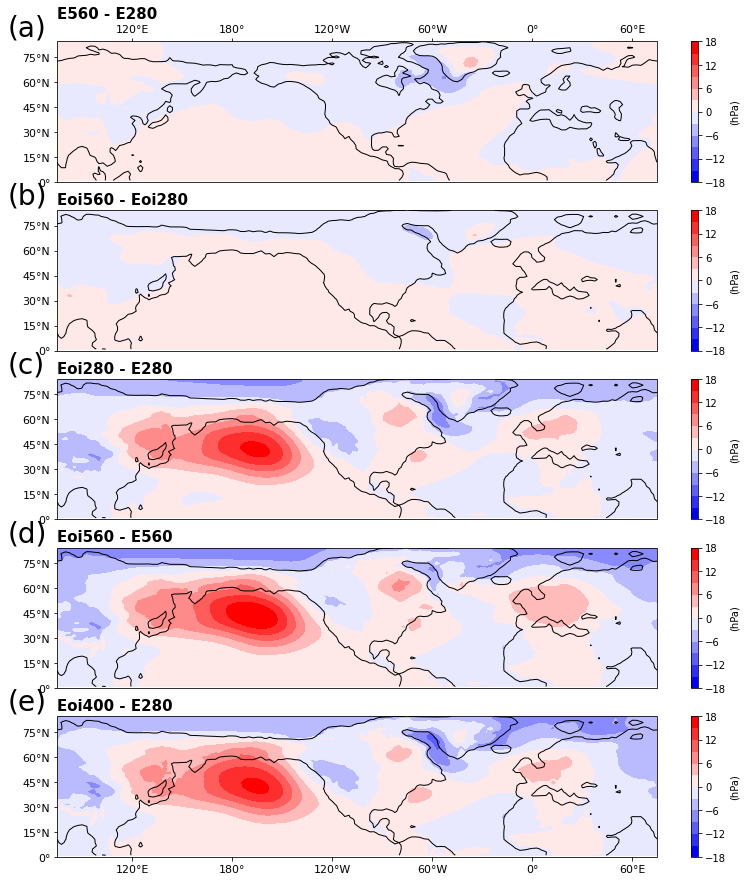

In [68]:
fig = plt.figure(figsize = (12,15), constrained_layout=False)

mslp1 = cyclic_array(0.01*ds1.SLP.sel(lat=slice(0,85)).mean("time"))
mslp2 = cyclic_array(0.01*ds2.SLP.sel(lat=slice(0,85)).mean("time"))
mslp3 = cyclic_array(0.01*ds3.SLP.sel(lat=slice(0,85)).mean("time"))
mslp4 = cyclic_array(0.01*ds4.SLP.sel(lat=slice(0,85)).mean("time"))
mslp5 = cyclic_array(0.01*ds5.SLP.sel(lat=slice(0,85)).mean("time"))


clon = -105;

vmin1 = -18; vmax1 = 18; d = 3; levels1 = np.arange(vmin1, vmax1+d, d);
    
ax = fig.add_subplot(5,1,1, projection=ccrs.PlateCarree(central_longitude=clon))
(mslp2 - mslp1).plot.contourf(ax=ax, transform = ccrs.PlateCarree(),  levels = levels1, cmap = 'bwr', cbar_kwargs={'label':'(hPa)', 'fraction':0.03})
ax.contour(lfnh.lon, lfnh.lat, lfnh.sel(exp=1).landfrac, linewidths = 1., levels=[lfnh.sel(exp=1).clevel], colors = 'k', transform=ccrs.PlateCarree())
ax.set_title(''); ax.set_title('E560 - E280', fontsize = 15, fontweight = 'bold', loc='left'); 
# ax.set_title('MSLP', fontsize = 14, loc='right')
lat_ticks(ax,'NH2'); lon_ticks(ax, 'top'); 
ax.text(-210, 88, '(a)', color='k', fontsize = 28)

ax = fig.add_subplot(5,1,2, projection=ccrs.PlateCarree(central_longitude=clon))
(mslp5 - mslp3).plot.contourf(ax=ax, transform = ccrs.PlateCarree(),  levels = levels1, cmap = 'bwr', cbar_kwargs={'label':'(hPa)', 'fraction':0.03})
ax.contour(lfnh.lon, lfnh.lat, lfnh.sel(exp=3).landfrac, linewidths = 1., levels=[lfnh.sel(exp=3).clevel], colors = 'k', transform=ccrs.PlateCarree())
ax.set_title(''); ax.set_title('Eoi560 - Eoi280', fontsize = 15, fontweight = 'bold', loc='left'); 
lat_ticks(ax,'NH2'); #lon_ticks(ax, 'top'); 
ax.text(-210, 88, '(b)', color='k', fontsize = 28)

ax = fig.add_subplot(5,1,3, projection=ccrs.PlateCarree(central_longitude=clon))
(mslp3 - mslp1).plot.contourf(ax=ax, transform = ccrs.PlateCarree(),  levels = levels1, cmap = 'bwr', cbar_kwargs={'label':'(hPa)', 'fraction':0.03})
ax.contour(lfnh.lon, lfnh.lat, lfnh.sel(exp=3).landfrac, linewidths = 1., levels=[lfnh.sel(exp=3).clevel], colors = 'k', transform=ccrs.PlateCarree())
ax.set_title(''); ax.set_title('Eoi280 - E280', fontsize = 15, fontweight = 'bold', loc='left'); 
lat_ticks(ax,'NH2');
ax.text(-210, 88, '(c)', color='k', fontsize = 28)

ax = fig.add_subplot(5,1,4, projection=ccrs.PlateCarree(central_longitude=clon))
(mslp5 - mslp2).plot.contourf(ax=ax, transform = ccrs.PlateCarree(),  levels = levels1, cmap = 'bwr', cbar_kwargs={'label':'(hPa)', 'fraction':0.03})
ax.contour(lfnh.lon, lfnh.lat, lfnh.sel(exp=3).landfrac, linewidths = 1., levels=[lfnh.sel(exp=3).clevel], colors = 'k', transform=ccrs.PlateCarree())
ax.set_title(''); ax.set_title('Eoi560 - E560', fontsize = 15, fontweight = 'bold', loc='left'); 
lat_ticks(ax,'NH2');
ax.text(-210, 88, '(d)', color='k', fontsize = 28)

ax = fig.add_subplot(5,1,5, projection=ccrs.PlateCarree(central_longitude=clon))
(mslp4 - mslp1).plot.contourf(ax=ax, transform = ccrs.PlateCarree(),  levels = levels1, cmap = 'bwr', cbar_kwargs={'label':'(hPa)', 'fraction':0.03})
ax.contour(lfnh.lon, lfnh.lat, lfnh.sel(exp=3).landfrac, linewidths = 1., levels=[lfnh.sel(exp=3).clevel], colors = 'k', transform=ccrs.PlateCarree())
ax.set_title(''); ax.set_title('Eoi400 - E280', fontsize = 15, fontweight = 'bold', loc='left'); 
lat_ticks(ax,'NH2'); lon_ticks(ax, 'bottom'); 
ax.text(-210, 88, '(e)', color='k', fontsize = 28)


plt.savefig('200years/figures/revisions/FIGURES11_raw.png',dpi=300)

# Figure S12

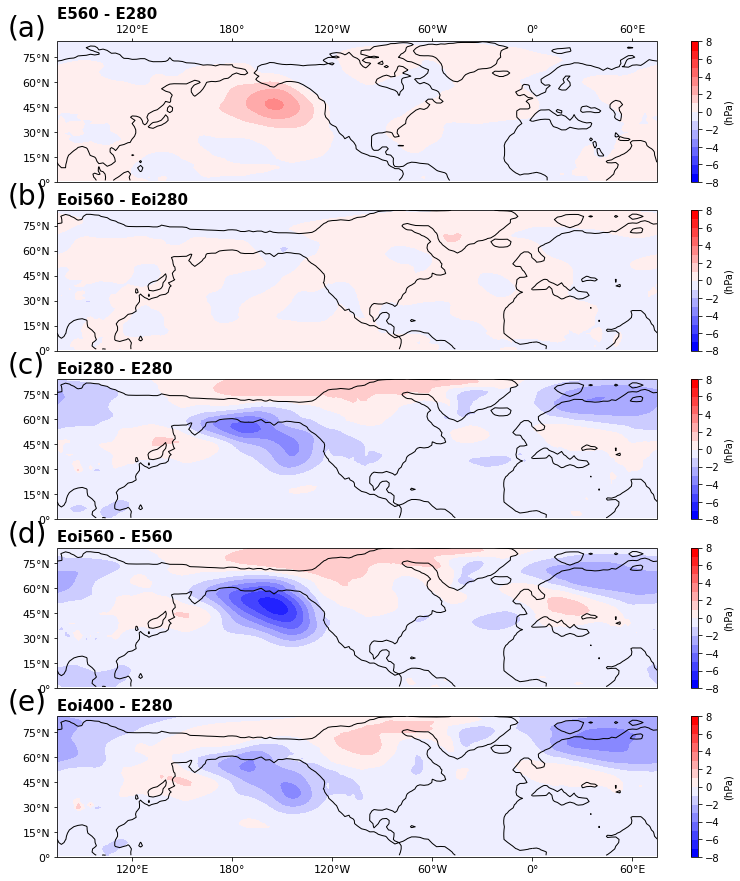

In [69]:
fig = plt.figure(figsize = (12,15), constrained_layout=False)

sdslp1 = cyclic_array(0.01*ds1.SLP.sel(lat=slice(0,85)).std("time"))
sdslp2 = cyclic_array(0.01*ds2.SLP.sel(lat=slice(0,85)).std("time"))
sdslp3 = cyclic_array(0.01*ds3.SLP.sel(lat=slice(0,85)).std("time"))
sdslp4 = cyclic_array(0.01*ds4.SLP.sel(lat=slice(0,85)).std("time"))
sdslp5 = cyclic_array(0.01*ds5.SLP.sel(lat=slice(0,85)).std("time"))

clon = -105;

#############################

vmin2 = -8; vmax2 = 8; d = 1; levels2 = np.arange(vmin2, vmax2+d, d);
    
ax = fig.add_subplot(5,1,1, projection=ccrs.PlateCarree(central_longitude=clon))
(sdslp2 - sdslp1).plot.contourf(ax=ax, transform = ccrs.PlateCarree(),  levels = levels2, cmap = 'bwr', cbar_kwargs={'label':'(hPa)', 'fraction':0.03})
ax.contour(lfnh.lon, lfnh.lat, lfnh.sel(exp=1).landfrac, linewidths = 1., levels=[lfnh.sel(exp=1).clevel], colors = 'k', transform=ccrs.PlateCarree())
ax.set_title(''); ax.set_title('E560 - E280', fontsize = 15, fontweight = 'bold', loc='left'); 
# ax.set_title('MSLP', fontsize = 14, loc='right')
lat_ticks(ax,'NH2'); lon_ticks(ax, 'top'); 
ax.text(-210, 88, '(a)', color='k', fontsize = 28)

ax = fig.add_subplot(5,1,2, projection=ccrs.PlateCarree(central_longitude=clon))
(sdslp5 - sdslp3).plot.contourf(ax=ax, transform = ccrs.PlateCarree(),  levels = levels2, cmap = 'bwr', cbar_kwargs={'label':'(hPa)', 'fraction':0.03})
ax.contour(lfnh.lon, lfnh.lat, lfnh.sel(exp=3).landfrac, linewidths = 1., levels=[lfnh.sel(exp=3).clevel], colors = 'k', transform=ccrs.PlateCarree())
ax.set_title(''); ax.set_title('Eoi560 - Eoi280', fontsize = 15, fontweight = 'bold', loc='left'); 
lat_ticks(ax,'NH2'); #lon_ticks(ax, 'top'); 
ax.text(-210, 88, '(b)', color='k', fontsize = 28)

ax = fig.add_subplot(5,1,3, projection=ccrs.PlateCarree(central_longitude=clon))
(sdslp3 - sdslp1).plot.contourf(ax=ax, transform = ccrs.PlateCarree(),  levels = levels2, cmap = 'bwr', cbar_kwargs={'label':'(hPa)', 'fraction':0.03})
ax.contour(lfnh.lon, lfnh.lat, lfnh.sel(exp=3).landfrac, linewidths = 1., levels=[lfnh.sel(exp=3).clevel], colors = 'k', transform=ccrs.PlateCarree())
ax.set_title(''); ax.set_title('Eoi280 - E280', fontsize = 15, fontweight = 'bold', loc='left'); 
lat_ticks(ax,'NH2');
ax.text(-210, 88, '(c)', color='k', fontsize = 28)

ax = fig.add_subplot(5,1,4, projection=ccrs.PlateCarree(central_longitude=clon))
(sdslp5 - sdslp2).plot.contourf(ax=ax, transform = ccrs.PlateCarree(),  levels = levels2, cmap = 'bwr', cbar_kwargs={'label':'(hPa)', 'fraction':0.03})
ax.contour(lfnh.lon, lfnh.lat, lfnh.sel(exp=3).landfrac, linewidths = 1., levels=[lfnh.sel(exp=3).clevel], colors = 'k', transform=ccrs.PlateCarree())
ax.set_title(''); ax.set_title('Eoi560 - E560', fontsize = 15, fontweight = 'bold', loc='left'); 
lat_ticks(ax,'NH2');
ax.text(-210, 88, '(d)', color='k', fontsize = 28)

ax = fig.add_subplot(5,1,5, projection=ccrs.PlateCarree(central_longitude=clon))
(sdslp4 - sdslp1).plot.contourf(ax=ax, transform = ccrs.PlateCarree(),  levels = levels2, cmap = 'bwr', cbar_kwargs={'label':'(hPa)', 'fraction':0.03})
ax.contour(lfnh.lon, lfnh.lat, lfnh.sel(exp=3).landfrac, linewidths = 1., levels=[lfnh.sel(exp=3).clevel], colors = 'k', transform=ccrs.PlateCarree())
ax.set_title(''); ax.set_title('Eoi400 - E280', fontsize = 15, fontweight = 'bold', loc='left'); 
lat_ticks(ax,'NH2'); lon_ticks(ax, 'bottom'); 
ax.text(-210, 88, '(e)', color='k', fontsize = 28)

plt.savefig('200years/figures/revisions/FIGURES12_raw.png',dpi=300)

## ---- need to remove ----

In [16]:
ebm2_anzm = ebm2.mean('month').mean('lon')
ebm2_janzm = ebm2.isel(month=0).mean('lon')
ebm2_julzm = ebm2.isel(month=6).mean('lon')
ebm2_jan = ebm2.isel(month=0)
ebm2_jul = ebm2.isel(month=6)

ebm3_anzm = ebm3.mean('month').mean('lon')
ebm3_janzm = ebm3.isel(month=0).mean('lon')
ebm3_julzm = ebm3.isel(month=6).mean('lon')
ebm3_jan = ebm3.isel(month=0)
ebm3_jul = ebm3.isel(month=6)

/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/core/alignment.py:307:

Text(0, 0.5, 'Temp (deg C)')

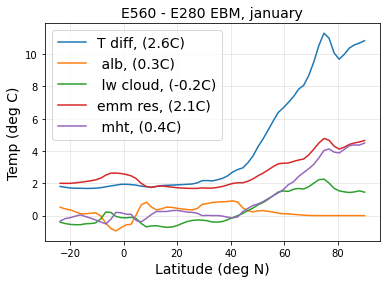

In [187]:
ebm = ebm2_janzm.sel(lat=slice(-25,90))
gw = gridweights.mean("lon").sel(lat=slice(-25,90))

# ebm.Td.plot(label = 'Tdiff', color='k')
# ebm.Tap.plot(label = 'albedo', color = 'b', linestyle = '-')
# # ebm3_anzm.Tas.plot()
# ebm.Tem.plot(label = 'emiss', color = 'r', linestyle = '-')
# ebm.TH.plot(label = 'MHT', color = 'g', linestyle = '--')
# ebm.TLC.plot(label = 'LW cloud', color = 'c', linestyle = ':')
# ebm.Tg.plot()

x = ebm.Td; fmean = np.round(x.weighted(gw).mean("lat"),1).values;
x.plot(label = f'T diff, ({np.round(fmean,1)}C)')

a = (ebm.Tap); fmean = np.round(a.weighted(gw).mean("lat"),1).values;
a.plot(label = f' alb, ({np.round(fmean,1)}C)')
b = (ebm.TLC); fmean = np.round(b.weighted(gw).mean("lat"),1).values;
b.plot(label = f' lw cloud, ({np.round(fmean,1)}C)')
c = ((ebm.Tem - ebm.TLC)); fmean = np.round(c.weighted(gw).mean("lat"),1).values;
c.plot(label = f'emm res, ({np.round(fmean,1)}C)')
d = (ebm.TH); fmean = np.round(d.weighted(gw).mean("lat"),1).values;
d.plot(label = f' mht, ({np.round(fmean,1)}C)')

plt.legend(fontsize = 14)
plt.title('E560 - E280 EBM, january', fontsize = 14)
plt.grid(alpha=0.3)
plt.xlabel('Latitude (deg N)', fontsize = 14)
plt.ylabel('Temp (deg C)', fontsize = 14)


/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/core/alignment.py:307:

Text(0, 0.5, 'Temp (deg C)')

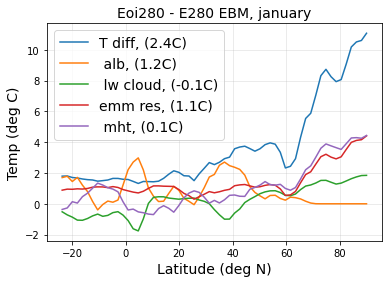

In [188]:
ebm = ebm3_janzm.sel(lat=slice(-25,90))
gw = gridweights.mean("lon").sel(lat=slice(-25,90))

# ebm.Td.plot(label = 'Tdiff', color='k')
# ebm.Tap.plot(label = 'albedo', color = 'b', linestyle = '-')
# # ebm3_anzm.Tas.plot()
# ebm.Tem.plot(label = 'emiss', color = 'r', linestyle = '-')
# ebm.TH.plot(label = 'MHT', color = 'g', linestyle = '--')
# ebm.TLC.plot(label = 'LW cloud', color = 'c', linestyle = ':')
# ebm.Tg.plot()

x = ebm.Td; fmean = np.round(x.weighted(gw).mean("lat"),1).values;
x.plot(label = f'T diff, ({np.round(fmean,1)}C)')

a = (ebm.Tap); fmean = np.round(a.weighted(gw).mean("lat"),1).values;
a.plot(label = f' alb, ({np.round(fmean,1)}C)')
b = (ebm.TLC); fmean = np.round(b.weighted(gw).mean("lat"),1).values;
b.plot(label = f' lw cloud, ({np.round(fmean,1)}C)')
c = ((ebm.Tem - ebm.TLC)); fmean = np.round(c.weighted(gw).mean("lat"),1).values;
c.plot(label = f'emm res, ({np.round(fmean,1)}C)')
d = (ebm.TH); fmean = np.round(d.weighted(gw).mean("lat"),1).values;
d.plot(label = f' mht, ({np.round(fmean,1)}C)')

plt.legend(fontsize = 14)
plt.title('Eoi280 - E280 EBM, january', fontsize = 14)
plt.grid(alpha=0.3)
plt.xlabel('Latitude (deg N)', fontsize = 14)
plt.ylabel('Temp (deg C)', fontsize = 14)


In [174]:
gw = gridweights.mean("lon").sel(lat=slice(-25,90))

/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/core/alignment.py:307:

Text(0, 0.5, 'Temp fraction (-)')

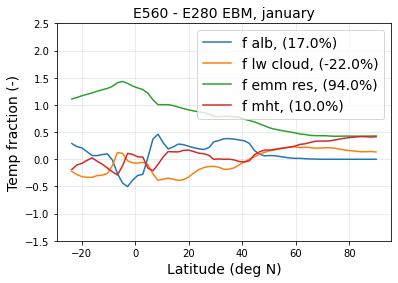

In [181]:
ebm = ebm2_janzm.sel(lat=slice(-25,90))

a = (ebm.Tap / ebm.Td); fmean = np.round(100*a.weighted(gw).mean("lat"),0).values;
a.plot(label = f'f alb, ({np.round(fmean,0)}%)')
b = (ebm.TLC / ebm.Td); fmean = np.round(100*b.weighted(gw).mean("lat"),0).values;
b.plot(label = f'f lw cloud, ({np.round(fmean,0)}%)')
c = ((ebm.Tem - ebm.TLC) / ebm.Td); fmean = np.round(100*c.weighted(gw).mean("lat"),0).values;
c.plot(label = f'f emm res, ({np.round(fmean,0)}%)')
d = (ebm.TH / ebm.Td); fmean = np.round(100*d.weighted(gw).mean("lat"),0).values;
d.plot(label = f'f mht, ({np.round(fmean,0)}%)')

# (a+b+c+d).plot()

plt.legend(fontsize = 14)
plt.title('E560 - E280 EBM, january', fontsize = 14)
plt.grid(alpha=0.3); plt.ylim([-1.5, 2.5])
plt.xlabel('Latitude (deg N)', fontsize = 14)
plt.ylabel('Temp fraction (-)', fontsize = 14)

/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/core/alignment.py:307:

Text(0, 0.5, 'Temp fraction (-)')

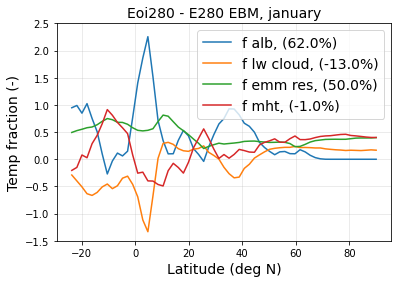

In [182]:
ebm = ebm3_janzm.sel(lat=slice(-25,90))

a = (ebm.Tap / ebm.Td); fmean = np.round(100*a.weighted(gw).mean("lat"),0).values;
a.plot(label = f'f alb, ({np.round(fmean,0)}%)')
b = (ebm.TLC / ebm.Td); fmean = np.round(100*b.weighted(gw).mean("lat"),0).values;
b.plot(label = f'f lw cloud, ({np.round(fmean,0)}%)')
c = ((ebm.Tem - ebm.TLC) / ebm.Td); fmean = np.round(100*c.weighted(gw).mean("lat"),0).values;
c.plot(label = f'f emm res, ({np.round(fmean,0)}%)')
d = (ebm.TH / ebm.Td); fmean = np.round(100*d.weighted(gw).mean("lat"),0).values;
d.plot(label = f'f mht, ({np.round(fmean,0)}%)')

plt.legend(fontsize = 14)
plt.title('Eoi280 - E280 EBM, january', fontsize = 14)
plt.grid(alpha=0.3); plt.ylim([-1.5, 2.5])
plt.xlabel('Latitude (deg N)', fontsize = 14)
plt.ylabel('Temp fraction (-)', fontsize = 14)

Text(0.5, 0.98, 'E560 - E280 EBM, january')

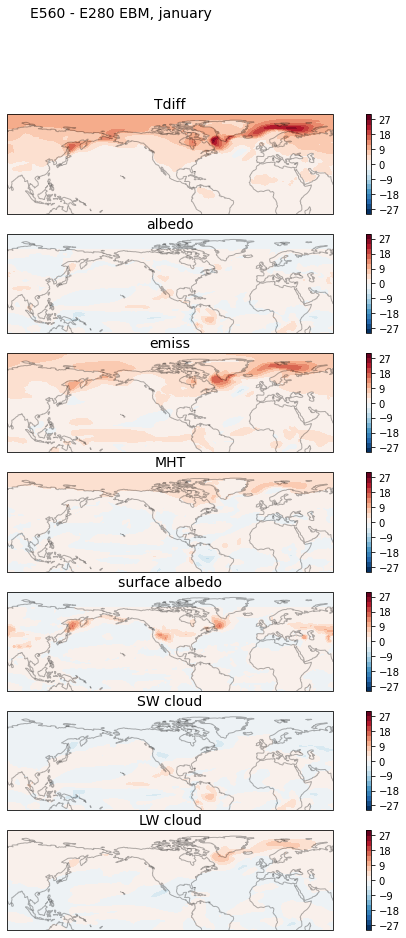

In [20]:
ebm = ebm2_jan.sel(lat=slice(-20,90))
clon = -105

Nfig = 7;

fig = plt.figure(figsize = (12,15))

ax = fig.add_subplot(Nfig,1,1, projection=ccrs.PlateCarree(central_longitude=clon))
cyclic_array(ebm.Td).plot.contourf(ax=ax, levels = np.arange(-30,31, 3), transform = ccrs.PlateCarree())
ax.coastlines(alpha=0.3)
ax.set_title('Tdiff', fontsize = 14)

ax = fig.add_subplot(Nfig,1,2, projection=ccrs.PlateCarree(central_longitude=clon))
cyclic_array(ebm.Tap).plot.contourf(ax=ax, levels = np.arange(-30,31, 3), transform = ccrs.PlateCarree())
ax.coastlines(alpha=0.3)
ax.set_title('albedo', fontsize = 14)

ax = fig.add_subplot(Nfig,1,3, projection=ccrs.PlateCarree(central_longitude=clon))
cyclic_array(ebm.Tem).plot.contourf(ax=ax, levels = np.arange(-30,31, 3), transform = ccrs.PlateCarree())
ax.coastlines(alpha=0.3)
ax.set_title('emiss', fontsize = 14)

ax = fig.add_subplot(Nfig,1,4, projection=ccrs.PlateCarree(central_longitude=clon))
cyclic_array(ebm.TH).plot.contourf(ax=ax, levels = np.arange(-30,31, 3), transform = ccrs.PlateCarree())
ax.coastlines(alpha=0.3)
ax.set_title('MHT', fontsize = 14)

ax = fig.add_subplot(Nfig,1,5, projection=ccrs.PlateCarree(central_longitude=clon))
cyclic_array(ebm.Tas).plot.contourf(ax=ax, levels = np.arange(-30,31, 3), transform = ccrs.PlateCarree())
ax.coastlines(alpha=0.3)
ax.set_title('surface albedo', fontsize = 14)

ax = fig.add_subplot(Nfig,1,6, projection=ccrs.PlateCarree(central_longitude=clon))
cyclic_array(ebm.TSC).plot.contourf(ax=ax, levels = np.arange(-30,31, 3), transform = ccrs.PlateCarree())
ax.coastlines(alpha=0.3)
ax.set_title('SW cloud', fontsize = 14)

ax = fig.add_subplot(Nfig,1,7, projection=ccrs.PlateCarree(central_longitude=clon))
cyclic_array(ebm.TLC).plot.contourf(ax=ax, levels = np.arange(-30,31, 3), transform = ccrs.PlateCarree())
ax.coastlines(alpha=0.3)
ax.set_title('LW cloud', fontsize = 14)



plt.suptitle('E560 - E280 EBM, january', fontsize = 14)

# ax = fig.add_subplot(515, projection=ccrs.PlateCarree(central_longitude=clon))
# (ebm.Tap + ebm.Tem + ebm.TH).plot.contourf(ax=ax, levels = np.arange(-30,31, 5), transform = ccrs.PlateCarree())
# ax.coastlines(alpha=0.3)
# ax.set_title('albedo + emiss + MHT', fontsize = 14)

# ebm.Tap.plot(label = 'albedo')
# # ebm3_anzm.Tas.plot()
# ebm.Tem.plot(label = 'emiss')
# ebm.TH.plot(label = 'MHT')

Text(0.5, 0.98, 'Eoi280 - E280 EBM, january')

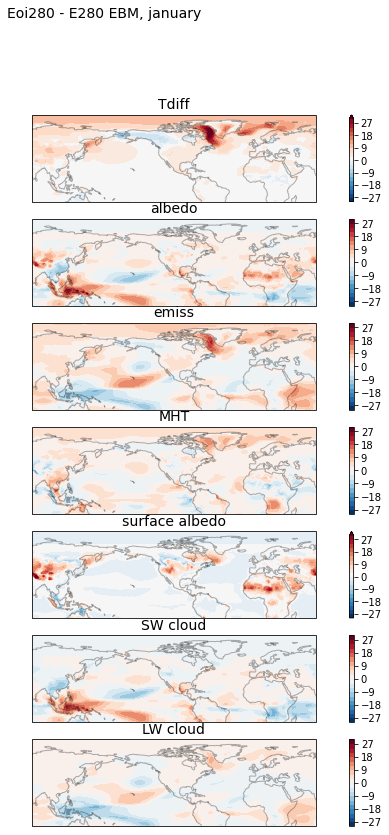

In [21]:
ebm = ebm3_jan.sel(lat=slice(-20,90))
clon = -105

Nfig = 8;

fig = plt.figure(figsize = (12,15))

ax = fig.add_subplot(Nfig,1,1, projection=ccrs.PlateCarree(central_longitude=clon))
cyclic_array(ebm.Td).plot.contourf(ax=ax, levels = np.arange(-30,31, 3), transform = ccrs.PlateCarree())
ax.coastlines(alpha=0.3)
ax.set_title('Tdiff', fontsize = 14)

ax = fig.add_subplot(Nfig,1,2, projection=ccrs.PlateCarree(central_longitude=clon))
cyclic_array(ebm.Tap).plot.contourf(ax=ax, levels = np.arange(-30,31, 3), transform = ccrs.PlateCarree())
ax.coastlines(alpha=0.3)
ax.set_title('albedo', fontsize = 14)

ax = fig.add_subplot(Nfig,1,3, projection=ccrs.PlateCarree(central_longitude=clon))
cyclic_array(ebm.Tem).plot.contourf(ax=ax, levels = np.arange(-30,31, 3), transform = ccrs.PlateCarree())
ax.coastlines(alpha=0.3)
ax.set_title('emiss', fontsize = 14)

ax = fig.add_subplot(Nfig,1,4, projection=ccrs.PlateCarree(central_longitude=clon))
cyclic_array(ebm.TH).plot.contourf(ax=ax, levels = np.arange(-30,31, 3), transform = ccrs.PlateCarree())
ax.coastlines(alpha=0.3)
ax.set_title('MHT', fontsize = 14)

ax = fig.add_subplot(Nfig,1,5, projection=ccrs.PlateCarree(central_longitude=clon))
cyclic_array(ebm.Tas).plot.contourf(ax=ax, levels = np.arange(-30,31, 3), transform = ccrs.PlateCarree())
ax.coastlines(alpha=0.3)
ax.set_title('surface albedo', fontsize = 14)

ax = fig.add_subplot(Nfig,1,6, projection=ccrs.PlateCarree(central_longitude=clon))
cyclic_array(ebm.TSC).plot.contourf(ax=ax, levels = np.arange(-30,31, 3), transform = ccrs.PlateCarree())
ax.coastlines(alpha=0.3)
ax.set_title('SW cloud', fontsize = 14)

ax = fig.add_subplot(Nfig,1,7, projection=ccrs.PlateCarree(central_longitude=clon))
cyclic_array(ebm.TLC).plot.contourf(ax=ax, levels = np.arange(-30,31, 3), transform = ccrs.PlateCarree())
ax.coastlines(alpha=0.3)
ax.set_title('LW cloud', fontsize = 14)



plt.suptitle('Eoi280 - E280 EBM, january', fontsize = 14)

# ax = fig.add_subplot(515, projection=ccrs.PlateCarree(central_longitude=clon))
# (ebm.Tap + ebm.Tem + ebm.TH).plot.contourf(ax=ax, levels = np.arange(-30,31, 5), transform = ccrs.PlateCarree())
# ax.coastlines(alpha=0.3)
# ax.set_title('albedo + emiss + MHT', fontsize = 14)

# ebm.Tap.plot(label = 'albedo')
# # ebm3_anzm.Tas.plot()
# ebm.Tem.plot(label = 'emiss')
# ebm.TH.plot(label = 'MHT')

Text(0.5, 0.98, 'Eoi280 - E280 EBM, january')

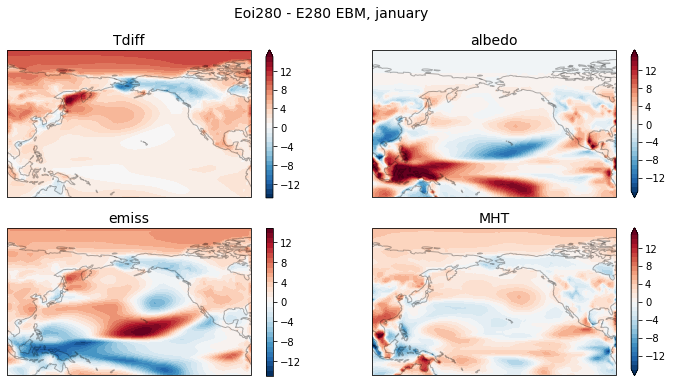

In [139]:
ebm = ebm3_jan.sel(lat=slice(-20,90)).sel(lon = slice(100, 280))
clon = -105

levels_ = np.arange(-15,16, 1)

fig = plt.figure(figsize = (12,6))

ax = fig.add_subplot(221, projection=ccrs.PlateCarree(central_longitude=clon))
cyclic_array(ebm.Td).plot.contourf(ax=ax, levels = levels_, transform = ccrs.PlateCarree())
ax.coastlines(alpha=0.3)
ax.set_title('Tdiff', fontsize = 14)

ax = fig.add_subplot(222, projection=ccrs.PlateCarree(central_longitude=clon))
cyclic_array(ebm.Tap).plot.contourf(ax=ax, levels = levels_, transform = ccrs.PlateCarree())
ax.coastlines(alpha=0.3)
ax.set_title('albedo', fontsize = 14)

ax = fig.add_subplot(223, projection=ccrs.PlateCarree(central_longitude=clon))
cyclic_array(ebm.Tem).plot.contourf(ax=ax, levels = levels_, transform = ccrs.PlateCarree())
ax.coastlines(alpha=0.3)
ax.set_title('emiss', fontsize = 14)

ax = fig.add_subplot(224, projection=ccrs.PlateCarree(central_longitude=clon))
cyclic_array(ebm.TH).plot.contourf(ax=ax, levels = levels_, transform = ccrs.PlateCarree())
ax.coastlines(alpha=0.3)
ax.set_title('MHT', fontsize = 14)

plt.suptitle('Eoi280 - E280 EBM, january', fontsize = 14)

# ax = fig.add_subplot(515, projection=ccrs.PlateCarree(central_longitude=clon))
# (ebm.Tap + ebm.Tem + ebm.TH).plot.contourf(ax=ax, levels = np.arange(-30,31, 5), transform = ccrs.PlateCarree())
# ax.coastlines(alpha=0.3)
# ax.set_title('albedo + emiss + MHT', fontsize = 14)

# ebm.Tap.plot(label = 'albedo')
# # ebm3_anzm.Tas.plot()
# ebm.Tem.plot(label = 'emiss')
# ebm.TH.plot(label = 'MHT')

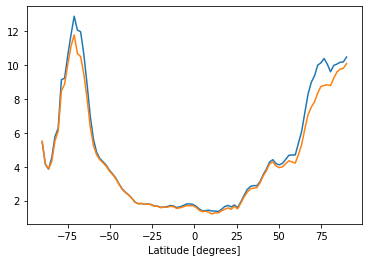

In [76]:
ebm3_anzm.Td.plot()
(ebm3_anzm.Tap + ebm3_anzm.Tem + ebm3_anzm.TH).plot()